In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import gc
import time
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

C:\Users\POLAB\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv("./Data8.csv", engine='python')
df = df.drop(['Unnamed: 0'], axis=1)
input_dim = df.shape[1] - 1  # only X dim
df.head()

,TrainCharacteristicIC,TrainCharacteristicLM,TrainCharacteristicSPR,Trainnumber11618,Trainnumber11622,Trainnumber11623,Trainnumber11627,Trainnumber11716,Trainnumber11720,Trainnumber11721,...,Rain,Slack,DelayJump,SlackSum,DriverDelay,DriverToNow,RollDelay_co,RollToNow_co,RollDelay_cn,RollToNow_cn
0,1,0,0,0,0,0,0,0,0,0,...,0.6,-29.0,17,10.0,122,2640.0,0,0.0,0,0.0
1,1,0,0,0,0,0,0,0,0,0,...,0.6,14.0,32,43.0,122,3120.0,0,0.0,0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.6,-28.0,-40,92.0,122,3240.0,0,0.0,0,0.0
3,1,0,0,0,0,0,0,0,0,0,...,0.6,42.0,42,78.0,122,3480.0,0,0.0,0,0.0
4,1,0,0,0,0,0,0,0,0,0,...,0.6,-12.0,15,49.0,122,3600.0,0,0.0,0,0.0


In [3]:
# split data into train and test
X=np.array(df.drop(['DelayJump'], axis=1))
y=np.array(df['DelayJump'] )# df.DelayJump
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
del df, X, y
gc.collect()

129

# Build Model


In [13]:
def build_model(node_fraction, learning_rate):
    model = Sequential()

    # Hidden-1
    model.add(Dense(input_dim = input_dim, units = round(input_dim*node_fraction), kernel_initializer = 'glorot_normal', activation = 'relu') )
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    這裡有開耶？
    

    # Hidden-2
    model.add(Dense(units=round(input_dim*node_fraction**2), kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.2))

    
    # Hidden-3
    model.add(Dense(units=round(input_dim*node_fraction**3), kernel_initializer='glorot_normal', activation='relu'))
#     model.add(Dropout(0.2)) 這裡拉 我沒開 所已是最後一層沒開的意思 對  嗯嗯～我後面四層的，也照著這個邏輯，最後一層沒開恩恩 那裡記錄有幫我留下媽
# 其實本來有，就是剛剛下面這邊，我反白給你看

    # output
    model.add(Dense(units = 1,kernel_initializer = 'glorot_normal'))

    print(model.summary())

    # compile
    model.compile(loss='mse',  
                  optimizer=Adam(lr=learning_rate), 
                  metrics=['mae'],
                 ) 
    
    return model

def eval_perf(X_train, y_train, X_test, y_test, model):
    y_pred = model.predict(X_train, batch_size=32, verbose=1)
    y_pred = np.reshape(y_pred, len(y_train))
    train_r2 = r2_score(y_train, y_pred, sample_weight=None, multioutput='uniform_average')
    
    y_pred = model.predict(X_test, batch_size=32, verbose=1)
    y_pred = np.reshape(y_pred, len(y_test))
    test_r2 = r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')
    
    test_mae = sum(abs(y_test-y_pred)) / len(y_test)
    
    return train_r2, test_r2, test_mae

In [6]:
kf = KFold(n_splits=5)
for train_index, valid_index in kf.split(X_train):
    print(train_index,  len(train_index), valid_index, len(valid_index))

[16349 16350 16351 ... 81741 81742 81743] 65395 [    0     1     2 ... 16346 16347 16348] 16349
[    0     1     2 ... 81741 81742 81743] 65395 [16349 16350 16351 ... 32695 32696 32697] 16349
[    0     1     2 ... 81741 81742 81743] 65395 [32698 32699 32700 ... 49044 49045 49046] 16349
[    0     1     2 ... 81741 81742 81743] 65395 [49047 49048 49049 ... 65393 65394 65395] 16349
[    0     1     2 ... 65393 65394 65395] 65396 [65396 65397 65398 ... 81741 81742 81743] 16348


In [8]:
start_time = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
kf = KFold(n_splits=5)
k_count = 1
cv_result={}
node_fraction_list=[2/7, 1/3, 1/2, 2/3, 5/6]
learning_rate_list=[0.001, 0.005, 0.01, 0.05, 0.1]

for train_index, valid_index in kf.split(X_train):   
    print('Fold = ' + str(k_count) + ' Start!')
    
    # k-fold data
    X_train_cv = X_train[train_index]
    y_train_cv = y_train[train_index]
    X_valid_cv = X_train[valid_index]
    y_valid_cv = y_train[valid_index]
    
    para_combine = {}
    
    # build model 
    for node_fraction in node_fraction_list:
        for learning_rate in learning_rate_list:
            
            # model
            model=build_model(node_fraction, learning_rate)
            train_history = model.fit(x = X_train_cv,
                                      y = y_train_cv,
                                      #validation_split = 0.2, 
                                      validation_data = (X_valid_cv, y_valid_cv),
                                      epochs = 1000, 
                                      batch_size = 200,
                                      verbose = 1,
                                      callbacks = [early_stopping])
            # eval performance
            key = 'nodeF:' + str(node_fraction) + '---' + 'lr:' + str(learning_rate)

            train_r2, valid_r2, valid_mae = eval_perf(X_train_cv, y_train_cv, X_valid_cv, y_valid_cv, model)
            para_combine[key] = (train_r2, valid_r2, valid_mae)
            
                    
            print('=====' + key + '=====')
            print((train_r2, valid_r2, valid_mae))
    
    # record by k-fold
    cv_result[k_count]=para_combine
    k_count += 1
    
    print('the elapsed time:%s'% (time.time() - start_time))
    print('\n\n')
    
print('The total running time:%s'% (time.time() - start_time))


Fold = 1 Start!
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 940)               3093540   
_________________________________________________________________
batch_normalization_2 (Batch (None, 940)               3760      
_________________________________________________________________
dropout_3 (Dropout)          (None, 940)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 269)               253129    
_________________________________________________________________
dropout_4 (Dropout)          (None, 269)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 270       
Total params: 3,350,699
Trainable params: 3,348,819
Non-trainable params: 1,880
______________________________________________

Epoch 40/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5609.4500 - mean_absolute_error: 49.8138 - val_loss: 7793.9641 - val_mean_absolute_error: 53.1065
Epoch 41/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5592.9201 - mean_absolute_error: 49.9422 - val_loss: 7637.6511 - val_mean_absolute_error: 53.1079
Epoch 42/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5654.3842 - mean_absolute_error: 50.0238 - val_loss: 7358.1548 - val_mean_absolute_error: 55.2537
Epoch 43/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5546.8229 - mean_absolute_error: 49.7051 - val_loss: 7223.7658 - val_mean_absolute_error: 52.6773
Epoch 44/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5500.4087 - mean_absolute_error: 49.3364 - val_loss: 6993.2991 - val_mean_absolute_error: 53.8043
Epoch 45/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5400.5823 - mean_a

65395/65395 [==============================] - 4s 59us/step - loss: 3459.1125 - mean_absolute_error: 40.3343 - val_loss: 6136.1493 - val_mean_absolute_error: 49.0322
Epoch 131/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3406.6203 - mean_absolute_error: 40.1518 - val_loss: 6390.9886 - val_mean_absolute_error: 49.4066
Epoch 132/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3376.1914 - mean_absolute_error: 39.9993 - val_loss: 5883.5055 - val_mean_absolute_error: 47.9985
Epoch 133/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3437.2389 - mean_absolute_error: 40.2353 - val_loss: 6068.6211 - val_mean_absolute_error: 48.0763
Epoch 134/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3436.5256 - mean_absolute_error: 40.1183 - val_loss: 5991.5773 - val_mean_absolute_error: 47.7484
Epoch 135/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3363.2188 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 2498.9532 - mean_absolute_error: 34.6714 - val_loss: 6039.6084 - val_mean_absolute_error: 46.6052
Epoch 221/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2550.8445 - mean_absolute_error: 34.9062 - val_loss: 5426.3940 - val_mean_absolute_error: 46.4181
Epoch 222/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2688.5180 - mean_absolute_error: 35.4913 - val_loss: 5760.1537 - val_mean_absolute_error: 46.3623
Epoch 223/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2614.8805 - mean_absolute_error: 35.0919 - val_loss: 5492.3456 - val_mean_absolute_error: 45.7091
Epoch 224/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2558.5454 - mean_absolute_error: 34.8977 - val_loss: 5600.6408 - val_mean_absolute_error: 46.5474
Epoch 225/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2491.5590 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 2027.2478 - mean_absolute_error: 31.2727 - val_loss: 5467.7964 - val_mean_absolute_error: 44.4483
Epoch 311/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2060.2167 - mean_absolute_error: 31.3401 - val_loss: 5243.7758 - val_mean_absolute_error: 43.7992
Epoch 312/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2030.5180 - mean_absolute_error: 31.2001 - val_loss: 5546.1002 - val_mean_absolute_error: 45.1889
Epoch 313/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2032.6840 - mean_absolute_error: 31.1802 - val_loss: 5257.1345 - val_mean_absolute_error: 44.2890
Epoch 314/1000
65395/65395 [==============================] - 4s 59us/step - loss: 1967.9895 - mean_absolute_error: 30.8043 - val_loss: 5133.5175 - val_mean_absolute_error: 43.9343
Epoch 315/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2012.2606 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 1733.1836 - mean_absolute_error: 28.7515 - val_loss: 5077.2484 - val_mean_absolute_error: 42.8194
Epoch 401/1000
65395/65395 [==============================] - 4s 59us/step - loss: 1685.3703 - mean_absolute_error: 28.4453 - val_loss: 5067.3055 - val_mean_absolute_error: 43.1389
Epoch 402/1000
65395/65395 [==============================] - 4s 59us/step - loss: 1718.3216 - mean_absolute_error: 28.6472 - val_loss: 5327.4534 - val_mean_absolute_error: 43.9219
Epoch 403/1000
65395/65395 [==============================] - 4s 59us/step - loss: 1729.5281 - mean_absolute_error: 28.8316 - val_loss: 5234.4525 - val_mean_absolute_error: 43.1004
Epoch 404/1000
65395/65395 [==============================] - 4s 59us/step - loss: 1687.0521 - mean_absolute_error: 28.5343 - val_loss: 5057.4739 - val_mean_absolute_error: 43.4033
Epoch 405/1000
65395/65395 [==============================] - 4s 59us/step - loss: 1701.7411 - mean_absolute_e

Epoch 39/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5908.9108 - mean_absolute_error: 51.2910 - val_loss: 7692.4372 - val_mean_absolute_error: 54.4156
Epoch 40/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5973.7541 - mean_absolute_error: 51.3751 - val_loss: 7511.6001 - val_mean_absolute_error: 56.0156
Epoch 41/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5818.3473 - mean_absolute_error: 50.9837 - val_loss: 7423.0331 - val_mean_absolute_error: 53.3142
Epoch 42/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5759.4052 - mean_absolute_error: 50.6130 - val_loss: 7196.9116 - val_mean_absolute_error: 53.1903
Epoch 43/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5819.6364 - mean_absolute_error: 50.8130 - val_loss: 7361.2705 - val_mean_absolute_error: 55.1145
Epoch 44/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5683.0299 - mean_a

65395/65395 [==============================] - 4s 60us/step - loss: 3611.4730 - mean_absolute_error: 41.2251 - val_loss: 5980.8872 - val_mean_absolute_error: 47.9054
Epoch 130/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3577.6460 - mean_absolute_error: 41.0087 - val_loss: 6040.2081 - val_mean_absolute_error: 48.2871
Epoch 131/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3593.2339 - mean_absolute_error: 41.2111 - val_loss: 6273.9596 - val_mean_absolute_error: 49.0128
Epoch 132/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3637.6573 - mean_absolute_error: 41.2355 - val_loss: 6492.9717 - val_mean_absolute_error: 48.8953
Epoch 133/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3649.1799 - mean_absolute_error: 41.2276 - val_loss: 6068.1839 - val_mean_absolute_error: 48.6128
Epoch 134/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3569.5871 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 2781.0855 - mean_absolute_error: 36.4376 - val_loss: 5645.1464 - val_mean_absolute_error: 47.4122
Epoch 220/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2763.4257 - mean_absolute_error: 36.3562 - val_loss: 6446.9935 - val_mean_absolute_error: 51.1054
Epoch 221/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2813.6279 - mean_absolute_error: 36.7865 - val_loss: 5870.8241 - val_mean_absolute_error: 47.0861
Epoch 222/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2672.5884 - mean_absolute_error: 35.9835 - val_loss: 5616.0746 - val_mean_absolute_error: 46.0948
Epoch 223/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2714.8231 - mean_absolute_error: 35.9893 - val_loss: 5640.5446 - val_mean_absolute_error: 46.5728
Epoch 224/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2697.0349 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 2302.8561 - mean_absolute_error: 33.2281 - val_loss: 5427.6004 - val_mean_absolute_error: 45.2315
Epoch 310/1000
65395/65395 [==============================] - 4s 58us/step - loss: 2221.9217 - mean_absolute_error: 32.7565 - val_loss: 5268.8677 - val_mean_absolute_error: 44.5978
Epoch 311/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2167.4751 - mean_absolute_error: 32.3706 - val_loss: 5416.8210 - val_mean_absolute_error: 44.2682
Epoch 312/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2296.7719 - mean_absolute_error: 33.0128 - val_loss: 5229.3133 - val_mean_absolute_error: 44.6452
Epoch 313/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2249.5473 - mean_absolute_error: 32.7465 - val_loss: 5365.0637 - val_mean_absolute_error: 45.6996
Epoch 314/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2241.7133 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 9421.0547 - mean_absolute_error: 62.6154 - val_loss: 9505.3706 - val_mean_absolute_error: 61.2273
Epoch 6/1000
65395/65395 [==============================] - 4s 58us/step - loss: 9257.1190 - mean_absolute_error: 62.0989 - val_loss: 9502.6432 - val_mean_absolute_error: 60.6372
Epoch 7/1000
65395/65395 [==============================] - 4s 58us/step - loss: 9041.1456 - mean_absolute_error: 61.4620 - val_loss: 9521.5423 - val_mean_absolute_error: 61.6559
Epoch 8/1000
65395/65395 [==============================] - 4s 58us/step - loss: 8986.7959 - mean_absolute_error: 61.1688 - val_loss: 9262.8339 - val_mean_absolute_error: 59.8792
Epoch 9/1000
65395/65395 [==============================] - 4s 58us/step - loss: 8722.4794 - mean_absolute_error: 60.3595 - val_loss: 9091.0846 - val_mean_absolute_error: 60.8368
Epoch 10/1000
65395/65395 [==============================] - 4s 59us/step - loss: 8544.1649 - mean_absolute_error: 59.

65395/65395 [==============================] - 4s 60us/step - loss: 4831.0894 - mean_absolute_error: 47.1698 - val_loss: 6682.6276 - val_mean_absolute_error: 51.0208
Epoch 96/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4802.0222 - mean_absolute_error: 47.0130 - val_loss: 6549.6813 - val_mean_absolute_error: 50.9607
Epoch 97/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4751.9457 - mean_absolute_error: 47.0116 - val_loss: 6918.8891 - val_mean_absolute_error: 52.7050
Epoch 98/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4839.3135 - mean_absolute_error: 47.1530 - val_loss: 7310.6888 - val_mean_absolute_error: 53.2021
Epoch 99/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4713.5655 - mean_absolute_error: 46.6935 - val_loss: 6554.0590 - val_mean_absolute_error: 51.7940
Epoch 100/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4527.6298 - mean_absolute_error

65395/65395 [==============================] - 4s 60us/step - loss: 3512.9389 - mean_absolute_error: 40.9525 - val_loss: 6025.8237 - val_mean_absolute_error: 47.5501
Epoch 186/1000
65395/65395 [==============================] - 4s 60us/step - loss: 3481.6815 - mean_absolute_error: 40.7302 - val_loss: 5975.4914 - val_mean_absolute_error: 49.3861
Epoch 187/1000
65395/65395 [==============================] - 4s 60us/step - loss: 3529.3540 - mean_absolute_error: 40.7869 - val_loss: 6023.2612 - val_mean_absolute_error: 48.6137
Epoch 188/1000
65395/65395 [==============================] - 4s 60us/step - loss: 3548.0914 - mean_absolute_error: 40.8332 - val_loss: 6297.9094 - val_mean_absolute_error: 49.1570
Epoch 189/1000
65395/65395 [==============================] - 4s 60us/step - loss: 3392.2483 - mean_absolute_error: 40.2273 - val_loss: 5987.5668 - val_mean_absolute_error: 47.6482
Epoch 190/1000
65395/65395 [==============================] - 4s 60us/step - loss: 3538.3402 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 2909.0277 - mean_absolute_error: 37.4167 - val_loss: 5799.6700 - val_mean_absolute_error: 48.6311
Epoch 276/1000
65395/65395 [==============================] - 4s 60us/step - loss: 2855.9042 - mean_absolute_error: 37.0984 - val_loss: 5548.2339 - val_mean_absolute_error: 46.7086
Epoch 277/1000
65395/65395 [==============================] - 4s 60us/step - loss: 2924.6198 - mean_absolute_error: 37.2869 - val_loss: 6001.0192 - val_mean_absolute_error: 48.9310
Epoch 278/1000
65395/65395 [==============================] - 4s 60us/step - loss: 2959.4974 - mean_absolute_error: 37.3989 - val_loss: 6039.0570 - val_mean_absolute_error: 49.7096
Epoch 279/1000
65395/65395 [==============================] - 4s 60us/step - loss: 2898.1803 - mean_absolute_error: 37.2389 - val_loss: 5699.4789 - val_mean_absolute_error: 46.7512
Epoch 280/1000
65395/65395 [==============================] - 4s 60us/step - loss: 2914.1634 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 9444.7233 - mean_absolute_error: 63.2040 - val_loss: 9587.0717 - val_mean_absolute_error: 60.8790
Epoch 13/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9324.8158 - mean_absolute_error: 63.0034 - val_loss: 10194.5095 - val_mean_absolute_error: 65.3760
Epoch 14/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9280.8326 - mean_absolute_error: 62.8035 - val_loss: 9279.1916 - val_mean_absolute_error: 63.2934
Epoch 15/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9189.5021 - mean_absolute_error: 62.9887 - val_loss: 9935.9086 - val_mean_absolute_error: 62.8324
Epoch 16/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9188.2370 - mean_absolute_error: 62.5739 - val_loss: 9791.7064 - val_mean_absolute_error: 67.1211
Epoch 17/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9204.9237 - mean_absolute_error

65395/65395 [==============================] - 4s 59us/step - loss: 6961.1897 - mean_absolute_error: 55.9707 - val_loss: 8463.9427 - val_mean_absolute_error: 60.4520
Epoch 103/1000
65395/65395 [==============================] - 4s 59us/step - loss: 7121.8116 - mean_absolute_error: 56.2881 - val_loss: 8252.7086 - val_mean_absolute_error: 58.9415
Epoch 104/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7320.9295 - mean_absolute_error: 57.0414 - val_loss: 7982.9105 - val_mean_absolute_error: 57.0760
Epoch 105/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7234.9376 - mean_absolute_error: 56.9186 - val_loss: 7828.5243 - val_mean_absolute_error: 58.5370
Epoch 106/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7195.9371 - mean_absolute_error: 56.5323 - val_loss: 8367.5350 - val_mean_absolute_error: 56.7428
Epoch 107/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7211.8169 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 6256.5621 - mean_absolute_error: 53.4835 - val_loss: 7542.7652 - val_mean_absolute_error: 57.7241
Epoch 193/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6155.6253 - mean_absolute_error: 52.9033 - val_loss: 7536.1793 - val_mean_absolute_error: 56.7960
Epoch 194/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6414.5182 - mean_absolute_error: 53.7935 - val_loss: 7331.4559 - val_mean_absolute_error: 53.9596
Epoch 195/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6272.3338 - mean_absolute_error: 53.7860 - val_loss: 7329.3017 - val_mean_absolute_error: 54.2889
Epoch 196/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6397.8975 - mean_absolute_error: 53.8752 - val_loss: 7246.0772 - val_mean_absolute_error: 53.7795
Epoch 197/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6141.8659 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 5916.0402 - mean_absolute_error: 51.9343 - val_loss: 9464.9266 - val_mean_absolute_error: 54.9373
Epoch 283/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6010.8334 - mean_absolute_error: 52.2243 - val_loss: 7261.9684 - val_mean_absolute_error: 57.4533
Epoch 284/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6128.6034 - mean_absolute_error: 52.6751 - val_loss: 7428.8908 - val_mean_absolute_error: 58.2062
Epoch 285/1000
65395/65395 [==============================] - 4s 60us/step - loss: 5900.1003 - mean_absolute_error: 52.1490 - val_loss: 7131.1521 - val_mean_absolute_error: 54.2819
Epoch 286/1000
65395/65395 [==============================] - 4s 60us/step - loss: 5940.9893 - mean_absolute_error: 51.8407 - val_loss: 8296.6377 - val_mean_absolute_error: 59.7163
Epoch 287/1000
65395/65395 [==============================] - 4s 60us/step - loss: 5862.9079 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 10227.6324 - mean_absolute_error: 65.6769 - val_loss: 9892.1388 - val_mean_absolute_error: 65.2322
Epoch 00073: early stopping
16349/16349 [==============================] - 1s 56us/step
=====nodeF:0.2857142857142857---lr:0.1=====
(0.2469539093889641, 0.20853908934371546, 65.23222565596983)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1097)              3610227   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1097)              4388      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1097)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 366)               401868    
______________________________________________

65395/65395 [==============================] - 4s 66us/step - loss: 4146.8800 - mean_absolute_error: 43.6168 - val_loss: 7247.7986 - val_mean_absolute_error: 56.3842
Epoch 83/1000
65395/65395 [==============================] - 4s 65us/step - loss: 4152.7047 - mean_absolute_error: 43.8668 - val_loss: 6351.1149 - val_mean_absolute_error: 50.2816
Epoch 84/1000
65395/65395 [==============================] - 4s 65us/step - loss: 4091.7086 - mean_absolute_error: 43.4235 - val_loss: 6200.3727 - val_mean_absolute_error: 50.0116
Epoch 85/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4032.4367 - mean_absolute_error: 43.3562 - val_loss: 6702.5723 - val_mean_absolute_error: 50.8465
Epoch 86/1000
65395/65395 [==============================] - 4s 65us/step - loss: 4093.6643 - mean_absolute_error: 43.4085 - val_loss: 6593.8318 - val_mean_absolute_error: 50.4456
Epoch 87/1000
65395/65395 [==============================] - 4s 64us/step - loss: 4043.8990 - mean_absolute_error:

65395/65395 [==============================] - 4s 63us/step - loss: 2788.8467 - mean_absolute_error: 36.4369 - val_loss: 5764.4630 - val_mean_absolute_error: 46.8746
Epoch 173/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2755.5616 - mean_absolute_error: 36.3615 - val_loss: 5650.2813 - val_mean_absolute_error: 46.4297
Epoch 174/1000
65395/65395 [==============================] - 4s 64us/step - loss: 2876.3739 - mean_absolute_error: 36.7992 - val_loss: 5608.0706 - val_mean_absolute_error: 47.6926
Epoch 175/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2678.3684 - mean_absolute_error: 35.8064 - val_loss: 5764.2084 - val_mean_absolute_error: 46.6989
Epoch 176/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2812.8599 - mean_absolute_error: 36.3675 - val_loss: 5504.2253 - val_mean_absolute_error: 45.8872
Epoch 177/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2709.2158 - mean_absolute_e

65395/65395 [==============================] - 4s 64us/step - loss: 2056.1611 - mean_absolute_error: 31.3957 - val_loss: 5223.7512 - val_mean_absolute_error: 45.5233
Epoch 263/1000
65395/65395 [==============================] - 4s 64us/step - loss: 2044.8270 - mean_absolute_error: 31.2157 - val_loss: 5200.2749 - val_mean_absolute_error: 44.1895
Epoch 264/1000
65395/65395 [==============================] - 4s 64us/step - loss: 2090.7742 - mean_absolute_error: 31.4050 - val_loss: 5099.8401 - val_mean_absolute_error: 44.4136
Epoch 265/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2030.8030 - mean_absolute_error: 31.2508 - val_loss: 5351.8890 - val_mean_absolute_error: 44.1933
Epoch 266/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2109.6643 - mean_absolute_error: 31.6561 - val_loss: 5358.3567 - val_mean_absolute_error: 44.5102
Epoch 267/1000
65395/65395 [==============================] - 4s 64us/step - loss: 2094.3557 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 1751.7288 - mean_absolute_error: 28.6487 - val_loss: 5380.7110 - val_mean_absolute_error: 43.3932
Epoch 353/1000
65395/65395 [==============================] - 4s 64us/step - loss: 1731.6472 - mean_absolute_error: 28.6668 - val_loss: 4905.6835 - val_mean_absolute_error: 42.9854
Epoch 354/1000
65395/65395 [==============================] - 4s 62us/step - loss: 1759.7053 - mean_absolute_error: 28.7336 - val_loss: 5257.4513 - val_mean_absolute_error: 44.0781
Epoch 355/1000
65395/65395 [==============================] - 4s 62us/step - loss: 1735.3477 - mean_absolute_error: 28.5900 - val_loss: 5015.4904 - val_mean_absolute_error: 43.4173
Epoch 356/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1651.3299 - mean_absolute_error: 28.2194 - val_loss: 4995.5515 - val_mean_absolute_error: 42.8911
Epoch 357/1000
65395/65395 [==============================] - 4s 64us/step - loss: 1686.0024 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 1394.0739 - mean_absolute_error: 25.8488 - val_loss: 5083.9165 - val_mean_absolute_error: 43.0256
Epoch 443/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1438.3090 - mean_absolute_error: 26.1648 - val_loss: 4703.9803 - val_mean_absolute_error: 41.9020
Epoch 444/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1475.9820 - mean_absolute_error: 26.3233 - val_loss: 4926.9231 - val_mean_absolute_error: 42.4025
Epoch 445/1000
65395/65395 [==============================] - 4s 62us/step - loss: 1475.5333 - mean_absolute_error: 26.4940 - val_loss: 5012.5047 - val_mean_absolute_error: 42.9614
Epoch 446/1000
65395/65395 [==============================] - 4s 65us/step - loss: 1418.1465 - mean_absolute_error: 25.9972 - val_loss: 4780.5177 - val_mean_absolute_error: 41.7162
Epoch 447/1000
65395/65395 [==============================] - 4s 65us/step - loss: 1446.1390 - mean_absolute_e

65395/65395 [==============================] - 4s 62us/step - loss: 1267.7729 - mean_absolute_error: 24.5549 - val_loss: 4609.3911 - val_mean_absolute_error: 41.4606
Epoch 533/1000
65395/65395 [==============================] - 4s 67us/step - loss: 1230.8557 - mean_absolute_error: 24.2240 - val_loss: 4823.1165 - val_mean_absolute_error: 41.2919
Epoch 534/1000
65395/65395 [==============================] - 4s 66us/step - loss: 1247.1602 - mean_absolute_error: 24.4792 - val_loss: 4877.6753 - val_mean_absolute_error: 41.5347
Epoch 535/1000
65395/65395 [==============================] - 4s 64us/step - loss: 1321.6382 - mean_absolute_error: 24.7328 - val_loss: 4968.3090 - val_mean_absolute_error: 43.0404
Epoch 536/1000
65395/65395 [==============================] - 4s 64us/step - loss: 1294.4145 - mean_absolute_error: 24.7510 - val_loss: 4999.7000 - val_mean_absolute_error: 41.8573
Epoch 537/1000
65395/65395 [==============================] - 4s 66us/step - loss: 1302.1505 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 1116.3010 - mean_absolute_error: 23.3045 - val_loss: 4853.4420 - val_mean_absolute_error: 41.2835
Epoch 623/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1161.6370 - mean_absolute_error: 23.5053 - val_loss: 4737.1064 - val_mean_absolute_error: 41.9405
Epoch 624/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1104.2181 - mean_absolute_error: 23.1121 - val_loss: 4821.6188 - val_mean_absolute_error: 41.5325
Epoch 625/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1145.9337 - mean_absolute_error: 23.2711 - val_loss: 4785.1266 - val_mean_absolute_error: 41.9138
Epoch 626/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1103.3273 - mean_absolute_error: 22.9970 - val_loss: 4726.4820 - val_mean_absolute_error: 41.1065
Epoch 627/1000
65395/65395 [==============================] - 4s 64us/step - loss: 1138.8870 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 4698.2022 - mean_absolute_error: 46.3094 - val_loss: 6737.0306 - val_mean_absolute_error: 50.7355
Epoch 74/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4612.7553 - mean_absolute_error: 45.9237 - val_loss: 6598.6236 - val_mean_absolute_error: 52.3457
Epoch 75/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4629.7321 - mean_absolute_error: 45.9541 - val_loss: 6558.1296 - val_mean_absolute_error: 51.3971
Epoch 76/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4524.6888 - mean_absolute_error: 45.5319 - val_loss: 6647.9986 - val_mean_absolute_error: 53.0351
Epoch 77/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4576.2645 - mean_absolute_error: 45.6920 - val_loss: 6513.1380 - val_mean_absolute_error: 49.6958
Epoch 78/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4479.2831 - mean_absolute_error:

65395/65395 [==============================] - 4s 59us/step - loss: 3248.1090 - mean_absolute_error: 39.0949 - val_loss: 5979.5567 - val_mean_absolute_error: 47.5982
Epoch 164/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3132.6808 - mean_absolute_error: 38.6231 - val_loss: 5864.4822 - val_mean_absolute_error: 47.5178
Epoch 165/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3109.2406 - mean_absolute_error: 38.2214 - val_loss: 6031.6260 - val_mean_absolute_error: 48.5654
Epoch 166/1000
65395/65395 [==============================] - 4s 58us/step - loss: 3178.4443 - mean_absolute_error: 38.6628 - val_loss: 5909.5435 - val_mean_absolute_error: 47.0127
Epoch 167/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3119.7606 - mean_absolute_error: 38.3638 - val_loss: 5771.4690 - val_mean_absolute_error: 47.6624
Epoch 168/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3104.1008 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 2469.5361 - mean_absolute_error: 34.1515 - val_loss: 5375.6135 - val_mean_absolute_error: 45.1773
Epoch 254/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2366.7998 - mean_absolute_error: 33.7068 - val_loss: 5504.5230 - val_mean_absolute_error: 45.1670
Epoch 255/1000
65395/65395 [==============================] - 4s 58us/step - loss: 2396.8124 - mean_absolute_error: 33.9522 - val_loss: 5321.0697 - val_mean_absolute_error: 45.0130
Epoch 256/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2354.1808 - mean_absolute_error: 33.5740 - val_loss: 5269.3376 - val_mean_absolute_error: 44.7620
Epoch 257/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2372.3879 - mean_absolute_error: 33.7506 - val_loss: 5290.5015 - val_mean_absolute_error: 45.0681
Epoch 258/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2401.3955 - mean_absolute_e

Train on 65395 samples, validate on 16349 samples
Epoch 1/1000
65395/65395 [==============================] - 4s 68us/step - loss: 11093.1023 - mean_absolute_error: 68.8799 - val_loss: 10460.1646 - val_mean_absolute_error: 64.7314
Epoch 2/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10368.3110 - mean_absolute_error: 65.9754 - val_loss: 10032.5589 - val_mean_absolute_error: 62.8615
Epoch 3/1000
65395/65395 [==============================] - 4s 58us/step - loss: 9981.5801 - mean_absolute_error: 64.4797 - val_loss: 10225.3670 - val_mean_absolute_error: 62.9615
Epoch 4/1000
65395/65395 [==============================] - 4s 59us/step - loss: 9699.1072 - mean_absolute_error: 63.6081 - val_loss: 9782.9059 - val_mean_absolute_error: 60.5362
Epoch 5/1000
65395/65395 [==============================] - 4s 59us/step - loss: 9423.5551 - mean_absolute_error: 62.5812 - val_loss: 9638.2128 - val_mean_absolute_error: 60.4290
Epoch 6/1000
65395/65395 [========================

65395/65395 [==============================] - 4s 59us/step - loss: 4809.6796 - mean_absolute_error: 46.9564 - val_loss: 6944.1096 - val_mean_absolute_error: 51.9211
Epoch 92/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4732.4416 - mean_absolute_error: 46.4872 - val_loss: 6629.6282 - val_mean_absolute_error: 51.5013
Epoch 93/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4765.5576 - mean_absolute_error: 46.4013 - val_loss: 6902.3625 - val_mean_absolute_error: 51.6627
Epoch 94/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4707.4666 - mean_absolute_error: 46.3244 - val_loss: 7106.1375 - val_mean_absolute_error: 52.0781
Epoch 95/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4582.0859 - mean_absolute_error: 45.9274 - val_loss: 6535.2115 - val_mean_absolute_error: 51.6626
Epoch 96/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4549.8444 - mean_absolute_error:

65395/65395 [==============================] - 4s 60us/step - loss: 3458.6347 - mean_absolute_error: 40.6506 - val_loss: 6206.6453 - val_mean_absolute_error: 48.3457
Epoch 182/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3427.9970 - mean_absolute_error: 40.4593 - val_loss: 5871.5948 - val_mean_absolute_error: 47.4251
Epoch 183/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3521.6520 - mean_absolute_error: 40.9537 - val_loss: 6029.0192 - val_mean_absolute_error: 48.6568
Epoch 184/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3597.4533 - mean_absolute_error: 41.0003 - val_loss: 5784.8619 - val_mean_absolute_error: 47.0382
Epoch 185/1000
65395/65395 [==============================] - 4s 59us/step - loss: 3485.7894 - mean_absolute_error: 40.5964 - val_loss: 5880.5345 - val_mean_absolute_error: 47.5353
Epoch 186/1000
65395/65395 [==============================] - 4s 58us/step - loss: 3443.5974 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 2773.3927 - mean_absolute_error: 36.5965 - val_loss: 5822.7144 - val_mean_absolute_error: 49.2409
Epoch 272/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2758.2756 - mean_absolute_error: 36.3121 - val_loss: 5677.4817 - val_mean_absolute_error: 46.7407
Epoch 273/1000
65395/65395 [==============================] - 4s 58us/step - loss: 2836.6002 - mean_absolute_error: 36.8287 - val_loss: 5922.7785 - val_mean_absolute_error: 48.3430
Epoch 274/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2898.7865 - mean_absolute_error: 36.9916 - val_loss: 5761.0509 - val_mean_absolute_error: 47.2538
Epoch 275/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2769.5234 - mean_absolute_error: 36.5605 - val_loss: 5960.3512 - val_mean_absolute_error: 48.1454
Epoch 276/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2788.0077 - mean_absolute_e

65395/65395 [==============================] - 4s 58us/step - loss: 2498.7915 - mean_absolute_error: 34.6616 - val_loss: 5362.8710 - val_mean_absolute_error: 45.4049
Epoch 362/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2472.7057 - mean_absolute_error: 34.4361 - val_loss: 5282.9520 - val_mean_absolute_error: 44.2540
Epoch 363/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2527.4638 - mean_absolute_error: 34.4939 - val_loss: 5254.6741 - val_mean_absolute_error: 44.5977
Epoch 364/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2487.5996 - mean_absolute_error: 34.3180 - val_loss: 5395.6759 - val_mean_absolute_error: 45.5152
Epoch 365/1000
65395/65395 [==============================] - 4s 59us/step - loss: 2456.5057 - mean_absolute_error: 34.2037 - val_loss: 5391.9412 - val_mean_absolute_error: 45.5300
Epoch 00365: early stopping
16349/16349 [==============================] - 1s 44us/step
=====nodeF:0.333333333

65395/65395 [==============================] - 4s 59us/step - loss: 7778.7375 - mean_absolute_error: 58.5119 - val_loss: 8122.8154 - val_mean_absolute_error: 56.8794
Epoch 79/1000
65395/65395 [==============================] - 4s 58us/step - loss: 7667.6428 - mean_absolute_error: 58.5037 - val_loss: 8384.1966 - val_mean_absolute_error: 60.3120
Epoch 80/1000
65395/65395 [==============================] - 4s 58us/step - loss: 7671.5962 - mean_absolute_error: 57.9852 - val_loss: 8141.0394 - val_mean_absolute_error: 59.3677
Epoch 81/1000
65395/65395 [==============================] - 4s 58us/step - loss: 7586.5637 - mean_absolute_error: 58.0519 - val_loss: 8074.5289 - val_mean_absolute_error: 58.6061
Epoch 82/1000
65395/65395 [==============================] - 4s 59us/step - loss: 7572.9523 - mean_absolute_error: 57.8039 - val_loss: 8398.2203 - val_mean_absolute_error: 56.3189
Epoch 83/1000
65395/65395 [==============================] - 4s 58us/step - loss: 7789.2167 - mean_absolute_error:

65395/65395 [==============================] - 4s 59us/step - loss: 6612.9080 - mean_absolute_error: 54.6249 - val_loss: 7220.6830 - val_mean_absolute_error: 55.5883
Epoch 169/1000
65395/65395 [==============================] - 4s 58us/step - loss: 6577.9349 - mean_absolute_error: 54.5186 - val_loss: 7729.5704 - val_mean_absolute_error: 55.1690
Epoch 170/1000
65395/65395 [==============================] - 4s 59us/step - loss: 6697.8147 - mean_absolute_error: 54.9462 - val_loss: 8372.1060 - val_mean_absolute_error: 55.6434
Epoch 171/1000
65395/65395 [==============================] - 4s 59us/step - loss: 6474.8428 - mean_absolute_error: 54.2302 - val_loss: 8178.7337 - val_mean_absolute_error: 56.6801
Epoch 172/1000
65395/65395 [==============================] - 4s 58us/step - loss: 6616.9622 - mean_absolute_error: 54.7324 - val_loss: 7851.9513 - val_mean_absolute_error: 56.2235
Epoch 173/1000
65395/65395 [==============================] - 4s 59us/step - loss: 6699.4722 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 6025.7973 - mean_absolute_error: 52.3116 - val_loss: 7442.1274 - val_mean_absolute_error: 56.1047
Epoch 259/1000
65395/65395 [==============================] - 4s 58us/step - loss: 6120.2123 - mean_absolute_error: 52.7050 - val_loss: 7250.6571 - val_mean_absolute_error: 55.5418
Epoch 260/1000
65395/65395 [==============================] - 4s 59us/step - loss: 6195.9676 - mean_absolute_error: 52.9810 - val_loss: 6706.8851 - val_mean_absolute_error: 51.2745
Epoch 261/1000
65395/65395 [==============================] - 4s 58us/step - loss: 6114.7753 - mean_absolute_error: 52.7161 - val_loss: 6994.3375 - val_mean_absolute_error: 51.4041
Epoch 262/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5983.1593 - mean_absolute_error: 52.4147 - val_loss: 6739.9433 - val_mean_absolute_error: 52.1212
Epoch 263/1000
65395/65395 [==============================] - 4s 58us/step - loss: 5915.3015 - mean_absolute_e

65395/65395 [==============================] - 4s 59us/step - loss: 5527.5356 - mean_absolute_error: 50.7865 - val_loss: 7306.4148 - val_mean_absolute_error: 56.0734
Epoch 349/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5497.3513 - mean_absolute_error: 50.3244 - val_loss: 12254.8573 - val_mean_absolute_error: 54.8401
Epoch 350/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5693.6040 - mean_absolute_error: 51.3271 - val_loss: 23885.8866 - val_mean_absolute_error: 60.4055
Epoch 351/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5482.0290 - mean_absolute_error: 50.5022 - val_loss: 20457.8340 - val_mean_absolute_error: 55.6170
Epoch 352/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5457.9746 - mean_absolute_error: 50.4386 - val_loss: 14350.6830 - val_mean_absolute_error: 54.6360
Epoch 353/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5406.1547 - mean_absolu

65395/65395 [==============================] - 4s 59us/step - loss: 10413.2140 - mean_absolute_error: 66.5807 - val_loss: 9523.2400 - val_mean_absolute_error: 60.8800
Epoch 57/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10391.4739 - mean_absolute_error: 66.3732 - val_loss: 9745.6460 - val_mean_absolute_error: 63.3662
Epoch 58/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10269.1912 - mean_absolute_error: 66.0013 - val_loss: 9727.2336 - val_mean_absolute_error: 63.1005
Epoch 59/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10345.2011 - mean_absolute_error: 66.3676 - val_loss: 9937.8734 - val_mean_absolute_error: 64.8038
Epoch 60/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10369.4535 - mean_absolute_error: 66.3930 - val_loss: 10274.8052 - val_mean_absolute_error: 67.4606
Epoch 61/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10386.9888 - mean_absolute

65395/65395 [==============================] - 4s 68us/step - loss: 5902.7006 - mean_absolute_error: 51.1136 - val_loss: 7508.4900 - val_mean_absolute_error: 52.9222
Epoch 33/1000
65395/65395 [==============================] - 4s 68us/step - loss: 5794.4324 - mean_absolute_error: 50.6321 - val_loss: 7466.7080 - val_mean_absolute_error: 53.2997
Epoch 34/1000
65395/65395 [==============================] - 4s 68us/step - loss: 5774.2802 - mean_absolute_error: 50.6061 - val_loss: 7438.6116 - val_mean_absolute_error: 52.9971
Epoch 35/1000
65395/65395 [==============================] - 4s 68us/step - loss: 5700.8666 - mean_absolute_error: 50.3356 - val_loss: 7801.5306 - val_mean_absolute_error: 56.0276
Epoch 36/1000
65395/65395 [==============================] - 4s 68us/step - loss: 5641.4181 - mean_absolute_error: 50.3247 - val_loss: 7157.4123 - val_mean_absolute_error: 53.5687
Epoch 37/1000
65395/65395 [==============================] - 4s 68us/step - loss: 5539.2277 - mean_absolute_error:

65395/65395 [==============================] - 4s 67us/step - loss: 3190.7263 - mean_absolute_error: 38.5835 - val_loss: 5991.9350 - val_mean_absolute_error: 47.4619
Epoch 123/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3115.0982 - mean_absolute_error: 38.2049 - val_loss: 6066.3922 - val_mean_absolute_error: 47.3494
Epoch 124/1000
65395/65395 [==============================] - 4s 67us/step - loss: 3130.2462 - mean_absolute_error: 38.3142 - val_loss: 5786.8116 - val_mean_absolute_error: 48.2852
Epoch 125/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3061.3272 - mean_absolute_error: 37.8455 - val_loss: 5883.9153 - val_mean_absolute_error: 48.1265
Epoch 126/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3206.7048 - mean_absolute_error: 38.6779 - val_loss: 6094.8015 - val_mean_absolute_error: 47.5155
Epoch 127/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3100.1267 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 2095.0314 - mean_absolute_error: 31.6187 - val_loss: 5407.5401 - val_mean_absolute_error: 44.4550
Epoch 213/1000
65395/65395 [==============================] - 4s 67us/step - loss: 2076.3732 - mean_absolute_error: 31.5796 - val_loss: 5724.5263 - val_mean_absolute_error: 45.1783
Epoch 214/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2100.6229 - mean_absolute_error: 31.6214 - val_loss: 5526.6961 - val_mean_absolute_error: 44.8492
Epoch 215/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2162.8149 - mean_absolute_error: 32.0320 - val_loss: 5513.1414 - val_mean_absolute_error: 45.2655
Epoch 216/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2106.2987 - mean_absolute_error: 31.7205 - val_loss: 5307.2566 - val_mean_absolute_error: 44.7396
Epoch 217/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2127.1302 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 1626.6779 - mean_absolute_error: 27.6846 - val_loss: 5199.9652 - val_mean_absolute_error: 43.5233
Epoch 303/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1705.2969 - mean_absolute_error: 28.3414 - val_loss: 5107.2749 - val_mean_absolute_error: 43.1177
Epoch 304/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1539.6299 - mean_absolute_error: 27.2430 - val_loss: 5124.7214 - val_mean_absolute_error: 42.9714
Epoch 305/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1586.0950 - mean_absolute_error: 27.4621 - val_loss: 4868.3668 - val_mean_absolute_error: 42.0833
Epoch 306/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1613.0586 - mean_absolute_error: 27.6525 - val_loss: 4964.4046 - val_mean_absolute_error: 42.3613
Epoch 307/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1531.1013 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 1281.1292 - mean_absolute_error: 24.6915 - val_loss: 4919.3459 - val_mean_absolute_error: 42.2567
Epoch 393/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1309.2459 - mean_absolute_error: 24.9730 - val_loss: 4794.7509 - val_mean_absolute_error: 40.8949
Epoch 394/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1292.2060 - mean_absolute_error: 24.7825 - val_loss: 4773.2942 - val_mean_absolute_error: 40.9885
Epoch 395/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1241.0733 - mean_absolute_error: 24.4255 - val_loss: 4740.7512 - val_mean_absolute_error: 41.0429
Epoch 396/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1259.6188 - mean_absolute_error: 24.5439 - val_loss: 4622.8979 - val_mean_absolute_error: 41.2382
Epoch 397/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1279.3185 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 1093.5787 - mean_absolute_error: 22.7452 - val_loss: 4619.4736 - val_mean_absolute_error: 40.3371
Epoch 483/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1070.0274 - mean_absolute_error: 22.5475 - val_loss: 4669.3381 - val_mean_absolute_error: 41.1122
Epoch 484/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1090.9229 - mean_absolute_error: 22.6823 - val_loss: 4639.7149 - val_mean_absolute_error: 40.2678
Epoch 485/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1041.1980 - mean_absolute_error: 22.4068 - val_loss: 4600.2527 - val_mean_absolute_error: 40.2908
Epoch 486/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1037.8520 - mean_absolute_error: 22.3056 - val_loss: 4649.5808 - val_mean_absolute_error: 39.8887
Epoch 487/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1042.4019 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 938.5425 - mean_absolute_error: 21.2083 - val_loss: 4499.5858 - val_mean_absolute_error: 39.4499
Epoch 573/1000
65395/65395 [==============================] - 4s 68us/step - loss: 943.7175 - mean_absolute_error: 21.1616 - val_loss: 4463.0080 - val_mean_absolute_error: 39.5588
Epoch 574/1000
65395/65395 [==============================] - 4s 68us/step - loss: 986.0730 - mean_absolute_error: 21.3807 - val_loss: 4670.5220 - val_mean_absolute_error: 40.0745
Epoch 575/1000
65395/65395 [==============================] - 4s 68us/step - loss: 913.9317 - mean_absolute_error: 21.0243 - val_loss: 4518.4391 - val_mean_absolute_error: 39.5172
Epoch 576/1000
65395/65395 [==============================] - 4s 68us/step - loss: 939.6543 - mean_absolute_error: 21.1579 - val_loss: 4591.0876 - val_mean_absolute_error: 40.0792
Epoch 577/1000
65395/65395 [==============================] - 4s 68us/step - loss: 922.9692 - mean_absolute_error: 

65395/65395 [==============================] - 4s 68us/step - loss: 871.3025 - mean_absolute_error: 20.3836 - val_loss: 4524.1696 - val_mean_absolute_error: 39.5372
Epoch 663/1000
65395/65395 [==============================] - 4s 68us/step - loss: 852.8733 - mean_absolute_error: 20.0648 - val_loss: 4541.8249 - val_mean_absolute_error: 39.6582
Epoch 664/1000
65395/65395 [==============================] - 4s 68us/step - loss: 845.6041 - mean_absolute_error: 19.9896 - val_loss: 4524.4079 - val_mean_absolute_error: 39.0472
Epoch 665/1000
65395/65395 [==============================] - 4s 68us/step - loss: 828.0468 - mean_absolute_error: 19.9769 - val_loss: 4417.4663 - val_mean_absolute_error: 39.0151
Epoch 666/1000
65395/65395 [==============================] - 4s 68us/step - loss: 827.1982 - mean_absolute_error: 19.8562 - val_loss: 4465.1931 - val_mean_absolute_error: 38.8680
Epoch 667/1000
65395/65395 [==============================] - 4s 68us/step - loss: 828.5271 - mean_absolute_error: 

Epoch 23/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6809.7321 - mean_absolute_error: 54.2117 - val_loss: 7988.3117 - val_mean_absolute_error: 56.9252
Epoch 24/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6706.1795 - mean_absolute_error: 53.8467 - val_loss: 7811.2020 - val_mean_absolute_error: 55.3520
Epoch 25/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6620.2670 - mean_absolute_error: 53.6433 - val_loss: 7753.9652 - val_mean_absolute_error: 56.0379
Epoch 26/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6683.4616 - mean_absolute_error: 53.5871 - val_loss: 7907.1647 - val_mean_absolute_error: 55.8257
Epoch 27/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6391.2859 - mean_absolute_error: 52.9366 - val_loss: 7623.2848 - val_mean_absolute_error: 53.6044
Epoch 28/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6420.2132 - mean_a

65395/65395 [==============================] - 4s 68us/step - loss: 3650.9187 - mean_absolute_error: 41.4574 - val_loss: 6330.9618 - val_mean_absolute_error: 49.7205
Epoch 114/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3671.3648 - mean_absolute_error: 41.3878 - val_loss: 6283.0068 - val_mean_absolute_error: 48.7172
Epoch 115/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3611.9958 - mean_absolute_error: 41.0575 - val_loss: 6357.7148 - val_mean_absolute_error: 50.3502
Epoch 116/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3711.4925 - mean_absolute_error: 41.4153 - val_loss: 5933.5898 - val_mean_absolute_error: 47.7975
Epoch 117/1000
65395/65395 [==============================] - 4s 67us/step - loss: 3599.1670 - mean_absolute_error: 40.9324 - val_loss: 6274.1564 - val_mean_absolute_error: 51.9248
Epoch 118/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3485.4429 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 2729.4521 - mean_absolute_error: 35.6755 - val_loss: 5552.4011 - val_mean_absolute_error: 46.9528
Epoch 204/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2562.1088 - mean_absolute_error: 35.0731 - val_loss: 5406.6984 - val_mean_absolute_error: 45.1063
Epoch 205/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2643.2032 - mean_absolute_error: 35.2066 - val_loss: 5498.5018 - val_mean_absolute_error: 46.0384
Epoch 206/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2622.5885 - mean_absolute_error: 35.0563 - val_loss: 5546.8145 - val_mean_absolute_error: 47.4095
Epoch 207/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2480.7524 - mean_absolute_error: 34.6486 - val_loss: 5464.3441 - val_mean_absolute_error: 47.0464
Epoch 208/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2590.3130 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 2046.9641 - mean_absolute_error: 31.4039 - val_loss: 5630.1053 - val_mean_absolute_error: 45.3107
Epoch 294/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1986.5099 - mean_absolute_error: 30.9762 - val_loss: 5311.7160 - val_mean_absolute_error: 44.9109
Epoch 295/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2162.6078 - mean_absolute_error: 31.9427 - val_loss: 5196.8009 - val_mean_absolute_error: 44.7710
Epoch 296/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2117.7360 - mean_absolute_error: 31.7441 - val_loss: 5396.9257 - val_mean_absolute_error: 44.4716
Epoch 297/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2068.4300 - mean_absolute_error: 31.4381 - val_loss: 5153.5663 - val_mean_absolute_error: 44.0668
Epoch 298/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2054.8711 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 1694.4726 - mean_absolute_error: 28.5831 - val_loss: 5099.4171 - val_mean_absolute_error: 43.2161
Epoch 384/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1706.4703 - mean_absolute_error: 28.5321 - val_loss: 4875.0458 - val_mean_absolute_error: 42.5136
Epoch 385/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1725.2206 - mean_absolute_error: 28.6765 - val_loss: 5185.1401 - val_mean_absolute_error: 43.3636
Epoch 386/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1671.9445 - mean_absolute_error: 28.4110 - val_loss: 4915.7193 - val_mean_absolute_error: 42.8543
Epoch 387/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1623.4927 - mean_absolute_error: 28.0015 - val_loss: 5048.8997 - val_mean_absolute_error: 42.8754
Epoch 388/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1698.4944 - mean_absolute_e

65395/65395 [==============================] - 4s 67us/step - loss: 1534.5651 - mean_absolute_error: 27.0114 - val_loss: 4866.2553 - val_mean_absolute_error: 42.8693
Epoch 474/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1577.2963 - mean_absolute_error: 27.2182 - val_loss: 5000.5533 - val_mean_absolute_error: 42.5565
Epoch 475/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1554.9521 - mean_absolute_error: 27.1039 - val_loss: 4869.9947 - val_mean_absolute_error: 42.1514
Epoch 476/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1547.9216 - mean_absolute_error: 26.9803 - val_loss: 4810.4677 - val_mean_absolute_error: 41.8902
Epoch 477/1000
65395/65395 [==============================] - 4s 68us/step - loss: 1472.1324 - mean_absolute_error: 26.6114 - val_loss: 4757.9882 - val_mean_absolute_error: 41.5840
Epoch 478/1000
65395/65395 [==============================] - 4s 67us/step - loss: 1524.5384 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 7146.6002 - mean_absolute_error: 55.3131 - val_loss: 8097.3614 - val_mean_absolute_error: 56.5275
Epoch 28/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6973.5302 - mean_absolute_error: 55.2140 - val_loss: 8158.8919 - val_mean_absolute_error: 55.2850
Epoch 29/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6905.3124 - mean_absolute_error: 54.6939 - val_loss: 7890.9449 - val_mean_absolute_error: 56.1735
Epoch 30/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6737.6361 - mean_absolute_error: 54.2874 - val_loss: 7843.5946 - val_mean_absolute_error: 55.7857
Epoch 31/1000
65395/65395 [==============================] - 4s 67us/step - loss: 6659.7187 - mean_absolute_error: 54.0880 - val_loss: 7604.7491 - val_mean_absolute_error: 55.4111
Epoch 32/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6664.3471 - mean_absolute_error:

65395/65395 [==============================] - 4s 68us/step - loss: 4323.2983 - mean_absolute_error: 44.7740 - val_loss: 6579.9516 - val_mean_absolute_error: 50.4219
Epoch 118/1000
65395/65395 [==============================] - 4s 68us/step - loss: 4269.3192 - mean_absolute_error: 44.5765 - val_loss: 6458.3201 - val_mean_absolute_error: 49.6048
Epoch 119/1000
65395/65395 [==============================] - 4s 68us/step - loss: 4285.1080 - mean_absolute_error: 44.4987 - val_loss: 6438.2449 - val_mean_absolute_error: 50.8002
Epoch 120/1000
65395/65395 [==============================] - 4s 67us/step - loss: 4173.6194 - mean_absolute_error: 44.1019 - val_loss: 6319.7080 - val_mean_absolute_error: 49.8783
Epoch 121/1000
65395/65395 [==============================] - 4s 68us/step - loss: 4253.0950 - mean_absolute_error: 44.3397 - val_loss: 6583.4395 - val_mean_absolute_error: 50.4798
Epoch 122/1000
65395/65395 [==============================] - 4s 68us/step - loss: 4224.8436 - mean_absolute_e

65395/65395 [==============================] - 5s 71us/step - loss: 3395.9019 - mean_absolute_error: 39.8949 - val_loss: 6266.7738 - val_mean_absolute_error: 50.2807
Epoch 208/1000
65395/65395 [==============================] - 5s 69us/step - loss: 3233.9972 - mean_absolute_error: 39.4260 - val_loss: 5815.0429 - val_mean_absolute_error: 47.7752
Epoch 209/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3264.0793 - mean_absolute_error: 39.2584 - val_loss: 5790.6160 - val_mean_absolute_error: 48.8401
Epoch 210/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3243.6552 - mean_absolute_error: 39.3029 - val_loss: 5607.0596 - val_mean_absolute_error: 46.6585
Epoch 211/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3282.0283 - mean_absolute_error: 39.3697 - val_loss: 5953.6777 - val_mean_absolute_error: 47.4512
Epoch 212/1000
65395/65395 [==============================] - 4s 68us/step - loss: 3338.7040 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 2753.6332 - mean_absolute_error: 36.1547 - val_loss: 5699.7731 - val_mean_absolute_error: 46.3871
Epoch 298/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2748.2679 - mean_absolute_error: 36.2309 - val_loss: 5835.6064 - val_mean_absolute_error: 47.7572
Epoch 299/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2775.9288 - mean_absolute_error: 36.5408 - val_loss: 5474.7669 - val_mean_absolute_error: 47.0883
Epoch 300/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2760.8607 - mean_absolute_error: 36.2479 - val_loss: 5648.8559 - val_mean_absolute_error: 48.1319
Epoch 301/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2822.6652 - mean_absolute_error: 36.7343 - val_loss: 5731.4107 - val_mean_absolute_error: 47.1857
Epoch 302/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2788.6523 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 2456.3809 - mean_absolute_error: 34.2932 - val_loss: 5791.4210 - val_mean_absolute_error: 46.5415
Epoch 388/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2413.8661 - mean_absolute_error: 34.0315 - val_loss: 5249.1340 - val_mean_absolute_error: 45.3566
Epoch 389/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2441.8213 - mean_absolute_error: 34.1669 - val_loss: 5909.5187 - val_mean_absolute_error: 45.4483
Epoch 390/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2370.8978 - mean_absolute_error: 33.6433 - val_loss: 5303.9867 - val_mean_absolute_error: 45.4809
Epoch 391/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2428.2285 - mean_absolute_error: 33.9750 - val_loss: 5387.5194 - val_mean_absolute_error: 46.0814
Epoch 392/1000
65395/65395 [==============================] - 4s 68us/step - loss: 2471.7745 - mean_absolute_e

Train on 65395 samples, validate on 16349 samples
Epoch 1/1000
65395/65395 [==============================] - 5s 80us/step - loss: 12005.5731 - mean_absolute_error: 71.3588 - val_loss: 11213.6183 - val_mean_absolute_error: 66.7089
Epoch 2/1000
65395/65395 [==============================] - 4s 68us/step - loss: 10951.6575 - mean_absolute_error: 68.3264 - val_loss: 10757.8894 - val_mean_absolute_error: 65.9048
Epoch 3/1000
65395/65395 [==============================] - 4s 67us/step - loss: 10602.0716 - mean_absolute_error: 67.0430 - val_loss: 10528.9202 - val_mean_absolute_error: 64.7213
Epoch 4/1000
65395/65395 [==============================] - 4s 68us/step - loss: 10333.9648 - mean_absolute_error: 65.9995 - val_loss: 10565.7467 - val_mean_absolute_error: 68.4304
Epoch 5/1000
65395/65395 [==============================] - 4s 68us/step - loss: 10264.2531 - mean_absolute_error: 65.9425 - val_loss: 10083.4970 - val_mean_absolute_error: 62.0228
Epoch 6/1000
65395/65395 [===================

65395/65395 [==============================] - 5s 73us/step - loss: 7819.8348 - mean_absolute_error: 58.8587 - val_loss: 7951.8986 - val_mean_absolute_error: 58.8868
Epoch 92/1000
65395/65395 [==============================] - 5s 73us/step - loss: 7689.3615 - mean_absolute_error: 58.3472 - val_loss: 7856.9910 - val_mean_absolute_error: 55.9009
Epoch 93/1000
65395/65395 [==============================] - 4s 68us/step - loss: 7752.6875 - mean_absolute_error: 58.6160 - val_loss: 7931.7065 - val_mean_absolute_error: 55.5470
Epoch 94/1000
65395/65395 [==============================] - 4s 68us/step - loss: 7752.6005 - mean_absolute_error: 58.6653 - val_loss: 8849.6567 - val_mean_absolute_error: 64.2910
Epoch 95/1000
65395/65395 [==============================] - 4s 68us/step - loss: 7807.5789 - mean_absolute_error: 58.5180 - val_loss: 8082.8307 - val_mean_absolute_error: 56.3762
Epoch 96/1000
65395/65395 [==============================] - 4s 68us/step - loss: 7699.5210 - mean_absolute_error:

65395/65395 [==============================] - 4s 68us/step - loss: 7035.4152 - mean_absolute_error: 55.8655 - val_loss: 7796.5387 - val_mean_absolute_error: 58.3209
Epoch 182/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6888.4033 - mean_absolute_error: 55.3185 - val_loss: 7453.5133 - val_mean_absolute_error: 56.7868
Epoch 183/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6890.7128 - mean_absolute_error: 55.4266 - val_loss: 7321.8198 - val_mean_absolute_error: 55.7140
Epoch 184/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6894.5103 - mean_absolute_error: 55.5466 - val_loss: 8393.8788 - val_mean_absolute_error: 62.3140
Epoch 185/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6845.5337 - mean_absolute_error: 55.1980 - val_loss: 8017.6227 - val_mean_absolute_error: 61.6498
Epoch 186/1000
65395/65395 [==============================] - 5s 69us/step - loss: 6782.2924 - mean_absolute_e

65395/65395 [==============================] - 4s 68us/step - loss: 6100.9932 - mean_absolute_error: 52.1427 - val_loss: 7161.3927 - val_mean_absolute_error: 57.6085
Epoch 272/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6179.0660 - mean_absolute_error: 52.6627 - val_loss: 7524.3013 - val_mean_absolute_error: 56.4176
Epoch 273/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6421.8128 - mean_absolute_error: 53.5450 - val_loss: 7479.3338 - val_mean_absolute_error: 56.7677
Epoch 274/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6330.6100 - mean_absolute_error: 53.2051 - val_loss: 7027.5978 - val_mean_absolute_error: 52.9242
Epoch 275/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6299.9440 - mean_absolute_error: 53.0905 - val_loss: 7334.1598 - val_mean_absolute_error: 56.1029
Epoch 276/1000
65395/65395 [==============================] - 4s 68us/step - loss: 6268.3268 - mean_absolute_e

Train on 65395 samples, validate on 16349 samples
Epoch 1/1000
65395/65395 [==============================] - 6s 96us/step - loss: 10966.1228 - mean_absolute_error: 68.2745 - val_loss: 10912.9662 - val_mean_absolute_error: 70.2471
Epoch 2/1000
65395/65395 [==============================] - 5s 82us/step - loss: 10192.2988 - mean_absolute_error: 65.1754 - val_loss: 10293.7903 - val_mean_absolute_error: 63.8896
Epoch 3/1000
65395/65395 [==============================] - 5s 83us/step - loss: 9722.2923 - mean_absolute_error: 63.6011 - val_loss: 9968.1042 - val_mean_absolute_error: 61.3033
Epoch 4/1000
65395/65395 [==============================] - 5s 82us/step - loss: 9368.3156 - mean_absolute_error: 62.3306 - val_loss: 9863.2193 - val_mean_absolute_error: 60.8951
Epoch 5/1000
65395/65395 [==============================] - 5s 82us/step - loss: 9083.1168 - mean_absolute_error: 61.3262 - val_loss: 9368.6587 - val_mean_absolute_error: 62.7447
Epoch 6/1000
65395/65395 [=========================

65395/65395 [==============================] - 5s 82us/step - loss: 3462.4727 - mean_absolute_error: 40.3173 - val_loss: 6600.7790 - val_mean_absolute_error: 50.1103
Epoch 92/1000
65395/65395 [==============================] - 5s 82us/step - loss: 3619.2637 - mean_absolute_error: 40.7967 - val_loss: 6205.7262 - val_mean_absolute_error: 51.2777
Epoch 93/1000
65395/65395 [==============================] - 5s 82us/step - loss: 3514.0433 - mean_absolute_error: 40.3981 - val_loss: 6509.1105 - val_mean_absolute_error: 49.9673
Epoch 94/1000
65395/65395 [==============================] - 5s 82us/step - loss: 3447.1774 - mean_absolute_error: 40.1544 - val_loss: 6227.0374 - val_mean_absolute_error: 49.8574
Epoch 95/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3458.6861 - mean_absolute_error: 40.0452 - val_loss: 6123.8614 - val_mean_absolute_error: 48.0287
Epoch 96/1000
65395/65395 [==============================] - 5s 82us/step - loss: 3484.5868 - mean_absolute_error:

65395/65395 [==============================] - 5s 83us/step - loss: 2093.6650 - mean_absolute_error: 31.5340 - val_loss: 5564.3284 - val_mean_absolute_error: 45.0445
Epoch 182/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2086.8615 - mean_absolute_error: 31.5789 - val_loss: 5482.9236 - val_mean_absolute_error: 45.1237
Epoch 183/1000
65395/65395 [==============================] - 5s 82us/step - loss: 2085.4566 - mean_absolute_error: 31.5665 - val_loss: 5410.7192 - val_mean_absolute_error: 44.6444
Epoch 184/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2052.9563 - mean_absolute_error: 31.3289 - val_loss: 5337.2578 - val_mean_absolute_error: 44.2936
Epoch 185/1000
65395/65395 [==============================] - 5s 82us/step - loss: 2046.7383 - mean_absolute_error: 31.2319 - val_loss: 5571.1682 - val_mean_absolute_error: 45.4555
Epoch 186/1000
65395/65395 [==============================] - 5s 82us/step - loss: 2152.6170 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 1512.5273 - mean_absolute_error: 26.9243 - val_loss: 5112.1789 - val_mean_absolute_error: 42.9388
Epoch 272/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1528.8162 - mean_absolute_error: 26.8505 - val_loss: 5281.2847 - val_mean_absolute_error: 42.9559
Epoch 273/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1558.7816 - mean_absolute_error: 27.1339 - val_loss: 4915.2848 - val_mean_absolute_error: 43.3090
Epoch 274/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1502.6401 - mean_absolute_error: 26.7112 - val_loss: 4971.9432 - val_mean_absolute_error: 42.4435
Epoch 275/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1538.1296 - mean_absolute_error: 27.0180 - val_loss: 5057.5600 - val_mean_absolute_error: 42.6855
Epoch 276/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1485.8806 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 1157.8551 - mean_absolute_error: 23.5117 - val_loss: 4706.2419 - val_mean_absolute_error: 40.8849
Epoch 362/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1181.2009 - mean_absolute_error: 23.8190 - val_loss: 4700.2894 - val_mean_absolute_error: 41.9856
Epoch 363/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1228.4389 - mean_absolute_error: 23.9388 - val_loss: 4680.2237 - val_mean_absolute_error: 41.2922
Epoch 364/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1185.9476 - mean_absolute_error: 23.5464 - val_loss: 4935.6770 - val_mean_absolute_error: 41.5278
Epoch 365/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1185.8914 - mean_absolute_error: 23.7705 - val_loss: 4784.6101 - val_mean_absolute_error: 41.1880
Epoch 366/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1190.2350 - mean_absolute_e

Train on 65395 samples, validate on 16349 samples
Epoch 1/1000
65395/65395 [==============================] - 6s 97us/step - loss: 11085.9600 - mean_absolute_error: 68.8772 - val_loss: 10587.0230 - val_mean_absolute_error: 67.5928
Epoch 2/1000
65395/65395 [==============================] - 5s 82us/step - loss: 10275.6488 - mean_absolute_error: 65.6653 - val_loss: 10634.9446 - val_mean_absolute_error: 64.3703
Epoch 3/1000
65395/65395 [==============================] - 5s 83us/step - loss: 9831.5504 - mean_absolute_error: 63.9601 - val_loss: 9745.2059 - val_mean_absolute_error: 62.7718
Epoch 4/1000
65395/65395 [==============================] - 5s 82us/step - loss: 9511.1144 - mean_absolute_error: 62.9585 - val_loss: 9747.0951 - val_mean_absolute_error: 61.3892
Epoch 5/1000
65395/65395 [==============================] - 5s 82us/step - loss: 9201.5937 - mean_absolute_error: 61.8935 - val_loss: 9246.8937 - val_mean_absolute_error: 59.3045
Epoch 6/1000
65395/65395 [=========================

65395/65395 [==============================] - 6s 93us/step - loss: 3921.2714 - mean_absolute_error: 42.6537 - val_loss: 6460.2597 - val_mean_absolute_error: 51.6192
Epoch 92/1000
65395/65395 [==============================] - 118s 2ms/step - loss: 4003.9525 - mean_absolute_error: 43.0428 - val_loss: 6148.6122 - val_mean_absolute_error: 49.4437
Epoch 93/1000
65395/65395 [==============================] - 5s 84us/step - loss: 4057.3211 - mean_absolute_error: 43.0184 - val_loss: 6028.4558 - val_mean_absolute_error: 49.8201
Epoch 94/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3893.2993 - mean_absolute_error: 42.5670 - val_loss: 6239.8347 - val_mean_absolute_error: 49.6454
Epoch 95/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3847.9095 - mean_absolute_error: 42.2816 - val_loss: 6759.4050 - val_mean_absolute_error: 50.4270
Epoch 96/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3897.3795 - mean_absolute_error

65395/65395 [==============================] - 5s 83us/step - loss: 2687.0400 - mean_absolute_error: 35.6732 - val_loss: 5483.4420 - val_mean_absolute_error: 45.9420
Epoch 182/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2765.2485 - mean_absolute_error: 35.9050 - val_loss: 5489.8742 - val_mean_absolute_error: 45.4658
Epoch 183/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2656.1311 - mean_absolute_error: 35.6629 - val_loss: 5511.4054 - val_mean_absolute_error: 46.1809
Epoch 184/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2665.9135 - mean_absolute_error: 35.5094 - val_loss: 5585.3975 - val_mean_absolute_error: 47.7730
Epoch 185/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2736.2349 - mean_absolute_error: 35.8650 - val_loss: 5751.5327 - val_mean_absolute_error: 48.3002
Epoch 186/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2705.5905 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 2091.0479 - mean_absolute_error: 31.6331 - val_loss: 5065.4994 - val_mean_absolute_error: 43.5367
Epoch 272/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2147.0862 - mean_absolute_error: 31.7819 - val_loss: 5225.2237 - val_mean_absolute_error: 44.7807
Epoch 273/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2108.2789 - mean_absolute_error: 31.5905 - val_loss: 5038.2744 - val_mean_absolute_error: 44.5996
Epoch 274/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2042.0194 - mean_absolute_error: 31.1131 - val_loss: 5220.3215 - val_mean_absolute_error: 43.7268
Epoch 275/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2081.1363 - mean_absolute_error: 31.4546 - val_loss: 5310.7689 - val_mean_absolute_error: 45.9236
Epoch 276/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2074.5394 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 1838.6894 - mean_absolute_error: 29.3206 - val_loss: 5097.7608 - val_mean_absolute_error: 42.9282
Epoch 362/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1734.8105 - mean_absolute_error: 28.8037 - val_loss: 5008.5227 - val_mean_absolute_error: 42.8725
Epoch 363/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1758.9318 - mean_absolute_error: 28.7250 - val_loss: 5059.7351 - val_mean_absolute_error: 42.9192
Epoch 364/1000
65395/65395 [==============================] - 5s 82us/step - loss: 1733.6109 - mean_absolute_error: 28.7781 - val_loss: 4822.0951 - val_mean_absolute_error: 42.1240
Epoch 365/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1771.1574 - mean_absolute_error: 28.8421 - val_loss: 5241.3909 - val_mean_absolute_error: 43.8963
Epoch 366/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1723.6020 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 1579.9962 - mean_absolute_error: 27.0027 - val_loss: 4997.9605 - val_mean_absolute_error: 43.1879
Epoch 452/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1493.4631 - mean_absolute_error: 26.7511 - val_loss: 4667.8807 - val_mean_absolute_error: 41.9302
Epoch 453/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1533.2422 - mean_absolute_error: 26.9444 - val_loss: 5251.8629 - val_mean_absolute_error: 43.7378
Epoch 454/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1517.8772 - mean_absolute_error: 26.8111 - val_loss: 4805.2405 - val_mean_absolute_error: 42.0034
Epoch 455/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1538.8599 - mean_absolute_error: 26.8211 - val_loss: 4888.8046 - val_mean_absolute_error: 43.3143
Epoch 456/1000
65395/65395 [==============================] - 5s 83us/step - loss: 1575.0938 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 5588.2026 - mean_absolute_error: 50.2315 - val_loss: 7275.5507 - val_mean_absolute_error: 52.8844
Epoch 55/1000
65395/65395 [==============================] - 5s 83us/step - loss: 5732.6778 - mean_absolute_error: 50.6781 - val_loss: 7710.5704 - val_mean_absolute_error: 57.4244
Epoch 56/1000
65395/65395 [==============================] - 5s 84us/step - loss: 5723.7017 - mean_absolute_error: 50.8209 - val_loss: 7175.6289 - val_mean_absolute_error: 54.2709
Epoch 57/1000
65395/65395 [==============================] - 5s 83us/step - loss: 5614.9311 - mean_absolute_error: 50.2266 - val_loss: 7383.3896 - val_mean_absolute_error: 55.6061
Epoch 58/1000
65395/65395 [==============================] - 5s 83us/step - loss: 5502.3672 - mean_absolute_error: 50.0475 - val_loss: 7179.4124 - val_mean_absolute_error: 53.0652
Epoch 59/1000
65395/65395 [==============================] - 5s 83us/step - loss: 5660.4328 - mean_absolute_error:

65395/65395 [==============================] - 5s 83us/step - loss: 3972.9055 - mean_absolute_error: 43.3520 - val_loss: 6119.0945 - val_mean_absolute_error: 48.6016
Epoch 145/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3913.9911 - mean_absolute_error: 42.9237 - val_loss: 6597.1835 - val_mean_absolute_error: 52.6620
Epoch 146/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3944.8461 - mean_absolute_error: 43.0952 - val_loss: 6448.2731 - val_mean_absolute_error: 49.8544
Epoch 147/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3937.0039 - mean_absolute_error: 42.9736 - val_loss: 6073.0346 - val_mean_absolute_error: 48.3567
Epoch 148/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3917.2894 - mean_absolute_error: 42.8327 - val_loss: 6088.7712 - val_mean_absolute_error: 50.3906
Epoch 149/1000
65395/65395 [==============================] - 5s 82us/step - loss: 3901.0327 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 3129.3007 - mean_absolute_error: 38.5476 - val_loss: 5932.8266 - val_mean_absolute_error: 48.3588
Epoch 235/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3154.1708 - mean_absolute_error: 38.7527 - val_loss: 6040.6807 - val_mean_absolute_error: 48.9813
Epoch 236/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3168.7489 - mean_absolute_error: 38.5900 - val_loss: 5799.0355 - val_mean_absolute_error: 47.4704
Epoch 237/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3011.7922 - mean_absolute_error: 38.0645 - val_loss: 6051.7771 - val_mean_absolute_error: 49.0560
Epoch 238/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3165.6489 - mean_absolute_error: 38.7221 - val_loss: 5947.4195 - val_mean_absolute_error: 47.4860
Epoch 239/1000
65395/65395 [==============================] - 5s 83us/step - loss: 3247.9897 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 2703.4562 - mean_absolute_error: 35.8949 - val_loss: 5584.2529 - val_mean_absolute_error: 46.4425
Epoch 325/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2585.9685 - mean_absolute_error: 35.1482 - val_loss: 5621.3707 - val_mean_absolute_error: 45.8656
Epoch 326/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2603.5026 - mean_absolute_error: 35.4598 - val_loss: 5896.5662 - val_mean_absolute_error: 46.6136
Epoch 327/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2619.1416 - mean_absolute_error: 35.5936 - val_loss: 5613.0849 - val_mean_absolute_error: 46.1016
Epoch 328/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2639.1743 - mean_absolute_error: 35.5817 - val_loss: 5533.4664 - val_mean_absolute_error: 45.7109
Epoch 329/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2700.8676 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 2437.7709 - mean_absolute_error: 33.8294 - val_loss: 5149.2896 - val_mean_absolute_error: 44.9532
Epoch 415/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2424.1399 - mean_absolute_error: 33.7855 - val_loss: 5679.1641 - val_mean_absolute_error: 47.0831
Epoch 416/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2384.6163 - mean_absolute_error: 33.5496 - val_loss: 5425.1300 - val_mean_absolute_error: 45.3585
Epoch 417/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2363.3846 - mean_absolute_error: 33.6267 - val_loss: 5658.6426 - val_mean_absolute_error: 46.3837
Epoch 418/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2421.1065 - mean_absolute_error: 33.8137 - val_loss: 5152.3692 - val_mean_absolute_error: 44.4649
Epoch 419/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2284.5890 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 2207.2769 - mean_absolute_error: 32.2004 - val_loss: 5084.3664 - val_mean_absolute_error: 44.0597
Epoch 505/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2067.2717 - mean_absolute_error: 31.5012 - val_loss: 5250.0457 - val_mean_absolute_error: 45.7687
Epoch 506/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2073.2186 - mean_absolute_error: 31.6361 - val_loss: 5398.4964 - val_mean_absolute_error: 45.3507
Epoch 507/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2205.7987 - mean_absolute_error: 32.0458 - val_loss: 5265.3201 - val_mean_absolute_error: 45.0722
Epoch 508/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2132.2108 - mean_absolute_error: 31.8750 - val_loss: 5418.1640 - val_mean_absolute_error: 45.1876
Epoch 509/1000
65395/65395 [==============================] - 5s 83us/step - loss: 2085.2204 - mean_absolute_e

65395/65395 [==============================] - 5s 82us/step - loss: 8032.5187 - mean_absolute_error: 59.3217 - val_loss: 8898.2842 - val_mean_absolute_error: 63.0836
Epoch 70/1000
65395/65395 [==============================] - 5s 83us/step - loss: 8122.1553 - mean_absolute_error: 59.9074 - val_loss: 9565.1478 - val_mean_absolute_error: 68.2862
Epoch 71/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7898.9823 - mean_absolute_error: 59.1261 - val_loss: 8528.8454 - val_mean_absolute_error: 57.1700
Epoch 72/1000
65395/65395 [==============================] - 5s 83us/step - loss: 8076.3198 - mean_absolute_error: 59.9984 - val_loss: 8270.2493 - val_mean_absolute_error: 56.7109
Epoch 73/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7948.2373 - mean_absolute_error: 59.1893 - val_loss: 8071.2733 - val_mean_absolute_error: 57.8966
Epoch 74/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7859.9878 - mean_absolute_error:

65395/65395 [==============================] - 5s 83us/step - loss: 7165.1891 - mean_absolute_error: 56.5996 - val_loss: 7841.9603 - val_mean_absolute_error: 57.3960
Epoch 160/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7164.5700 - mean_absolute_error: 57.0293 - val_loss: 7971.5521 - val_mean_absolute_error: 58.3156
Epoch 161/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7126.3773 - mean_absolute_error: 56.6355 - val_loss: 7768.5155 - val_mean_absolute_error: 57.6013
Epoch 162/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7295.8769 - mean_absolute_error: 57.0634 - val_loss: 7569.4556 - val_mean_absolute_error: 56.5117
Epoch 163/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7162.4930 - mean_absolute_error: 56.8004 - val_loss: 7788.0169 - val_mean_absolute_error: 57.9143
Epoch 164/1000
65395/65395 [==============================] - 5s 83us/step - loss: 7040.3463 - mean_absolute_e

65395/65395 [==============================] - 5s 83us/step - loss: 10454.6558 - mean_absolute_error: 67.1363 - val_loss: 10634.8522 - val_mean_absolute_error: 69.2534
Epoch 23/1000
65395/65395 [==============================] - 5s 83us/step - loss: 10781.4660 - mean_absolute_error: 68.6042 - val_loss: 10931.1960 - val_mean_absolute_error: 67.6728
Epoch 24/1000
65395/65395 [==============================] - 5s 83us/step - loss: 10711.5080 - mean_absolute_error: 67.9214 - val_loss: 14852.0116 - val_mean_absolute_error: 84.1105
Epoch 25/1000
65395/65395 [==============================] - 5s 83us/step - loss: 4113125.2185 - mean_absolute_error: 105.8617 - val_loss: 207655.5373 - val_mean_absolute_error: 83.4525
Epoch 26/1000
65395/65395 [==============================] - 5s 83us/step - loss: 13018.0854 - mean_absolute_error: 79.0086 - val_loss: 208122.4705 - val_mean_absolute_error: 81.4245
Epoch 27/1000
65395/65395 [==============================] - 5s 83us/step - loss: 12815.6626 - mean

Epoch 2/1000
65395/65395 [==============================] - 7s 104us/step - loss: 10162.0215 - mean_absolute_error: 65.1880 - val_loss: 10137.5694 - val_mean_absolute_error: 62.1522
Epoch 3/1000
65395/65395 [==============================] - 7s 104us/step - loss: 9710.1989 - mean_absolute_error: 63.5693 - val_loss: 9800.2459 - val_mean_absolute_error: 64.7848
Epoch 4/1000
65395/65395 [==============================] - 7s 104us/step - loss: 9352.3477 - mean_absolute_error: 62.4104 - val_loss: 9498.0557 - val_mean_absolute_error: 59.4883
Epoch 5/1000
65395/65395 [==============================] - 7s 104us/step - loss: 9104.2719 - mean_absolute_error: 61.6055 - val_loss: 9366.0555 - val_mean_absolute_error: 61.7310
Epoch 6/1000
65395/65395 [==============================] - 7s 104us/step - loss: 8852.9818 - mean_absolute_error: 60.6863 - val_loss: 9074.9189 - val_mean_absolute_error: 60.0079
Epoch 7/1000
65395/65395 [==============================] - 7s 104us/step - loss: 8691.9079 - mean

65395/65395 [==============================] - 7s 104us/step - loss: 3369.2090 - mean_absolute_error: 39.5410 - val_loss: 6128.0288 - val_mean_absolute_error: 50.4711
Epoch 93/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3331.1997 - mean_absolute_error: 39.3656 - val_loss: 6153.8265 - val_mean_absolute_error: 48.1361
Epoch 94/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3348.7715 - mean_absolute_error: 39.4028 - val_loss: 6185.7660 - val_mean_absolute_error: 47.8649
Epoch 95/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3225.7893 - mean_absolute_error: 38.9780 - val_loss: 6604.8551 - val_mean_absolute_error: 49.1837
Epoch 96/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3291.3624 - mean_absolute_error: 39.0706 - val_loss: 6147.0172 - val_mean_absolute_error: 48.3851
Epoch 97/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3225.1696 - mean_absolute_

65395/65395 [==============================] - 7s 104us/step - loss: 1912.0663 - mean_absolute_error: 30.2716 - val_loss: 5588.8632 - val_mean_absolute_error: 44.9561
Epoch 183/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1992.4437 - mean_absolute_error: 30.7241 - val_loss: 5409.2618 - val_mean_absolute_error: 44.3703
Epoch 184/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1906.1851 - mean_absolute_error: 30.0902 - val_loss: 5222.4890 - val_mean_absolute_error: 44.4588
Epoch 185/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1931.4084 - mean_absolute_error: 30.0125 - val_loss: 5283.8618 - val_mean_absolute_error: 44.3485
Epoch 186/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1940.0874 - mean_absolute_error: 30.2568 - val_loss: 5355.1902 - val_mean_absolute_error: 44.5367
Epoch 187/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1891.7613 - mean_abso

Epoch 272/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1411.2344 - mean_absolute_error: 25.8594 - val_loss: 4731.0237 - val_mean_absolute_error: 41.3639
Epoch 273/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1377.5970 - mean_absolute_error: 25.4173 - val_loss: 4872.9534 - val_mean_absolute_error: 41.7926
Epoch 274/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1369.0473 - mean_absolute_error: 25.2360 - val_loss: 4896.0768 - val_mean_absolute_error: 41.6453
Epoch 275/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1423.8569 - mean_absolute_error: 25.6258 - val_loss: 4977.8912 - val_mean_absolute_error: 42.1240
Epoch 276/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1357.0246 - mean_absolute_error: 25.1946 - val_loss: 4890.8612 - val_mean_absolute_error: 41.6716
Epoch 277/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1374.3

65395/65395 [==============================] - 7s 104us/step - loss: 1178.6347 - mean_absolute_error: 23.5247 - val_loss: 4783.7036 - val_mean_absolute_error: 41.7883
Epoch 318/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1187.1641 - mean_absolute_error: 23.5750 - val_loss: 4611.6328 - val_mean_absolute_error: 40.5068
Epoch 319/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1144.8650 - mean_absolute_error: 23.3465 - val_loss: 4607.6160 - val_mean_absolute_error: 40.7724
Epoch 320/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1202.0681 - mean_absolute_error: 23.6436 - val_loss: 4623.0946 - val_mean_absolute_error: 40.6760
Epoch 321/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1196.2024 - mean_absolute_error: 23.5294 - val_loss: 4696.6665 - val_mean_absolute_error: 40.7042
Epoch 322/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1187.4215 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 5948.8529 - mean_absolute_error: 51.2259 - val_loss: 7245.1461 - val_mean_absolute_error: 53.4992
Epoch 37/1000
65395/65395 [==============================] - 7s 105us/step - loss: 5813.1605 - mean_absolute_error: 50.6652 - val_loss: 7511.4911 - val_mean_absolute_error: 53.3531
Epoch 38/1000
65395/65395 [==============================] - 7s 104us/step - loss: 5810.5511 - mean_absolute_error: 50.8874 - val_loss: 7246.0434 - val_mean_absolute_error: 54.1775
Epoch 39/1000
65395/65395 [==============================] - 7s 104us/step - loss: 5652.7484 - mean_absolute_error: 50.0949 - val_loss: 7388.0625 - val_mean_absolute_error: 54.6515
Epoch 40/1000
65395/65395 [==============================] - 7s 105us/step - loss: 5795.1581 - mean_absolute_error: 50.5398 - val_loss: 7090.8323 - val_mean_absolute_error: 52.7034
Epoch 41/1000
65395/65395 [==============================] - 7s 104us/step - loss: 5509.8652 - mean_absolute_

65395/65395 [==============================] - 7s 104us/step - loss: 3342.9831 - mean_absolute_error: 39.6541 - val_loss: 6196.9517 - val_mean_absolute_error: 48.2502
Epoch 127/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3343.1303 - mean_absolute_error: 39.6767 - val_loss: 6100.9163 - val_mean_absolute_error: 48.3408
Epoch 128/1000
65395/65395 [==============================] - 7s 105us/step - loss: 3327.5058 - mean_absolute_error: 39.3843 - val_loss: 6354.2276 - val_mean_absolute_error: 48.3036
Epoch 129/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3390.4599 - mean_absolute_error: 39.5345 - val_loss: 6011.8631 - val_mean_absolute_error: 47.6992
Epoch 130/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3267.6099 - mean_absolute_error: 39.3014 - val_loss: 5759.1497 - val_mean_absolute_error: 47.7203
Epoch 131/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3203.0346 - mean_abso

Epoch 216/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2435.6807 - mean_absolute_error: 33.9730 - val_loss: 5495.1067 - val_mean_absolute_error: 46.6195
Epoch 217/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2369.7588 - mean_absolute_error: 33.7079 - val_loss: 5453.0641 - val_mean_absolute_error: 46.3949
Epoch 218/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2449.9461 - mean_absolute_error: 34.0084 - val_loss: 5285.2051 - val_mean_absolute_error: 45.2079
Epoch 219/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2361.6895 - mean_absolute_error: 33.4721 - val_loss: 5733.1321 - val_mean_absolute_error: 47.4056
Epoch 220/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2395.1739 - mean_absolute_error: 33.8675 - val_loss: 5476.6453 - val_mean_absolute_error: 45.1593
Epoch 221/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2328.8

65395/65395 [==============================] - 7s 104us/step - loss: 2172.3372 - mean_absolute_error: 32.0015 - val_loss: 5467.2316 - val_mean_absolute_error: 45.0933
Epoch 262/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2190.1334 - mean_absolute_error: 32.2096 - val_loss: 5379.9048 - val_mean_absolute_error: 45.9454
Epoch 263/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2158.7922 - mean_absolute_error: 31.7212 - val_loss: 5173.9484 - val_mean_absolute_error: 44.6108
Epoch 264/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2092.1550 - mean_absolute_error: 31.5660 - val_loss: 5057.6177 - val_mean_absolute_error: 43.2706
Epoch 265/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2218.9902 - mean_absolute_error: 32.1675 - val_loss: 5243.7893 - val_mean_absolute_error: 44.8435
Epoch 266/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2120.5773 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 1720.7410 - mean_absolute_error: 28.5957 - val_loss: 5020.2997 - val_mean_absolute_error: 43.4897
Epoch 352/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1694.1583 - mean_absolute_error: 28.5405 - val_loss: 5092.6204 - val_mean_absolute_error: 43.1747
Epoch 353/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1691.8185 - mean_absolute_error: 28.5858 - val_loss: 4891.8548 - val_mean_absolute_error: 42.7252
Epoch 354/1000
65395/65395 [==============================] - 7s 105us/step - loss: 1767.8773 - mean_absolute_error: 28.8703 - val_loss: 5245.8333 - val_mean_absolute_error: 44.5296
Epoch 355/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1766.2866 - mean_absolute_error: 28.9273 - val_loss: 4857.6082 - val_mean_absolute_error: 42.6111
Epoch 356/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1716.3291 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 1519.0212 - mean_absolute_error: 26.7610 - val_loss: 4753.7587 - val_mean_absolute_error: 42.7573
Epoch 442/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1558.3847 - mean_absolute_error: 27.0591 - val_loss: 4763.1092 - val_mean_absolute_error: 41.4805
Epoch 443/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1567.4889 - mean_absolute_error: 27.1485 - val_loss: 4875.0091 - val_mean_absolute_error: 42.7367
Epoch 444/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1547.6702 - mean_absolute_error: 26.9999 - val_loss: 4788.9857 - val_mean_absolute_error: 41.6582
Epoch 445/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1559.5577 - mean_absolute_error: 26.9353 - val_loss: 4761.8602 - val_mean_absolute_error: 41.7877
Epoch 446/1000
65395/65395 [==============================] - 7s 104us/step - loss: 1497.7965 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 8126.8675 - mean_absolute_error: 58.6515 - val_loss: 8650.8722 - val_mean_absolute_error: 57.1486
Epoch 14/1000
65395/65395 [==============================] - 7s 104us/step - loss: 7917.5597 - mean_absolute_error: 58.0435 - val_loss: 8862.3707 - val_mean_absolute_error: 57.4352
Epoch 15/1000
65395/65395 [==============================] - 7s 104us/step - loss: 7816.3501 - mean_absolute_error: 57.7644 - val_loss: 8524.3885 - val_mean_absolute_error: 58.1272
Epoch 16/1000
65395/65395 [==============================] - 7s 104us/step - loss: 7754.9110 - mean_absolute_error: 57.7456 - val_loss: 8623.4140 - val_mean_absolute_error: 57.4303
Epoch 17/1000
65395/65395 [==============================] - 7s 104us/step - loss: 7660.8920 - mean_absolute_error: 57.4580 - val_loss: 8698.8912 - val_mean_absolute_error: 63.3181
Epoch 18/1000
65395/65395 [==============================] - 7s 104us/step - loss: 7537.8510 - mean_absolute_

65395/65395 [==============================] - 7s 104us/step - loss: 4454.2363 - mean_absolute_error: 45.5025 - val_loss: 6815.3516 - val_mean_absolute_error: 53.0441
Epoch 104/1000
65395/65395 [==============================] - 7s 104us/step - loss: 4569.0905 - mean_absolute_error: 45.7555 - val_loss: 6908.8685 - val_mean_absolute_error: 51.2086
Epoch 105/1000
65395/65395 [==============================] - 7s 104us/step - loss: 4470.4100 - mean_absolute_error: 45.3969 - val_loss: 6457.4502 - val_mean_absolute_error: 50.3591
Epoch 106/1000
65395/65395 [==============================] - 7s 104us/step - loss: 4382.8068 - mean_absolute_error: 45.2429 - val_loss: 6667.7080 - val_mean_absolute_error: 52.7611
Epoch 107/1000
65395/65395 [==============================] - 7s 104us/step - loss: 4473.2708 - mean_absolute_error: 45.6162 - val_loss: 6502.0532 - val_mean_absolute_error: 49.8827
Epoch 108/1000
65395/65395 [==============================] - 7s 104us/step - loss: 4408.0015 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 3433.6778 - mean_absolute_error: 40.3047 - val_loss: 6204.6880 - val_mean_absolute_error: 50.3569
Epoch 194/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3502.3405 - mean_absolute_error: 40.5973 - val_loss: 6304.8919 - val_mean_absolute_error: 50.3643
Epoch 195/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3427.1353 - mean_absolute_error: 40.2720 - val_loss: 6050.9151 - val_mean_absolute_error: 48.7831
Epoch 196/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3389.5938 - mean_absolute_error: 39.8020 - val_loss: 5934.8227 - val_mean_absolute_error: 48.8774
Epoch 197/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3437.9058 - mean_absolute_error: 40.2799 - val_loss: 6358.8358 - val_mean_absolute_error: 49.5799
Epoch 198/1000
65395/65395 [==============================] - 7s 104us/step - loss: 3494.7263 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 2895.6816 - mean_absolute_error: 37.1748 - val_loss: 5464.2151 - val_mean_absolute_error: 47.1223
Epoch 284/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2784.8659 - mean_absolute_error: 36.4878 - val_loss: 5512.6119 - val_mean_absolute_error: 46.4276
Epoch 285/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2779.4284 - mean_absolute_error: 36.5438 - val_loss: 5522.4183 - val_mean_absolute_error: 45.9731
Epoch 286/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2879.6147 - mean_absolute_error: 37.0841 - val_loss: 6128.7480 - val_mean_absolute_error: 47.4158
Epoch 287/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2922.7651 - mean_absolute_error: 37.0802 - val_loss: 5876.4099 - val_mean_absolute_error: 47.0348
Epoch 288/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2887.1437 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 2459.5891 - mean_absolute_error: 34.1916 - val_loss: 5472.6866 - val_mean_absolute_error: 45.5277
Epoch 374/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2482.1315 - mean_absolute_error: 34.3016 - val_loss: 5461.8314 - val_mean_absolute_error: 45.2660
Epoch 375/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2460.0664 - mean_absolute_error: 34.2398 - val_loss: 5439.5075 - val_mean_absolute_error: 45.4284
Epoch 376/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2497.2866 - mean_absolute_error: 34.4953 - val_loss: 5885.0865 - val_mean_absolute_error: 46.0544
Epoch 377/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2371.4251 - mean_absolute_error: 33.7628 - val_loss: 5364.9603 - val_mean_absolute_error: 45.7592
Epoch 378/1000
65395/65395 [==============================] - 7s 104us/step - loss: 2448.6445 - mean_abso

65395/65395 [==============================] - 7s 104us/step - loss: 9250.1946 - mean_absolute_error: 63.3964 - val_loss: 9473.7129 - val_mean_absolute_error: 62.9960
Epoch 37/1000
65395/65395 [==============================] - 7s 104us/step - loss: 8854.8778 - mean_absolute_error: 62.3418 - val_loss: 9579.9915 - val_mean_absolute_error: 63.2881
Epoch 38/1000
65395/65395 [==============================] - 7s 104us/step - loss: 9262.5148 - mean_absolute_error: 63.2438 - val_loss: 9246.4350 - val_mean_absolute_error: 61.9196
Epoch 39/1000
65395/65395 [==============================] - 7s 104us/step - loss: 9036.6000 - mean_absolute_error: 62.4580 - val_loss: 8483.6983 - val_mean_absolute_error: 57.4133
Epoch 40/1000
65395/65395 [==============================] - 7s 104us/step - loss: 9330.9609 - mean_absolute_error: 64.1099 - val_loss: 10844.7937 - val_mean_absolute_error: 70.7515
Epoch 41/1000
65395/65395 [==============================] - 7s 104us/step - loss: 9453.8165 - mean_absolute

Epoch 126/1000
65395/65395 [==============================] - 7s 104us/step - loss: 12672.1694 - mean_absolute_error: 75.3355 - val_loss: 12498.9728 - val_mean_absolute_error: 73.9807
Epoch 127/1000
65395/65395 [==============================] - 7s 105us/step - loss: 12672.1793 - mean_absolute_error: 75.3013 - val_loss: 12498.7835 - val_mean_absolute_error: 73.9970
Epoch 128/1000
65395/65395 [==============================] - 7s 104us/step - loss: 12672.0511 - mean_absolute_error: 75.3159 - val_loss: 12498.7930 - val_mean_absolute_error: 73.9983
Epoch 129/1000
65395/65395 [==============================] - 7s 105us/step - loss: 12672.0943 - mean_absolute_error: 75.3194 - val_loss: 12498.7082 - val_mean_absolute_error: 74.0085
Epoch 130/1000
65395/65395 [==============================] - 7s 104us/step - loss: 12672.1232 - mean_absolute_error: 75.3057 - val_loss: 12498.6140 - val_mean_absolute_error: 74.0267
Epoch 131/1000
65395/65395 [==============================] - 7s 104us/step - lo

Epoch 27/1000
65395/65395 [==============================] - 7s 105us/step - loss: 10000.5121 - mean_absolute_error: 66.1132 - val_loss: 9184.2404 - val_mean_absolute_error: 60.7943
Epoch 28/1000
65395/65395 [==============================] - 7s 104us/step - loss: 10125.6864 - mean_absolute_error: 66.1872 - val_loss: 10793.9525 - val_mean_absolute_error: 68.8849
Epoch 29/1000
65395/65395 [==============================] - 7s 104us/step - loss: 10336.9755 - mean_absolute_error: 66.9941 - val_loss: 10408.6531 - val_mean_absolute_error: 67.1098
Epoch 30/1000
65395/65395 [==============================] - 7s 104us/step - loss: 10457.8597 - mean_absolute_error: 67.3677 - val_loss: 10416.9240 - val_mean_absolute_error: 66.3965
Epoch 31/1000
65395/65395 [==============================] - 7s 104us/step - loss: 10501.9126 - mean_absolute_error: 67.6219 - val_loss: 10155.8397 - val_mean_absolute_error: 65.5620
Epoch 32/1000
65395/65395 [==============================] - 7s 104us/step - loss: 105

Train on 65395 samples, validate on 16349 samples
Epoch 1/1000
65395/65395 [==============================] - 5s 76us/step - loss: 11081.2216 - mean_absolute_error: 68.2777 - val_loss: 10367.3795 - val_mean_absolute_error: 66.2257
Epoch 2/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10320.7396 - mean_absolute_error: 65.1992 - val_loss: 9989.0378 - val_mean_absolute_error: 65.0381
Epoch 3/1000
65395/65395 [==============================] - 4s 59us/step - loss: 9846.3182 - mean_absolute_error: 63.6729 - val_loss: 9811.4597 - val_mean_absolute_error: 63.2633
Epoch 4/1000
65395/65395 [==============================] - 4s 58us/step - loss: 9471.6231 - mean_absolute_error: 62.2562 - val_loss: 10049.9882 - val_mean_absolute_error: 62.9447
Epoch 5/1000
65395/65395 [==============================] - 4s 58us/step - loss: 9229.5458 - mean_absolute_error: 61.4421 - val_loss: 9111.3060 - val_mean_absolute_error: 60.1950
Epoch 6/1000
65395/65395 [=========================

65395/65395 [==============================] - 4s 59us/step - loss: 4217.9636 - mean_absolute_error: 43.6017 - val_loss: 9853.0543 - val_mean_absolute_error: 51.8808
Epoch 92/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4058.8304 - mean_absolute_error: 43.1236 - val_loss: 25058.7141 - val_mean_absolute_error: 52.2271
Epoch 93/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4057.2009 - mean_absolute_error: 42.8472 - val_loss: 20438.0384 - val_mean_absolute_error: 50.9338
Epoch 94/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4125.8520 - mean_absolute_error: 43.2858 - val_loss: 19245.8151 - val_mean_absolute_error: 50.3242
Epoch 95/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4084.1260 - mean_absolute_error: 43.0209 - val_loss: 20900.1945 - val_mean_absolute_error: 51.1077
Epoch 96/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4016.2045 - mean_absolute_er

65395/65395 [==============================] - 4s 59us/step - loss: 4846.3184 - mean_absolute_error: 46.5441 - val_loss: 63000.5853 - val_mean_absolute_error: 54.0912
Epoch 71/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4883.2900 - mean_absolute_error: 46.8019 - val_loss: 126257.3878 - val_mean_absolute_error: 53.9550
Epoch 72/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4832.9875 - mean_absolute_error: 46.5500 - val_loss: 247831.9321 - val_mean_absolute_error: 55.9887
Epoch 73/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4745.9373 - mean_absolute_error: 46.2180 - val_loss: 76886.5306 - val_mean_absolute_error: 54.7308
Epoch 74/1000
65395/65395 [==============================] - 4s 59us/step - loss: 4800.7172 - mean_absolute_error: 46.3988 - val_loss: 13001.1479 - val_mean_absolute_error: 53.7342
Epoch 75/1000
65395/65395 [==============================] - 4s 58us/step - loss: 4753.4818 - mean_absolute

65395/65395 [==============================] - 4s 59us/step - loss: 5166.2580 - mean_absolute_error: 48.3356 - val_loss: 68491.7241 - val_mean_absolute_error: 53.4905
Epoch 74/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5119.0562 - mean_absolute_error: 48.2985 - val_loss: 182695.1673 - val_mean_absolute_error: 56.3329
Epoch 75/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5079.5282 - mean_absolute_error: 47.9165 - val_loss: 90216.5660 - val_mean_absolute_error: 54.6242
Epoch 76/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5119.5361 - mean_absolute_error: 48.0404 - val_loss: 88107.5568 - val_mean_absolute_error: 54.3078
Epoch 77/1000
65395/65395 [==============================] - 4s 59us/step - loss: 5039.3209 - mean_absolute_error: 47.8345 - val_loss: 90084.0323 - val_mean_absolute_error: 54.7695
Epoch 78/1000
65395/65395 [==============================] - 4s 58us/step - loss: 4986.4572 - mean_absolute_

16349/16349 [==============================] - 1s 48us/step
=====nodeF:0.2857142857142857---lr:0.05=====
(0.4511638686292416, -58.07861165815399, 66.00351342309672)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_91 (Dense)             (None, 940)               3093540   
_________________________________________________________________
batch_normalization_31 (Batc (None, 940)               3760      
_________________________________________________________________
dropout_61 (Dropout)         (None, 940)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 269)               253129    
_________________________________________________________________
dropout_62 (Dropout)         (None, 269)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 1)     

65395/65395 [==============================] - 4s 58us/step - loss: 10340.1807 - mean_absolute_error: 67.7644 - val_loss: 10047.1391 - val_mean_absolute_error: 65.4350
Epoch 84/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10310.2647 - mean_absolute_error: 67.6648 - val_loss: 10309.5555 - val_mean_absolute_error: 66.5959
Epoch 85/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10417.4513 - mean_absolute_error: 67.7741 - val_loss: 11361.7569 - val_mean_absolute_error: 67.0437
Epoch 86/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10494.9880 - mean_absolute_error: 68.2639 - val_loss: 10729.4288 - val_mean_absolute_error: 67.0438
Epoch 87/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10368.6244 - mean_absolute_error: 67.6715 - val_loss: 9529.6426 - val_mean_absolute_error: 64.0940
Epoch 88/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10305.5797 - mean_absol

Epoch 128/1000
65395/65395 [==============================] - 4s 58us/step - loss: 9886.1188 - mean_absolute_error: 66.5963 - val_loss: 529116.4642 - val_mean_absolute_error: 69.8035
Epoch 129/1000
65395/65395 [==============================] - 4s 59us/step - loss: 10298.7349 - mean_absolute_error: 67.6310 - val_loss: 11141.7061 - val_mean_absolute_error: 70.9123
Epoch 130/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10859.5943 - mean_absolute_error: 70.0627 - val_loss: 14072.1193 - val_mean_absolute_error: 67.5613
Epoch 131/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10429.9994 - mean_absolute_error: 68.6065 - val_loss: 63629.8368 - val_mean_absolute_error: 67.3199
Epoch 132/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10198.0481 - mean_absolute_error: 67.7086 - val_loss: 10189.6476 - val_mean_absolute_error: 67.0359
Epoch 133/1000
65395/65395 [==============================] - 4s 58us/step - loss: 10

65395/65395 [==============================] - 4s 60us/step - loss: 4602.9294 - mean_absolute_error: 45.4793 - val_loss: 25560.9067 - val_mean_absolute_error: 54.8189
Epoch 70/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4590.3772 - mean_absolute_error: 45.4941 - val_loss: 23329.5475 - val_mean_absolute_error: 53.1647
Epoch 71/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4543.8487 - mean_absolute_error: 45.3820 - val_loss: 14219.9850 - val_mean_absolute_error: 51.9408
Epoch 72/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4420.4075 - mean_absolute_error: 45.0015 - val_loss: 15622.5725 - val_mean_absolute_error: 53.6454
Epoch 73/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4455.4582 - mean_absolute_error: 44.8911 - val_loss: 16315.5231 - val_mean_absolute_error: 52.6640
Epoch 74/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4462.2510 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 4957.8700 - mean_absolute_error: 47.1118 - val_loss: 7134.9223 - val_mean_absolute_error: 54.6462
Epoch 60/1000
65395/65395 [==============================] - 4s 60us/step - loss: 5039.9619 - mean_absolute_error: 47.4108 - val_loss: 7926.6565 - val_mean_absolute_error: 53.3931
Epoch 61/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4975.1265 - mean_absolute_error: 47.3317 - val_loss: 9792.7545 - val_mean_absolute_error: 53.2816
Epoch 62/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4981.0646 - mean_absolute_error: 47.0848 - val_loss: 8001.2486 - val_mean_absolute_error: 52.8055
Epoch 63/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4894.9564 - mean_absolute_error: 46.9192 - val_loss: 7811.3367 - val_mean_absolute_error: 52.3371
Epoch 64/1000
65395/65395 [==============================] - 4s 60us/step - loss: 4958.7361 - mean_absolute_error:

65395/65395 [==============================] - 4s 60us/step - loss: 6808.4786 - mean_absolute_error: 54.3505 - val_loss: 24628.3955 - val_mean_absolute_error: 58.4748
Epoch 33/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6613.2058 - mean_absolute_error: 53.5713 - val_loss: 14703.7422 - val_mean_absolute_error: 57.9360
Epoch 34/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6515.3249 - mean_absolute_error: 53.2991 - val_loss: 84508.0912 - val_mean_absolute_error: 62.1558
Epoch 35/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6395.3591 - mean_absolute_error: 53.0654 - val_loss: 8276.2979 - val_mean_absolute_error: 55.7406
Epoch 36/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6406.2947 - mean_absolute_error: 53.1387 - val_loss: 7819.2188 - val_mean_absolute_error: 57.2307
Epoch 37/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6510.1064 - mean_absolute_err

65395/65395 [==============================] - 4s 60us/step - loss: 9813.5896 - mean_absolute_error: 64.3029 - val_loss: 10207.5356 - val_mean_absolute_error: 64.8018
Epoch 10/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9584.6870 - mean_absolute_error: 63.5875 - val_loss: 9077.9497 - val_mean_absolute_error: 60.0784
Epoch 11/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9685.6839 - mean_absolute_error: 63.7467 - val_loss: 9313.1786 - val_mean_absolute_error: 59.5131
Epoch 12/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9592.2354 - mean_absolute_error: 63.7026 - val_loss: 9719.0816 - val_mean_absolute_error: 62.1383
Epoch 13/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9509.2813 - mean_absolute_error: 63.2213 - val_loss: 9926.6012 - val_mean_absolute_error: 65.2328
Epoch 14/1000
65395/65395 [==============================] - 4s 60us/step - loss: 9388.5878 - mean_absolute_error

65395/65395 [==============================] - 4s 61us/step - loss: 7386.6042 - mean_absolute_error: 57.2833 - val_loss: 7536.9126 - val_mean_absolute_error: 55.6916
Epoch 100/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7397.1430 - mean_absolute_error: 57.0226 - val_loss: 8680.0345 - val_mean_absolute_error: 60.3251
Epoch 101/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7253.7792 - mean_absolute_error: 56.9777 - val_loss: 8964.4334 - val_mean_absolute_error: 58.4080
Epoch 102/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7139.5525 - mean_absolute_error: 56.4353 - val_loss: 7941.8228 - val_mean_absolute_error: 55.5042
Epoch 103/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7238.7644 - mean_absolute_error: 56.9195 - val_loss: 8624.7351 - val_mean_absolute_error: 60.5142
Epoch 104/1000
65395/65395 [==============================] - 4s 60us/step - loss: 7273.1611 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 6446.6521 - mean_absolute_error: 54.2119 - val_loss: 4856964.0610 - val_mean_absolute_error: 72.9824
Epoch 190/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6319.3478 - mean_absolute_error: 53.7479 - val_loss: 12424264.7857 - val_mean_absolute_error: 85.5850
Epoch 191/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6615.6717 - mean_absolute_error: 54.3726 - val_loss: 16127797.8603 - val_mean_absolute_error: 88.1388
Epoch 192/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6471.9427 - mean_absolute_error: 53.8919 - val_loss: 360106.9476 - val_mean_absolute_error: 70.0365
Epoch 193/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6396.9404 - mean_absolute_error: 54.1398 - val_loss: 97377.3620 - val_mean_absolute_error: 58.4863
Epoch 194/1000
65395/65395 [==============================] - 4s 60us/step - loss: 6376.0784 - m

65395/65395 [==============================] - 4s 61us/step - loss: 12695.6510 - mean_absolute_error: 75.0319 - val_loss: 12403.6524 - val_mean_absolute_error: 74.9866
Epoch 67/1000
65395/65395 [==============================] - 4s 60us/step - loss: 12696.2711 - mean_absolute_error: 75.0411 - val_loss: 12406.2816 - val_mean_absolute_error: 74.9466
Epoch 68/1000
65395/65395 [==============================] - 4s 60us/step - loss: 12695.9673 - mean_absolute_error: 75.0318 - val_loss: 12404.6594 - val_mean_absolute_error: 74.9627
Epoch 69/1000
65395/65395 [==============================] - 4s 60us/step - loss: 12695.6917 - mean_absolute_error: 75.0365 - val_loss: 12427.2789 - val_mean_absolute_error: 75.0308
Epoch 70/1000
65395/65395 [==============================] - 4s 60us/step - loss: 12695.9019 - mean_absolute_error: 75.0504 - val_loss: 12407.8297 - val_mean_absolute_error: 74.9455
Epoch 71/1000
65395/65395 [==============================] - 4s 60us/step - loss: 12695.7191 - mean_abso

65395/65395 [==============================] - 5s 70us/step - loss: 4351.3269 - mean_absolute_error: 44.1713 - val_loss: 22423.2805 - val_mean_absolute_error: 53.2514
Epoch 71/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4304.6347 - mean_absolute_error: 44.2055 - val_loss: 12814.2834 - val_mean_absolute_error: 52.1467
Epoch 72/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4338.9572 - mean_absolute_error: 44.0815 - val_loss: 14699.9083 - val_mean_absolute_error: 51.5333
Epoch 73/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4195.8821 - mean_absolute_error: 43.5920 - val_loss: 17946.8588 - val_mean_absolute_error: 51.7036
Epoch 74/1000
65395/65395 [==============================] - 5s 69us/step - loss: 4198.4069 - mean_absolute_error: 43.4844 - val_loss: 19826.9262 - val_mean_absolute_error: 52.8124
Epoch 75/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4123.9343 - mean_absolute_e

65395/65395 [==============================] - 5s 70us/step - loss: 5212.5091 - mean_absolute_error: 48.1961 - val_loss: 17294.6663 - val_mean_absolute_error: 59.0224
Epoch 56/1000
65395/65395 [==============================] - 5s 70us/step - loss: 5147.6151 - mean_absolute_error: 47.8138 - val_loss: 26173.7882 - val_mean_absolute_error: 52.7344
Epoch 57/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4986.1042 - mean_absolute_error: 47.3790 - val_loss: 53188.6588 - val_mean_absolute_error: 56.6810
Epoch 58/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4972.8527 - mean_absolute_error: 47.1945 - val_loss: 31457.9243 - val_mean_absolute_error: 53.4365
Epoch 59/1000
65395/65395 [==============================] - 5s 70us/step - loss: 5006.8094 - mean_absolute_error: 47.2942 - val_loss: 34874.4595 - val_mean_absolute_error: 54.1516
Epoch 60/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4990.3390 - mean_absolute_e

65395/65395 [==============================] - 5s 70us/step - loss: 5209.1101 - mean_absolute_error: 48.2503 - val_loss: 75107.9748 - val_mean_absolute_error: 55.7112
Epoch 73/1000
65395/65395 [==============================] - 5s 70us/step - loss: 5124.1231 - mean_absolute_error: 48.1985 - val_loss: 9461.7554 - val_mean_absolute_error: 52.1407
Epoch 74/1000
65395/65395 [==============================] - 5s 70us/step - loss: 5095.9075 - mean_absolute_error: 48.0704 - val_loss: 178762.5323 - val_mean_absolute_error: 55.9409
Epoch 75/1000
65395/65395 [==============================] - 5s 70us/step - loss: 5197.5083 - mean_absolute_error: 48.2844 - val_loss: 478336.9240 - val_mean_absolute_error: 58.3720
Epoch 76/1000
65395/65395 [==============================] - 5s 70us/step - loss: 5128.4447 - mean_absolute_error: 47.9079 - val_loss: 474076.6779 - val_mean_absolute_error: 58.5422
Epoch 77/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4998.0432 - mean_absolute

65395/65395 [==============================] - 5s 70us/step - loss: 4387.9894 - mean_absolute_error: 44.8817 - val_loss: 1407601.1916 - val_mean_absolute_error: 60.3668
Epoch 118/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4369.4593 - mean_absolute_error: 44.8792 - val_loss: 1549030.6114 - val_mean_absolute_error: 61.2768
Epoch 119/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4302.3254 - mean_absolute_error: 44.6543 - val_loss: 8799545.3593 - val_mean_absolute_error: 73.5520
Epoch 120/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4281.3474 - mean_absolute_error: 44.4089 - val_loss: 635873.8252 - val_mean_absolute_error: 57.4471
Epoch 121/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4267.5124 - mean_absolute_error: 44.3947 - val_loss: 74457.0752 - val_mean_absolute_error: 55.3734
Epoch 122/1000
65395/65395 [==============================] - 5s 70us/step - loss: 4266.4094 - mea

65395/65395 [==============================] - 5s 70us/step - loss: 8604.2337 - mean_absolute_error: 60.9265 - val_loss: 8460.9100 - val_mean_absolute_error: 58.9054
Epoch 58/1000
65395/65395 [==============================] - 5s 70us/step - loss: 8392.4394 - mean_absolute_error: 60.6727 - val_loss: 8918.4963 - val_mean_absolute_error: 58.2482
Epoch 59/1000
65395/65395 [==============================] - 5s 70us/step - loss: 8301.7776 - mean_absolute_error: 60.2655 - val_loss: 8864.4044 - val_mean_absolute_error: 59.8656
Epoch 60/1000
65395/65395 [==============================] - 5s 70us/step - loss: 8558.7714 - mean_absolute_error: 60.9003 - val_loss: 10338.9500 - val_mean_absolute_error: 61.5029
Epoch 61/1000
65395/65395 [==============================] - 5s 70us/step - loss: 8443.0158 - mean_absolute_error: 60.6641 - val_loss: 9652.4283 - val_mean_absolute_error: 60.3053
Epoch 62/1000
65395/65395 [==============================] - 5s 70us/step - loss: 8310.2507 - mean_absolute_error

65395/65395 [==============================] - 5s 70us/step - loss: 7053.0466 - mean_absolute_error: 56.2245 - val_loss: 2373486.9381 - val_mean_absolute_error: 69.7114
Epoch 148/1000
65395/65395 [==============================] - 5s 70us/step - loss: 7096.7840 - mean_absolute_error: 56.3479 - val_loss: 53707.2025 - val_mean_absolute_error: 56.8896
Epoch 149/1000
65395/65395 [==============================] - 5s 70us/step - loss: 7152.7528 - mean_absolute_error: 56.6229 - val_loss: 4206442.9793 - val_mean_absolute_error: 72.9752
Epoch 150/1000
65395/65395 [==============================] - 5s 70us/step - loss: 7057.2318 - mean_absolute_error: 56.0657 - val_loss: 67036.6917 - val_mean_absolute_error: 59.0009
Epoch 151/1000
65395/65395 [==============================] - 5s 70us/step - loss: 7054.4306 - mean_absolute_error: 56.4774 - val_loss: 8560.8159 - val_mean_absolute_error: 57.1487
Epoch 152/1000
65395/65395 [==============================] - 5s 70us/step - loss: 7053.7653 - mean_ab

65395/65395 [==============================] - 5s 70us/step - loss: 12695.8426 - mean_absolute_error: 75.0295 - val_loss: 12405.7420 - val_mean_absolute_error: 74.9479
Epoch 66/1000
65395/65395 [==============================] - 5s 70us/step - loss: 12695.6643 - mean_absolute_error: 75.0500 - val_loss: 12409.1290 - val_mean_absolute_error: 74.8938
Epoch 00066: early stopping
16349/16349 [==============================] - 1s 54us/step
=====nodeF:0.5---lr:0.1=====
(-4.723862402067347e-05, -0.0006359740668167024, 74.89381446467385)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_124 (Dense)            (None, 2193)              7217163   
_________________________________________________________________
batch_normalization_42 (Batc (None, 2193)              8772      
_________________________________________________________________
dropout_83 (Dropout)         (None, 2193)              0         
___

65395/65395 [==============================] - 6s 84us/step - loss: 9602.8782 - mean_absolute_error: 62.8199 - val_loss: 9472.0208 - val_mean_absolute_error: 61.7242
Epoch 5/1000
65395/65395 [==============================] - 6s 85us/step - loss: 9348.7891 - mean_absolute_error: 61.9516 - val_loss: 9445.7250 - val_mean_absolute_error: 61.2330
Epoch 6/1000
65395/65395 [==============================] - 6s 85us/step - loss: 9059.2919 - mean_absolute_error: 61.0578 - val_loss: 9325.7833 - val_mean_absolute_error: 63.5613
Epoch 7/1000
65395/65395 [==============================] - 6s 84us/step - loss: 8855.1777 - mean_absolute_error: 60.6467 - val_loss: 8969.8164 - val_mean_absolute_error: 59.4888
Epoch 8/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8728.2698 - mean_absolute_error: 60.2921 - val_loss: 8927.6734 - val_mean_absolute_error: 62.5510
Epoch 9/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8446.5967 - mean_absolute_error: 59.2

65395/65395 [==============================] - 6s 85us/step - loss: 9243.8444 - mean_absolute_error: 61.8625 - val_loss: 9342.8840 - val_mean_absolute_error: 64.8666
Epoch 7/1000
65395/65395 [==============================] - 6s 85us/step - loss: 9090.8525 - mean_absolute_error: 61.4890 - val_loss: 9943.0306 - val_mean_absolute_error: 65.3570
Epoch 8/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8925.6483 - mean_absolute_error: 60.8963 - val_loss: 9191.5343 - val_mean_absolute_error: 60.0087
Epoch 9/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8718.4947 - mean_absolute_error: 60.4983 - val_loss: 8941.7438 - val_mean_absolute_error: 60.3855
Epoch 10/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8715.3122 - mean_absolute_error: 60.2984 - val_loss: 9301.8367 - val_mean_absolute_error: 59.4862
Epoch 11/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8382.8647 - mean_absolute_error: 59

65395/65395 [==============================] - 6s 85us/step - loss: 9131.0592 - mean_absolute_error: 62.7440 - val_loss: 8709.5131 - val_mean_absolute_error: 60.9288
Epoch 28/1000
65395/65395 [==============================] - 6s 84us/step - loss: 9067.0970 - mean_absolute_error: 62.6798 - val_loss: 9264.7580 - val_mean_absolute_error: 61.3715
Epoch 29/1000
65395/65395 [==============================] - 6s 85us/step - loss: 9212.6308 - mean_absolute_error: 63.3430 - val_loss: 9692.4415 - val_mean_absolute_error: 61.7051
Epoch 30/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8946.1301 - mean_absolute_error: 62.4091 - val_loss: 8708.7665 - val_mean_absolute_error: 61.4559
Epoch 31/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8789.0112 - mean_absolute_error: 62.0418 - val_loss: 9340.5054 - val_mean_absolute_error: 65.3262
Epoch 32/1000
65395/65395 [==============================] - 6s 85us/step - loss: 8886.9511 - mean_absolute_error:

65395/65395 [==============================] - 6s 85us/step - loss: 7768.5321 - mean_absolute_error: 58.3286 - val_loss: 3601035441.2304 - val_mean_absolute_error: 525.0256
Epoch 118/1000
65395/65395 [==============================] - 6s 85us/step - loss: 7357.5471 - mean_absolute_error: 57.3623 - val_loss: 6082854.3890 - val_mean_absolute_error: 81.9286
Epoch 119/1000
65395/65395 [==============================] - 6s 85us/step - loss: 7371.3815 - mean_absolute_error: 57.4151 - val_loss: 6775493241.2344 - val_mean_absolute_error: 701.7113
Epoch 120/1000
65395/65395 [==============================] - 6s 85us/step - loss: 7389.0583 - mean_absolute_error: 57.4644 - val_loss: 9552923629.5579 - val_mean_absolute_error: 820.1690
Epoch 121/1000
65395/65395 [==============================] - 6s 85us/step - loss: 7522.6194 - mean_absolute_error: 57.8110 - val_loss: 2709661062.3558 - val_mean_absolute_error: 464.2394
Epoch 122/1000
65395/65395 [==============================] - 6s 85us/step - lo

Train on 65395 samples, validate on 16349 samples
Epoch 1/1000
65395/65395 [==============================] - 7s 113us/step - loss: 32267.4263 - mean_absolute_error: 85.1803 - val_loss: 10845.5027 - val_mean_absolute_error: 69.4806
Epoch 2/1000
65395/65395 [==============================] - 6s 85us/step - loss: 10869.4491 - mean_absolute_error: 67.5228 - val_loss: 11318.7811 - val_mean_absolute_error: 70.0056
Epoch 3/1000
65395/65395 [==============================] - 6s 85us/step - loss: 10404.1851 - mean_absolute_error: 65.7429 - val_loss: 10189.0022 - val_mean_absolute_error: 65.7978
Epoch 4/1000
65395/65395 [==============================] - 6s 85us/step - loss: 10162.4115 - mean_absolute_error: 65.1008 - val_loss: 10239.2008 - val_mean_absolute_error: 66.9092
Epoch 5/1000
65395/65395 [==============================] - 6s 85us/step - loss: 9952.6898 - mean_absolute_error: 64.4959 - val_loss: 11050.3173 - val_mean_absolute_error: 68.4055
Epoch 6/1000
65395/65395 [===================

Epoch 46/1000
65395/65395 [==============================] - 6s 85us/step - loss: 12695.8675 - mean_absolute_error: 74.9943 - val_loss: 12404.0005 - val_mean_absolute_error: 74.9850
Epoch 47/1000
65395/65395 [==============================] - 6s 85us/step - loss: 12695.7270 - mean_absolute_error: 75.0553 - val_loss: 12406.4155 - val_mean_absolute_error: 74.9361
Epoch 48/1000
65395/65395 [==============================] - 6s 85us/step - loss: 12695.6301 - mean_absolute_error: 75.0511 - val_loss: 12408.0973 - val_mean_absolute_error: 74.9097
Epoch 49/1000
65395/65395 [==============================] - 6s 85us/step - loss: 12695.8487 - mean_absolute_error: 75.0465 - val_loss: 12408.7453 - val_mean_absolute_error: 74.9008
Epoch 50/1000
65395/65395 [==============================] - 6s 85us/step - loss: 12696.0606 - mean_absolute_error: 75.0428 - val_loss: 12408.2229 - val_mean_absolute_error: 74.9079
Epoch 51/1000
65395/65395 [==============================] - 6s 85us/step - loss: 12696.13

65395/65395 [==============================] - 7s 106us/step - loss: 4010.0057 - mean_absolute_error: 42.7190 - val_loss: 15029.8846 - val_mean_absolute_error: 51.6442
Epoch 69/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4016.6556 - mean_absolute_error: 42.6333 - val_loss: 18861.3582 - val_mean_absolute_error: 51.5874
Epoch 70/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4003.6634 - mean_absolute_error: 42.5761 - val_loss: 16103.6612 - val_mean_absolute_error: 53.2354
Epoch 71/1000
65395/65395 [==============================] - 7s 106us/step - loss: 3936.0353 - mean_absolute_error: 42.3432 - val_loss: 22503.9471 - val_mean_absolute_error: 52.5023
Epoch 72/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4047.8286 - mean_absolute_error: 42.7135 - val_loss: 22615.9446 - val_mean_absolute_error: 50.6561
Epoch 73/1000
65395/65395 [==============================] - 7s 106us/step - loss: 3895.3056 - mean_abso

65395/65395 [==============================] - 7s 106us/step - loss: 4770.9997 - mean_absolute_error: 46.1162 - val_loss: 289143.9067 - val_mean_absolute_error: 55.7275
Epoch 67/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4681.2748 - mean_absolute_error: 45.7937 - val_loss: 192260.8758 - val_mean_absolute_error: 58.0971
Epoch 68/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4660.2099 - mean_absolute_error: 45.7117 - val_loss: 83720.0293 - val_mean_absolute_error: 53.1979
Epoch 69/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4625.6263 - mean_absolute_error: 45.5807 - val_loss: 187746.8146 - val_mean_absolute_error: 55.0557
Epoch 70/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4598.3660 - mean_absolute_error: 45.3906 - val_loss: 302703.3739 - val_mean_absolute_error: 55.7137
Epoch 71/1000
65395/65395 [==============================] - 7s 106us/step - loss: 4537.3790 - mean_

65395/65395 [==============================] - 7s 106us/step - loss: 9767.4556 - mean_absolute_error: 63.4164 - val_loss: 9519.6240 - val_mean_absolute_error: 63.0012
Epoch 5/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9489.3977 - mean_absolute_error: 62.6137 - val_loss: 9190.0818 - val_mean_absolute_error: 60.7996
Epoch 6/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9163.7851 - mean_absolute_error: 61.4052 - val_loss: 9633.5063 - val_mean_absolute_error: 60.6631
Epoch 7/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9097.7304 - mean_absolute_error: 61.5554 - val_loss: 9256.9857 - val_mean_absolute_error: 63.0702
Epoch 8/1000
65395/65395 [==============================] - 7s 106us/step - loss: 8951.4043 - mean_absolute_error: 61.0824 - val_loss: 9234.6794 - val_mean_absolute_error: 62.2318
Epoch 9/1000
65395/65395 [==============================] - 7s 106us/step - loss: 8655.8175 - mean_absolute_error

65395/65395 [==============================] - 7s 107us/step - loss: 10068.4656 - mean_absolute_error: 64.4688 - val_loss: 10061.9828 - val_mean_absolute_error: 62.6163
Epoch 4/1000
65395/65395 [==============================] - 7s 107us/step - loss: 9896.5116 - mean_absolute_error: 64.0935 - val_loss: 10094.8220 - val_mean_absolute_error: 62.5760
Epoch 5/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9716.8889 - mean_absolute_error: 63.7584 - val_loss: 10148.8245 - val_mean_absolute_error: 67.4449
Epoch 6/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9636.1408 - mean_absolute_error: 63.3759 - val_loss: 9595.2049 - val_mean_absolute_error: 65.9789
Epoch 7/1000
65395/65395 [==============================] - 7s 107us/step - loss: 9612.8837 - mean_absolute_error: 63.4377 - val_loss: 9816.4891 - val_mean_absolute_error: 61.8805
Epoch 8/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9763.5946 - mean_absolute_e

65395/65395 [==============================] - 7s 106us/step - loss: 7761.7119 - mean_absolute_error: 58.4927 - val_loss: 760154.7402 - val_mean_absolute_error: 66.3516
Epoch 94/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7890.3895 - mean_absolute_error: 59.4751 - val_loss: 132853.1589 - val_mean_absolute_error: 60.9204
Epoch 95/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7857.4261 - mean_absolute_error: 58.9528 - val_loss: 9653.4783 - val_mean_absolute_error: 56.3155
Epoch 96/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7994.5120 - mean_absolute_error: 59.5598 - val_loss: 9138.4283 - val_mean_absolute_error: 63.3092
Epoch 97/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7797.2756 - mean_absolute_error: 58.1430 - val_loss: 10033.2323 - val_mean_absolute_error: 61.2714
Epoch 98/1000
65395/65395 [==============================] - 7s 107us/step - loss: 7788.6492 - mean_abso

Epoch 138/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7435.7316 - mean_absolute_error: 57.7117 - val_loss: 69544626.2002 - val_mean_absolute_error: 121.5302
Epoch 139/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7506.9688 - mean_absolute_error: 57.5576 - val_loss: 48566605.6293 - val_mean_absolute_error: 110.7734
Epoch 140/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7204.6473 - mean_absolute_error: 56.5869 - val_loss: 16762497.0941 - val_mean_absolute_error: 88.6803
Epoch 141/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7305.7012 - mean_absolute_error: 56.6123 - val_loss: 37494377.3825 - val_mean_absolute_error: 107.7837
Epoch 142/1000
65395/65395 [==============================] - 7s 106us/step - loss: 7263.5314 - mean_absolute_error: 56.6896 - val_loss: 46897148.3289 - val_mean_absolute_error: 110.1075
Epoch 143/1000
65395/65395 [==============================] - 7s 1

Train on 65395 samples, validate on 16349 samples
Epoch 1/1000
65395/65395 [==============================] - 9s 138us/step - loss: 79942.5137 - mean_absolute_error: 95.9355 - val_loss: 11156.5891 - val_mean_absolute_error: 66.9322
Epoch 2/1000
65395/65395 [==============================] - 7s 106us/step - loss: 10858.5381 - mean_absolute_error: 67.3979 - val_loss: 10585.8356 - val_mean_absolute_error: 64.0536
Epoch 3/1000
65395/65395 [==============================] - 7s 106us/step - loss: 10258.3214 - mean_absolute_error: 65.1700 - val_loss: 9639.9510 - val_mean_absolute_error: 63.0180
Epoch 4/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9850.6358 - mean_absolute_error: 63.7918 - val_loss: 9702.9569 - val_mean_absolute_error: 65.7744
Epoch 5/1000
65395/65395 [==============================] - 7s 106us/step - loss: 9713.3010 - mean_absolute_error: 63.4817 - val_loss: 10276.9536 - val_mean_absolute_error: 69.3543
Epoch 6/1000
65395/65395 [==================

Epoch 24/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6830.7716 - mean_absolute_error: 53.9113 - val_loss: 7351.9010 - val_mean_absolute_error: 54.7596
Epoch 25/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6657.8793 - mean_absolute_error: 53.3669 - val_loss: 7317.0298 - val_mean_absolute_error: 54.9356
Epoch 26/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6617.4203 - mean_absolute_error: 53.2644 - val_loss: 7427.2663 - val_mean_absolute_error: 55.3446
Epoch 27/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6570.0242 - mean_absolute_error: 53.1777 - val_loss: 7405.2317 - val_mean_absolute_error: 54.2696
Epoch 28/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6422.4013 - mean_absolute_error: 52.6438 - val_loss: 7446.8206 - val_mean_absolute_error: 55.4156
Epoch 29/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6299.8927 - mean_a

65395/65395 [==============================] - 4s 61us/step - loss: 3648.8438 - mean_absolute_error: 41.0412 - val_loss: 6272.9489 - val_mean_absolute_error: 49.0701
Epoch 115/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3594.1945 - mean_absolute_error: 40.9175 - val_loss: 6268.0473 - val_mean_absolute_error: 48.3900
Epoch 116/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3554.2291 - mean_absolute_error: 40.5930 - val_loss: 6126.7839 - val_mean_absolute_error: 47.5620
Epoch 117/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3609.5144 - mean_absolute_error: 41.0621 - val_loss: 6084.0102 - val_mean_absolute_error: 48.7513
Epoch 118/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3536.3556 - mean_absolute_error: 40.7088 - val_loss: 6012.8928 - val_mean_absolute_error: 48.1829
Epoch 119/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3629.0054 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 2592.7126 - mean_absolute_error: 35.0393 - val_loss: 5560.0980 - val_mean_absolute_error: 45.7605
Epoch 205/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2622.7493 - mean_absolute_error: 35.1179 - val_loss: 5924.0148 - val_mean_absolute_error: 45.6282
Epoch 206/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2631.1759 - mean_absolute_error: 35.1771 - val_loss: 5808.7541 - val_mean_absolute_error: 46.4731
Epoch 207/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2606.1677 - mean_absolute_error: 34.9827 - val_loss: 5492.4425 - val_mean_absolute_error: 46.0216
Epoch 208/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2617.0014 - mean_absolute_error: 35.0035 - val_loss: 5611.0248 - val_mean_absolute_error: 46.8403
Epoch 209/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2519.5004 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 2091.4939 - mean_absolute_error: 31.5410 - val_loss: 5429.2707 - val_mean_absolute_error: 44.3970
Epoch 295/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2076.0366 - mean_absolute_error: 31.3923 - val_loss: 5493.5182 - val_mean_absolute_error: 45.5528
Epoch 296/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2117.8144 - mean_absolute_error: 31.6436 - val_loss: 5376.4586 - val_mean_absolute_error: 44.3938
Epoch 297/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2011.2326 - mean_absolute_error: 30.8888 - val_loss: 5326.6254 - val_mean_absolute_error: 44.2589
Epoch 298/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2027.8866 - mean_absolute_error: 30.9806 - val_loss: 5248.5291 - val_mean_absolute_error: 43.9850
Epoch 299/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2029.5457 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 1728.4210 - mean_absolute_error: 28.6688 - val_loss: 5228.5177 - val_mean_absolute_error: 43.2633
Epoch 385/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1751.4302 - mean_absolute_error: 28.8569 - val_loss: 5267.6028 - val_mean_absolute_error: 43.8273
Epoch 386/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1722.5033 - mean_absolute_error: 28.6772 - val_loss: 5084.4591 - val_mean_absolute_error: 42.8467
Epoch 387/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1735.1346 - mean_absolute_error: 28.6601 - val_loss: 5088.7726 - val_mean_absolute_error: 42.7615
Epoch 388/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1660.5205 - mean_absolute_error: 28.3194 - val_loss: 5202.9556 - val_mean_absolute_error: 43.3802
Epoch 389/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1662.1733 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 1514.8642 - mean_absolute_error: 26.6758 - val_loss: 4981.1614 - val_mean_absolute_error: 42.4911
Epoch 475/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1482.8765 - mean_absolute_error: 26.6538 - val_loss: 5144.0532 - val_mean_absolute_error: 42.7513
Epoch 476/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1528.8962 - mean_absolute_error: 26.9418 - val_loss: 4944.9872 - val_mean_absolute_error: 42.2890
Epoch 477/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1551.0144 - mean_absolute_error: 27.1570 - val_loss: 5018.0354 - val_mean_absolute_error: 42.3094
Epoch 478/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1417.3113 - mean_absolute_error: 26.2557 - val_loss: 4803.4780 - val_mean_absolute_error: 41.7368
Epoch 479/1000
65395/65395 [==============================] - 4s 60us/step - loss: 1514.3466 - mean_absolute_e

65395/65395 [==============================] - 4s 60us/step - loss: 5325.1533 - mean_absolute_error: 48.9596 - val_loss: 7125.9144 - val_mean_absolute_error: 52.2882
Epoch 54/1000
65395/65395 [==============================] - 4s 61us/step - loss: 5406.9600 - mean_absolute_error: 48.9938 - val_loss: 6986.0982 - val_mean_absolute_error: 54.5909
Epoch 55/1000
65395/65395 [==============================] - 4s 60us/step - loss: 5410.6375 - mean_absolute_error: 49.1180 - val_loss: 6918.7265 - val_mean_absolute_error: 51.7023
Epoch 56/1000
65395/65395 [==============================] - 4s 61us/step - loss: 5316.7561 - mean_absolute_error: 48.8168 - val_loss: 6635.1243 - val_mean_absolute_error: 51.2558
Epoch 57/1000
65395/65395 [==============================] - 4s 61us/step - loss: 5260.8231 - mean_absolute_error: 48.6871 - val_loss: 6661.0463 - val_mean_absolute_error: 51.3491
Epoch 58/1000
65395/65395 [==============================] - 4s 61us/step - loss: 5260.0147 - mean_absolute_error:

65395/65395 [==============================] - 4s 62us/step - loss: 3472.7957 - mean_absolute_error: 40.3774 - val_loss: 5809.6139 - val_mean_absolute_error: 47.9675
Epoch 144/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3419.6320 - mean_absolute_error: 39.9950 - val_loss: 5964.9732 - val_mean_absolute_error: 47.9173
Epoch 145/1000
65395/65395 [==============================] - 4s 62us/step - loss: 3449.6986 - mean_absolute_error: 40.3113 - val_loss: 5805.2403 - val_mean_absolute_error: 49.0282
Epoch 146/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3406.7102 - mean_absolute_error: 40.0342 - val_loss: 5895.7975 - val_mean_absolute_error: 46.9841
Epoch 147/1000
65395/65395 [==============================] - 4s 62us/step - loss: 3416.8523 - mean_absolute_error: 40.0219 - val_loss: 6162.9762 - val_mean_absolute_error: 48.6477
Epoch 148/1000
65395/65395 [==============================] - 4s 62us/step - loss: 3352.1158 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 2693.2443 - mean_absolute_error: 35.5786 - val_loss: 5581.9489 - val_mean_absolute_error: 46.8012
Epoch 234/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2671.0120 - mean_absolute_error: 35.3915 - val_loss: 5483.2716 - val_mean_absolute_error: 45.2356
Epoch 235/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2598.5815 - mean_absolute_error: 35.1518 - val_loss: 5554.0882 - val_mean_absolute_error: 47.6840
Epoch 236/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2595.8163 - mean_absolute_error: 35.1753 - val_loss: 5532.1567 - val_mean_absolute_error: 45.9004
Epoch 237/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2588.4871 - mean_absolute_error: 34.9890 - val_loss: 5726.3324 - val_mean_absolute_error: 46.4086
Epoch 238/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2611.4433 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 2237.1785 - mean_absolute_error: 32.4942 - val_loss: 5312.9908 - val_mean_absolute_error: 44.5404
Epoch 324/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2175.8641 - mean_absolute_error: 32.1387 - val_loss: 5335.7602 - val_mean_absolute_error: 44.1857
Epoch 325/1000
65395/65395 [==============================] - 4s 60us/step - loss: 2104.3647 - mean_absolute_error: 31.8630 - val_loss: 5812.6438 - val_mean_absolute_error: 45.7610
Epoch 326/1000
65395/65395 [==============================] - 4s 60us/step - loss: 2214.5239 - mean_absolute_error: 32.4311 - val_loss: 5282.0565 - val_mean_absolute_error: 45.4227
Epoch 327/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2156.1817 - mean_absolute_error: 32.0641 - val_loss: 5462.7600 - val_mean_absolute_error: 44.4889
Epoch 328/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2145.5797 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 1873.6131 - mean_absolute_error: 29.9112 - val_loss: 5055.7581 - val_mean_absolute_error: 43.9224
Epoch 414/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1853.3255 - mean_absolute_error: 29.8354 - val_loss: 5628.0526 - val_mean_absolute_error: 44.8213
Epoch 415/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1899.3326 - mean_absolute_error: 30.0669 - val_loss: 5221.5936 - val_mean_absolute_error: 43.8329
Epoch 416/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1864.3991 - mean_absolute_error: 29.8096 - val_loss: 5108.6106 - val_mean_absolute_error: 44.3364
Epoch 417/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1892.9011 - mean_absolute_error: 29.9992 - val_loss: 5180.9802 - val_mean_absolute_error: 43.5023
Epoch 418/1000
65395/65395 [==============================] - 4s 61us/step - loss: 1934.4914 - mean_absolute_e

65395/65395 [==============================] - 4s 62us/step - loss: 5240.2566 - mean_absolute_error: 48.6719 - val_loss: 6684.0085 - val_mean_absolute_error: 52.1897
Epoch 75/1000
65395/65395 [==============================] - 4s 62us/step - loss: 5154.4709 - mean_absolute_error: 48.3566 - val_loss: 6982.8201 - val_mean_absolute_error: 53.7908
Epoch 76/1000
65395/65395 [==============================] - 4s 61us/step - loss: 5174.9208 - mean_absolute_error: 48.4210 - val_loss: 6865.0073 - val_mean_absolute_error: 52.1716
Epoch 77/1000
65395/65395 [==============================] - 4s 62us/step - loss: 5175.7281 - mean_absolute_error: 48.5128 - val_loss: 7235.2828 - val_mean_absolute_error: 54.3661
Epoch 78/1000
65395/65395 [==============================] - 4s 62us/step - loss: 5067.9092 - mean_absolute_error: 48.1055 - val_loss: 6731.2241 - val_mean_absolute_error: 51.0452
Epoch 79/1000
65395/65395 [==============================] - 4s 62us/step - loss: 5192.3506 - mean_absolute_error:

65395/65395 [==============================] - 4s 61us/step - loss: 3858.6507 - mean_absolute_error: 42.5806 - val_loss: 6675.0475 - val_mean_absolute_error: 50.0569
Epoch 165/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3752.1833 - mean_absolute_error: 42.0027 - val_loss: 6569.9335 - val_mean_absolute_error: 50.7954
Epoch 166/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3870.8007 - mean_absolute_error: 42.3315 - val_loss: 6221.6674 - val_mean_absolute_error: 49.2837
Epoch 167/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3777.3237 - mean_absolute_error: 42.0526 - val_loss: 6318.5298 - val_mean_absolute_error: 48.6628
Epoch 168/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3848.1652 - mean_absolute_error: 42.0719 - val_loss: 6395.6688 - val_mean_absolute_error: 50.5528
Epoch 169/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3747.4648 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 2948.1225 - mean_absolute_error: 37.3874 - val_loss: 5701.1270 - val_mean_absolute_error: 47.3250
Epoch 255/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2999.5697 - mean_absolute_error: 37.8740 - val_loss: 5888.3701 - val_mean_absolute_error: 50.1061
Epoch 256/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3052.5235 - mean_absolute_error: 38.0831 - val_loss: 5855.2267 - val_mean_absolute_error: 47.4333
Epoch 257/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2985.7786 - mean_absolute_error: 37.7546 - val_loss: 5745.0912 - val_mean_absolute_error: 48.6469
Epoch 258/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2947.2128 - mean_absolute_error: 37.6309 - val_loss: 5745.5637 - val_mean_absolute_error: 46.3219
Epoch 259/1000
65395/65395 [==============================] - 4s 61us/step - loss: 3066.1689 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 2496.7087 - mean_absolute_error: 34.6857 - val_loss: 5509.6720 - val_mean_absolute_error: 46.2063
Epoch 345/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2633.2592 - mean_absolute_error: 35.4989 - val_loss: 5748.3596 - val_mean_absolute_error: 48.3877
Epoch 346/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2649.2566 - mean_absolute_error: 35.4584 - val_loss: 5601.1929 - val_mean_absolute_error: 45.4892
Epoch 347/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2593.7317 - mean_absolute_error: 35.0203 - val_loss: 5408.8267 - val_mean_absolute_error: 46.3477
Epoch 348/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2612.3487 - mean_absolute_error: 35.2700 - val_loss: 5634.8848 - val_mean_absolute_error: 47.8338
Epoch 349/1000
65395/65395 [==============================] - 4s 61us/step - loss: 2606.3560 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 8562.0897 - mean_absolute_error: 60.4057 - val_loss: 8992.7394 - val_mean_absolute_error: 64.5023
Epoch 36/1000
65395/65395 [==============================] - 4s 61us/step - loss: 8454.0566 - mean_absolute_error: 60.4251 - val_loss: 7986.3789 - val_mean_absolute_error: 56.7774
Epoch 37/1000
65395/65395 [==============================] - 4s 61us/step - loss: 8496.2715 - mean_absolute_error: 60.7430 - val_loss: 7869.6336 - val_mean_absolute_error: 56.7496
Epoch 38/1000
65395/65395 [==============================] - 4s 61us/step - loss: 8405.6780 - mean_absolute_error: 60.3580 - val_loss: 8415.5472 - val_mean_absolute_error: 58.6003
Epoch 39/1000
65395/65395 [==============================] - 4s 61us/step - loss: 8136.7164 - mean_absolute_error: 59.3452 - val_loss: 8201.8274 - val_mean_absolute_error: 57.7097
Epoch 40/1000
65395/65395 [==============================] - 4s 61us/step - loss: 8377.7503 - mean_absolute_error:

65395/65395 [==============================] - 4s 61us/step - loss: 7213.1601 - mean_absolute_error: 56.4056 - val_loss: 7806.6782 - val_mean_absolute_error: 56.8489
Epoch 126/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6945.7879 - mean_absolute_error: 55.8608 - val_loss: 7458.7091 - val_mean_absolute_error: 58.4014
Epoch 127/1000
65395/65395 [==============================] - 4s 61us/step - loss: 7315.7726 - mean_absolute_error: 56.9622 - val_loss: 7450.3803 - val_mean_absolute_error: 55.8919
Epoch 128/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6992.4869 - mean_absolute_error: 56.3410 - val_loss: 7668.0275 - val_mean_absolute_error: 60.0387
Epoch 129/1000
65395/65395 [==============================] - 4s 61us/step - loss: 7057.9477 - mean_absolute_error: 56.2148 - val_loss: 7630.6382 - val_mean_absolute_error: 56.7457
Epoch 130/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6912.3826 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 6098.9902 - mean_absolute_error: 52.7863 - val_loss: 7303.4030 - val_mean_absolute_error: 59.3912
Epoch 216/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6125.2175 - mean_absolute_error: 52.7929 - val_loss: 6941.2752 - val_mean_absolute_error: 51.9673
Epoch 217/1000
65395/65395 [==============================] - 4s 61us/step - loss: 5894.1432 - mean_absolute_error: 52.0522 - val_loss: 7451.4702 - val_mean_absolute_error: 56.2421
Epoch 218/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6048.0294 - mean_absolute_error: 52.5609 - val_loss: 6961.3794 - val_mean_absolute_error: 53.0083
Epoch 219/1000
65395/65395 [==============================] - 4s 61us/step - loss: 6032.5811 - mean_absolute_error: 52.2934 - val_loss: 7186.8731 - val_mean_absolute_error: 54.6642
Epoch 220/1000
65395/65395 [==============================] - 4s 61us/step - loss: 5994.0208 - mean_absolute_e

65395/65395 [==============================] - 4s 61us/step - loss: 11616.6518 - mean_absolute_error: 70.5847 - val_loss: 11092.7524 - val_mean_absolute_error: 70.3489
Epoch 3/1000
65395/65395 [==============================] - 4s 61us/step - loss: 11269.2992 - mean_absolute_error: 69.1865 - val_loss: 11208.6564 - val_mean_absolute_error: 67.7303
Epoch 4/1000
65395/65395 [==============================] - 4s 61us/step - loss: 11340.9740 - mean_absolute_error: 69.4218 - val_loss: 10748.5757 - val_mean_absolute_error: 68.1617
Epoch 5/1000
65395/65395 [==============================] - 4s 61us/step - loss: 11070.0975 - mean_absolute_error: 68.6464 - val_loss: 11220.5073 - val_mean_absolute_error: 73.9633
Epoch 6/1000
65395/65395 [==============================] - 4s 61us/step - loss: 10996.4706 - mean_absolute_error: 68.3584 - val_loss: 10366.4388 - val_mean_absolute_error: 67.2753
Epoch 7/1000
65395/65395 [==============================] - 4s 61us/step - loss: 10945.4044 - mean_absolute_

65395/65395 [==============================] - 4s 61us/step - loss: 12705.4862 - mean_absolute_error: 75.1911 - val_loss: 12365.9764 - val_mean_absolute_error: 74.8950
Epoch 93/1000
65395/65395 [==============================] - 4s 61us/step - loss: 12705.4113 - mean_absolute_error: 75.1615 - val_loss: 12366.0105 - val_mean_absolute_error: 74.8960
Epoch 94/1000
65395/65395 [==============================] - 4s 61us/step - loss: 12705.3810 - mean_absolute_error: 75.1413 - val_loss: 12371.7270 - val_mean_absolute_error: 75.0345
Epoch 95/1000
65395/65395 [==============================] - 4s 61us/step - loss: 12705.5236 - mean_absolute_error: 75.1862 - val_loss: 12365.2296 - val_mean_absolute_error: 74.8718
Epoch 00095: early stopping
16349/16349 [==============================] - 1s 59us/step
=====nodeF:0.2857142857142857---lr:0.1=====
(-3.112341966238219e-05, -0.000297597655722015, 74.87184333824602)
_________________________________________________________________
Layer (type)         

65395/65395 [==============================] - 4s 62us/step - loss: 4248.0207 - mean_absolute_error: 44.2267 - val_loss: 7214.1335 - val_mean_absolute_error: 50.6931
Epoch 80/1000
65395/65395 [==============================] - 4s 62us/step - loss: 4360.9004 - mean_absolute_error: 44.6883 - val_loss: 6562.1306 - val_mean_absolute_error: 51.5473
Epoch 81/1000
65395/65395 [==============================] - 4s 62us/step - loss: 4255.6730 - mean_absolute_error: 44.3345 - val_loss: 6905.5693 - val_mean_absolute_error: 50.2660
Epoch 82/1000
65395/65395 [==============================] - 4s 62us/step - loss: 4214.6144 - mean_absolute_error: 44.0309 - val_loss: 6216.4720 - val_mean_absolute_error: 49.7822
Epoch 83/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4189.6292 - mean_absolute_error: 43.8630 - val_loss: 6208.6040 - val_mean_absolute_error: 50.3260
Epoch 84/1000
65395/65395 [==============================] - 4s 68us/step - loss: 4170.6930 - mean_absolute_error:

65395/65395 [==============================] - 4s 62us/step - loss: 2806.0244 - mean_absolute_error: 36.4662 - val_loss: 5800.7772 - val_mean_absolute_error: 46.1286
Epoch 170/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2820.0848 - mean_absolute_error: 36.3998 - val_loss: 5493.6680 - val_mean_absolute_error: 45.3578
Epoch 171/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2730.5946 - mean_absolute_error: 35.9397 - val_loss: 5652.6871 - val_mean_absolute_error: 47.3576
Epoch 172/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2780.4539 - mean_absolute_error: 36.2084 - val_loss: 5561.8507 - val_mean_absolute_error: 46.5322
Epoch 173/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2786.3678 - mean_absolute_error: 36.1628 - val_loss: 5559.1306 - val_mean_absolute_error: 45.8585
Epoch 174/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2795.0452 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 2154.4152 - mean_absolute_error: 32.0722 - val_loss: 5503.0302 - val_mean_absolute_error: 45.3746
Epoch 260/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2157.8775 - mean_absolute_error: 31.9062 - val_loss: 5493.6984 - val_mean_absolute_error: 45.2026
Epoch 261/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2076.7665 - mean_absolute_error: 31.5437 - val_loss: 5581.4587 - val_mean_absolute_error: 45.2990
Epoch 262/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2102.3666 - mean_absolute_error: 31.5401 - val_loss: 5466.1124 - val_mean_absolute_error: 45.2022
Epoch 263/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2048.8501 - mean_absolute_error: 31.2469 - val_loss: 5440.8777 - val_mean_absolute_error: 46.2037
Epoch 264/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2064.1513 - mean_absolute_e

65395/65395 [==============================] - 4s 62us/step - loss: 9368.2569 - mean_absolute_error: 62.1104 - val_loss: 9029.7919 - val_mean_absolute_error: 60.7080
Epoch 6/1000
65395/65395 [==============================] - 4s 64us/step - loss: 9125.0611 - mean_absolute_error: 61.3592 - val_loss: 8913.0911 - val_mean_absolute_error: 61.9973
Epoch 7/1000
65395/65395 [==============================] - 4s 63us/step - loss: 8966.9572 - mean_absolute_error: 60.6870 - val_loss: 8769.7098 - val_mean_absolute_error: 61.4974
Epoch 8/1000
65395/65395 [==============================] - 4s 62us/step - loss: 8779.0203 - mean_absolute_error: 60.2938 - val_loss: 8678.2766 - val_mean_absolute_error: 59.3120
Epoch 9/1000
65395/65395 [==============================] - 4s 63us/step - loss: 8579.6850 - mean_absolute_error: 59.7632 - val_loss: 8786.4500 - val_mean_absolute_error: 62.3943
Epoch 10/1000
65395/65395 [==============================] - 4s 62us/step - loss: 8345.4872 - mean_absolute_error: 58.

65395/65395 [==============================] - 4s 62us/step - loss: 4146.0275 - mean_absolute_error: 43.7618 - val_loss: 6435.6931 - val_mean_absolute_error: 50.5458
Epoch 96/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4094.9885 - mean_absolute_error: 43.5375 - val_loss: 6498.7826 - val_mean_absolute_error: 49.9638
Epoch 97/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4155.3804 - mean_absolute_error: 43.6697 - val_loss: 6414.8959 - val_mean_absolute_error: 51.2895
Epoch 98/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4068.4445 - mean_absolute_error: 43.4114 - val_loss: 6142.9531 - val_mean_absolute_error: 49.2648
Epoch 99/1000
65395/65395 [==============================] - 4s 62us/step - loss: 4135.7577 - mean_absolute_error: 43.4810 - val_loss: 6341.9889 - val_mean_absolute_error: 49.3695
Epoch 100/1000
65395/65395 [==============================] - 4s 62us/step - loss: 3987.8759 - mean_absolute_error

65395/65395 [==============================] - 4s 62us/step - loss: 2852.6786 - mean_absolute_error: 36.7761 - val_loss: 5622.0204 - val_mean_absolute_error: 47.1132
Epoch 186/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2808.8632 - mean_absolute_error: 36.6791 - val_loss: 5546.5397 - val_mean_absolute_error: 45.7750
Epoch 187/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2850.1934 - mean_absolute_error: 36.5972 - val_loss: 5332.2179 - val_mean_absolute_error: 45.3328
Epoch 188/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2857.3175 - mean_absolute_error: 36.7578 - val_loss: 5731.5897 - val_mean_absolute_error: 47.0385
Epoch 189/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2820.1286 - mean_absolute_error: 36.5058 - val_loss: 5433.7019 - val_mean_absolute_error: 45.7064
Epoch 190/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2909.7479 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 2287.9285 - mean_absolute_error: 32.9138 - val_loss: 5320.1468 - val_mean_absolute_error: 45.5321
Epoch 276/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2237.3240 - mean_absolute_error: 32.6730 - val_loss: 5262.7739 - val_mean_absolute_error: 45.2695
Epoch 277/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2291.9854 - mean_absolute_error: 32.9012 - val_loss: 5102.1567 - val_mean_absolute_error: 45.3395
Epoch 278/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2293.4085 - mean_absolute_error: 32.8237 - val_loss: 5496.2902 - val_mean_absolute_error: 46.3134
Epoch 279/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2269.0058 - mean_absolute_error: 32.7109 - val_loss: 5339.2466 - val_mean_absolute_error: 45.4569
Epoch 280/1000
65395/65395 [==============================] - 4s 62us/step - loss: 2230.3725 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 1906.7591 - mean_absolute_error: 30.2850 - val_loss: 4986.7264 - val_mean_absolute_error: 42.9243
Epoch 366/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1958.1642 - mean_absolute_error: 30.4972 - val_loss: 5000.5589 - val_mean_absolute_error: 44.3489
Epoch 367/1000
65395/65395 [==============================] - 4s 63us/step - loss: 2017.7898 - mean_absolute_error: 30.7458 - val_loss: 4951.5304 - val_mean_absolute_error: 43.8293
Epoch 368/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1892.1404 - mean_absolute_error: 30.0813 - val_loss: 5399.0728 - val_mean_absolute_error: 45.1983
Epoch 369/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1861.7584 - mean_absolute_error: 29.8863 - val_loss: 5244.6946 - val_mean_absolute_error: 45.8885
Epoch 370/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1905.6992 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 1690.3686 - mean_absolute_error: 28.5002 - val_loss: 5133.8784 - val_mean_absolute_error: 44.7878
Epoch 456/1000
65395/65395 [==============================] - 4s 62us/step - loss: 1633.2531 - mean_absolute_error: 27.9908 - val_loss: 4980.9993 - val_mean_absolute_error: 43.3529
Epoch 457/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1655.9644 - mean_absolute_error: 28.1517 - val_loss: 4939.0505 - val_mean_absolute_error: 43.3556
Epoch 458/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1712.1378 - mean_absolute_error: 28.4995 - val_loss: 4878.5974 - val_mean_absolute_error: 43.8166
Epoch 459/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1682.7008 - mean_absolute_error: 28.3266 - val_loss: 4943.3453 - val_mean_absolute_error: 43.3551
Epoch 460/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1751.4340 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 1500.0362 - mean_absolute_error: 26.6973 - val_loss: 4650.8239 - val_mean_absolute_error: 41.6094
Epoch 546/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1515.7795 - mean_absolute_error: 26.9664 - val_loss: 4893.2853 - val_mean_absolute_error: 42.3022
Epoch 547/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1500.1100 - mean_absolute_error: 26.8491 - val_loss: 4991.9413 - val_mean_absolute_error: 41.8982
Epoch 548/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1496.0452 - mean_absolute_error: 26.8489 - val_loss: 5320.0526 - val_mean_absolute_error: 45.3454
Epoch 549/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1520.9478 - mean_absolute_error: 26.9852 - val_loss: 4859.7414 - val_mean_absolute_error: 42.4388
Epoch 550/1000
65395/65395 [==============================] - 4s 63us/step - loss: 1442.0122 - mean_absolute_e

65395/65395 [==============================] - 4s 64us/step - loss: 5863.9720 - mean_absolute_error: 51.1831 - val_loss: 7005.5583 - val_mean_absolute_error: 54.5051
Epoch 53/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5694.7812 - mean_absolute_error: 50.6066 - val_loss: 7428.2373 - val_mean_absolute_error: 54.5888
Epoch 54/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5791.5724 - mean_absolute_error: 50.6724 - val_loss: 7130.7402 - val_mean_absolute_error: 54.0227
Epoch 55/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5806.8937 - mean_absolute_error: 50.9657 - val_loss: 6924.5811 - val_mean_absolute_error: 52.5220
Epoch 56/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5885.1372 - mean_absolute_error: 50.9867 - val_loss: 7140.1042 - val_mean_absolute_error: 53.3481
Epoch 57/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5706.1044 - mean_absolute_error:

65395/65395 [==============================] - 4s 63us/step - loss: 4053.7424 - mean_absolute_error: 43.4202 - val_loss: 6179.0364 - val_mean_absolute_error: 49.1706
Epoch 143/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4116.7065 - mean_absolute_error: 43.7401 - val_loss: 5883.6758 - val_mean_absolute_error: 48.1929
Epoch 144/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4002.6764 - mean_absolute_error: 43.2244 - val_loss: 5978.3036 - val_mean_absolute_error: 50.8128
Epoch 145/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4053.1798 - mean_absolute_error: 43.5604 - val_loss: 6317.0978 - val_mean_absolute_error: 50.0702
Epoch 146/1000
65395/65395 [==============================] - 4s 63us/step - loss: 4079.2497 - mean_absolute_error: 43.4352 - val_loss: 6138.0921 - val_mean_absolute_error: 49.1059
Epoch 147/1000
65395/65395 [==============================] - 4s 63us/step - loss: 3928.1677 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 3196.1209 - mean_absolute_error: 39.0700 - val_loss: 6139.3681 - val_mean_absolute_error: 49.8295
Epoch 233/1000
65395/65395 [==============================] - 4s 63us/step - loss: 3174.4110 - mean_absolute_error: 38.9289 - val_loss: 6176.5884 - val_mean_absolute_error: 47.8179
Epoch 234/1000
65395/65395 [==============================] - 4s 63us/step - loss: 3197.7477 - mean_absolute_error: 38.9130 - val_loss: 5557.6977 - val_mean_absolute_error: 46.9717
Epoch 235/1000
65395/65395 [==============================] - 4s 63us/step - loss: 3374.2348 - mean_absolute_error: 39.4235 - val_loss: 5656.8726 - val_mean_absolute_error: 47.7216
Epoch 236/1000
65395/65395 [==============================] - 4s 63us/step - loss: 3291.1610 - mean_absolute_error: 39.4204 - val_loss: 5996.5629 - val_mean_absolute_error: 47.3444
Epoch 237/1000
65395/65395 [==============================] - 4s 63us/step - loss: 3234.6356 - mean_absolute_e

65395/65395 [==============================] - 4s 63us/step - loss: 8364.1854 - mean_absolute_error: 60.3430 - val_loss: 8423.0074 - val_mean_absolute_error: 58.4309
Epoch 47/1000
65395/65395 [==============================] - 4s 63us/step - loss: 8234.6791 - mean_absolute_error: 59.9958 - val_loss: 8040.8266 - val_mean_absolute_error: 58.4804
Epoch 48/1000
65395/65395 [==============================] - 4s 63us/step - loss: 8158.6310 - mean_absolute_error: 60.0279 - val_loss: 7980.5110 - val_mean_absolute_error: 57.9999
Epoch 49/1000
65395/65395 [==============================] - 4s 63us/step - loss: 8139.4449 - mean_absolute_error: 59.7884 - val_loss: 8394.8174 - val_mean_absolute_error: 59.5701
Epoch 50/1000
65395/65395 [==============================] - 4s 63us/step - loss: 8377.4742 - mean_absolute_error: 60.3348 - val_loss: 8646.0775 - val_mean_absolute_error: 62.4042
Epoch 51/1000
65395/65395 [==============================] - 4s 63us/step - loss: 8233.4077 - mean_absolute_error:

65395/65395 [==============================] - 4s 63us/step - loss: 7029.4025 - mean_absolute_error: 55.9431 - val_loss: 8023.5460 - val_mean_absolute_error: 59.1544
Epoch 137/1000
65395/65395 [==============================] - 4s 63us/step - loss: 7032.4703 - mean_absolute_error: 56.2121 - val_loss: 7337.1229 - val_mean_absolute_error: 53.7815
Epoch 138/1000
65395/65395 [==============================] - 4s 66us/step - loss: 7054.0898 - mean_absolute_error: 56.0182 - val_loss: 7789.6459 - val_mean_absolute_error: 56.7477
Epoch 139/1000
65395/65395 [==============================] - 4s 66us/step - loss: 6892.2601 - mean_absolute_error: 55.8608 - val_loss: 7979.0689 - val_mean_absolute_error: 57.8948
Epoch 140/1000
65395/65395 [==============================] - 4s 66us/step - loss: 6796.2821 - mean_absolute_error: 55.2981 - val_loss: 7702.7020 - val_mean_absolute_error: 55.0250
Epoch 141/1000
65395/65395 [==============================] - 4s 67us/step - loss: 6822.0907 - mean_absolute_e

65395/65395 [==============================] - 4s 64us/step - loss: 6586.3047 - mean_absolute_error: 54.4960 - val_loss: 8114.9430 - val_mean_absolute_error: 62.1365
Epoch 227/1000
65395/65395 [==============================] - 4s 64us/step - loss: 6498.5127 - mean_absolute_error: 54.1296 - val_loss: 7244.3229 - val_mean_absolute_error: 52.8070
Epoch 228/1000
65395/65395 [==============================] - 4s 63us/step - loss: 6362.1983 - mean_absolute_error: 53.7140 - val_loss: 7176.0990 - val_mean_absolute_error: 55.2016
Epoch 229/1000
65395/65395 [==============================] - 4s 63us/step - loss: 6406.9261 - mean_absolute_error: 53.8185 - val_loss: 7647.4192 - val_mean_absolute_error: 58.9004
Epoch 230/1000
65395/65395 [==============================] - 4s 65us/step - loss: 6257.1351 - mean_absolute_error: 53.3393 - val_loss: 7078.8757 - val_mean_absolute_error: 56.6884
Epoch 231/1000
65395/65395 [==============================] - 4s 64us/step - loss: 6370.2207 - mean_absolute_e

65395/65395 [==============================] - 4s 64us/step - loss: 5773.0152 - mean_absolute_error: 51.2775 - val_loss: 6701.6542 - val_mean_absolute_error: 54.3035
Epoch 317/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5766.4285 - mean_absolute_error: 51.5447 - val_loss: 6694.9376 - val_mean_absolute_error: 52.9331
Epoch 318/1000
65395/65395 [==============================] - 4s 63us/step - loss: 5806.7489 - mean_absolute_error: 51.6012 - val_loss: 7190.8635 - val_mean_absolute_error: 59.4571
Epoch 319/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5863.8166 - mean_absolute_error: 51.8804 - val_loss: 7090.7829 - val_mean_absolute_error: 54.3977
Epoch 320/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5853.9488 - mean_absolute_error: 51.8836 - val_loss: 6828.6601 - val_mean_absolute_error: 53.9240
Epoch 321/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5758.3396 - mean_absolute_e

65395/65395 [==============================] - 4s 64us/step - loss: 5683.6857 - mean_absolute_error: 50.9725 - val_loss: 6613.1419 - val_mean_absolute_error: 51.8079
Epoch 407/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5331.4783 - mean_absolute_error: 49.7955 - val_loss: 6431.8942 - val_mean_absolute_error: 50.9231
Epoch 408/1000
65395/65395 [==============================] - 4s 65us/step - loss: 5407.5316 - mean_absolute_error: 50.0678 - val_loss: 6502.8728 - val_mean_absolute_error: 50.7853
Epoch 409/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5466.2602 - mean_absolute_error: 49.8188 - val_loss: 6713.9236 - val_mean_absolute_error: 55.5331
Epoch 410/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5190.9612 - mean_absolute_error: 49.2459 - val_loss: 7601.9622 - val_mean_absolute_error: 54.4757
Epoch 411/1000
65395/65395 [==============================] - 4s 64us/step - loss: 5310.1787 - mean_absolute_e

65395/65395 [==============================] - 4s 65us/step - loss: 10929.2929 - mean_absolute_error: 68.1641 - val_loss: 10211.3570 - val_mean_absolute_error: 67.1735
Epoch 27/1000
65395/65395 [==============================] - 4s 65us/step - loss: 10815.0643 - mean_absolute_error: 67.6927 - val_loss: 9405.5967 - val_mean_absolute_error: 61.4504
Epoch 28/1000
65395/65395 [==============================] - 4s 65us/step - loss: 10792.5843 - mean_absolute_error: 67.6403 - val_loss: 10589.4985 - val_mean_absolute_error: 70.0265
Epoch 29/1000
65395/65395 [==============================] - 4s 65us/step - loss: 10674.1294 - mean_absolute_error: 66.9516 - val_loss: 9671.6171 - val_mean_absolute_error: 64.4857
Epoch 30/1000
65395/65395 [==============================] - 4s 65us/step - loss: 10786.6006 - mean_absolute_error: 67.8887 - val_loss: 9435.5855 - val_mean_absolute_error: 62.9912
Epoch 31/1000
65395/65395 [==============================] - 4s 65us/step - loss: 10896.2928 - mean_absolut

65395/65395 [==============================] - 5s 73us/step - loss: 5529.4501 - mean_absolute_error: 49.5450 - val_loss: 7150.7860 - val_mean_absolute_error: 51.9000
Epoch 39/1000
65395/65395 [==============================] - 5s 74us/step - loss: 5426.7912 - mean_absolute_error: 49.0505 - val_loss: 7240.3274 - val_mean_absolute_error: 56.1487
Epoch 40/1000
65395/65395 [==============================] - 5s 74us/step - loss: 5507.4266 - mean_absolute_error: 49.4934 - val_loss: 7025.2118 - val_mean_absolute_error: 52.8734
Epoch 41/1000
65395/65395 [==============================] - 5s 75us/step - loss: 5246.8021 - mean_absolute_error: 48.7851 - val_loss: 7353.6148 - val_mean_absolute_error: 52.5923
Epoch 42/1000
65395/65395 [==============================] - 5s 76us/step - loss: 5322.9400 - mean_absolute_error: 48.8491 - val_loss: 7042.0046 - val_mean_absolute_error: 52.0599
Epoch 43/1000
65395/65395 [==============================] - 5s 77us/step - loss: 5305.8774 - mean_absolute_error:

65395/65395 [==============================] - 5s 74us/step - loss: 3003.9579 - mean_absolute_error: 37.4341 - val_loss: 6070.3020 - val_mean_absolute_error: 47.7585
Epoch 129/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2965.6722 - mean_absolute_error: 37.2100 - val_loss: 6010.7129 - val_mean_absolute_error: 47.1651
Epoch 130/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2998.3060 - mean_absolute_error: 37.3944 - val_loss: 5824.4111 - val_mean_absolute_error: 47.1030
Epoch 131/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2916.1968 - mean_absolute_error: 36.8255 - val_loss: 5721.8196 - val_mean_absolute_error: 46.3914
Epoch 132/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2919.9653 - mean_absolute_error: 36.9397 - val_loss: 5743.2928 - val_mean_absolute_error: 46.8605
Epoch 133/1000
65395/65395 [==============================] - 5s 76us/step - loss: 2862.8878 - mean_absolute_e

65395/65395 [==============================] - 5s 74us/step - loss: 2044.4309 - mean_absolute_error: 31.0211 - val_loss: 5647.5049 - val_mean_absolute_error: 45.2795
Epoch 219/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1934.0386 - mean_absolute_error: 30.4201 - val_loss: 5146.5811 - val_mean_absolute_error: 44.1541
Epoch 220/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2026.3808 - mean_absolute_error: 30.7032 - val_loss: 5245.2541 - val_mean_absolute_error: 43.7000
Epoch 221/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2000.8149 - mean_absolute_error: 30.6162 - val_loss: 5150.2650 - val_mean_absolute_error: 43.9657
Epoch 222/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2029.0470 - mean_absolute_error: 30.9627 - val_loss: 5543.7909 - val_mean_absolute_error: 44.4095
Epoch 223/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1975.7726 - mean_absolute_e

65395/65395 [==============================] - 5s 74us/step - loss: 1572.3270 - mean_absolute_error: 27.2021 - val_loss: 5345.1166 - val_mean_absolute_error: 43.3685
Epoch 309/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1536.4961 - mean_absolute_error: 27.0486 - val_loss: 5070.8212 - val_mean_absolute_error: 43.2295
Epoch 310/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1569.1388 - mean_absolute_error: 27.2850 - val_loss: 4874.3301 - val_mean_absolute_error: 41.7878
Epoch 311/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1527.3505 - mean_absolute_error: 26.8278 - val_loss: 5062.3117 - val_mean_absolute_error: 43.0730
Epoch 312/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1548.7742 - mean_absolute_error: 27.0779 - val_loss: 5137.6512 - val_mean_absolute_error: 43.5009
Epoch 313/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1618.6122 - mean_absolute_e

65395/65395 [==============================] - 5s 74us/step - loss: 1404.6171 - mean_absolute_error: 25.3045 - val_loss: 5008.3829 - val_mean_absolute_error: 41.2143
Epoch 399/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1247.2824 - mean_absolute_error: 24.3498 - val_loss: 4978.0152 - val_mean_absolute_error: 41.9992
Epoch 400/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1263.8375 - mean_absolute_error: 24.5748 - val_loss: 4774.4106 - val_mean_absolute_error: 41.8579
Epoch 401/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1193.8942 - mean_absolute_error: 23.9548 - val_loss: 4696.7099 - val_mean_absolute_error: 40.7555
Epoch 402/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1278.3845 - mean_absolute_error: 24.4086 - val_loss: 4773.1555 - val_mean_absolute_error: 41.2290
Epoch 403/1000
65395/65395 [==============================] - 5s 74us/step - loss: 1219.1171 - mean_absolute_e

65395/65395 [==============================] - 5s 74us/step - loss: 7463.4273 - mean_absolute_error: 56.5024 - val_loss: 7961.0525 - val_mean_absolute_error: 56.6461
Epoch 19/1000
65395/65395 [==============================] - 5s 74us/step - loss: 7261.6122 - mean_absolute_error: 55.8066 - val_loss: 7696.4869 - val_mean_absolute_error: 55.4300
Epoch 20/1000
65395/65395 [==============================] - 5s 74us/step - loss: 7129.4347 - mean_absolute_error: 55.5279 - val_loss: 7693.2594 - val_mean_absolute_error: 55.5481
Epoch 21/1000
65395/65395 [==============================] - 5s 74us/step - loss: 7048.4933 - mean_absolute_error: 55.2473 - val_loss: 7686.2890 - val_mean_absolute_error: 55.8949
Epoch 22/1000
65395/65395 [==============================] - 5s 74us/step - loss: 7086.4338 - mean_absolute_error: 55.1940 - val_loss: 7564.6606 - val_mean_absolute_error: 54.4909
Epoch 23/1000
65395/65395 [==============================] - 5s 74us/step - loss: 6792.8165 - mean_absolute_error:

65395/65395 [==============================] - 5s 74us/step - loss: 3644.2881 - mean_absolute_error: 41.3956 - val_loss: 6191.4908 - val_mean_absolute_error: 49.6392
Epoch 109/1000
65395/65395 [==============================] - 5s 77us/step - loss: 3673.5238 - mean_absolute_error: 41.2154 - val_loss: 6046.6401 - val_mean_absolute_error: 50.6040
Epoch 110/1000
65395/65395 [==============================] - 5s 74us/step - loss: 3719.6926 - mean_absolute_error: 41.5111 - val_loss: 6053.3303 - val_mean_absolute_error: 49.5590
Epoch 111/1000
65395/65395 [==============================] - 5s 75us/step - loss: 3639.8490 - mean_absolute_error: 41.2675 - val_loss: 6095.2991 - val_mean_absolute_error: 51.4142
Epoch 112/1000
65395/65395 [==============================] - 5s 74us/step - loss: 3625.4057 - mean_absolute_error: 41.2290 - val_loss: 5922.7555 - val_mean_absolute_error: 47.7621
Epoch 113/1000
65395/65395 [==============================] - 5s 74us/step - loss: 3653.8483 - mean_absolute_e

65395/65395 [==============================] - 5s 74us/step - loss: 2622.6576 - mean_absolute_error: 35.1930 - val_loss: 5452.8096 - val_mean_absolute_error: 46.1555
Epoch 199/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2647.0898 - mean_absolute_error: 35.1930 - val_loss: 5413.4669 - val_mean_absolute_error: 45.6564
Epoch 200/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2599.1704 - mean_absolute_error: 35.1341 - val_loss: 5244.2932 - val_mean_absolute_error: 45.0600
Epoch 201/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2584.5783 - mean_absolute_error: 34.9234 - val_loss: 5364.4047 - val_mean_absolute_error: 45.4196
Epoch 202/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2584.6949 - mean_absolute_error: 35.0248 - val_loss: 5546.6046 - val_mean_absolute_error: 46.9038
Epoch 203/1000
65395/65395 [==============================] - 5s 74us/step - loss: 2560.1913 - mean_absolute_e

65395/65395 [==============================] - 5s 73us/step - loss: 2136.3139 - mean_absolute_error: 31.6935 - val_loss: 5189.0921 - val_mean_absolute_error: 43.9837
Epoch 289/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2099.1119 - mean_absolute_error: 31.4137 - val_loss: 5423.0685 - val_mean_absolute_error: 45.6983
Epoch 290/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2126.7289 - mean_absolute_error: 31.5990 - val_loss: 5184.2786 - val_mean_absolute_error: 43.5920
Epoch 291/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2004.4497 - mean_absolute_error: 30.8574 - val_loss: 5128.9557 - val_mean_absolute_error: 44.1056
Epoch 292/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2132.8910 - mean_absolute_error: 31.7373 - val_loss: 5366.2636 - val_mean_absolute_error: 44.9153
Epoch 293/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2067.5640 - mean_absolute_e

65395/65395 [==============================] - 5s 73us/step - loss: 9725.0666 - mean_absolute_error: 63.2864 - val_loss: 9571.4461 - val_mean_absolute_error: 63.5939
Epoch 5/1000
65395/65395 [==============================] - 5s 73us/step - loss: 9577.8622 - mean_absolute_error: 63.0242 - val_loss: 9272.9356 - val_mean_absolute_error: 63.2916
Epoch 6/1000
65395/65395 [==============================] - 5s 73us/step - loss: 9293.6176 - mean_absolute_error: 62.0580 - val_loss: 9122.9645 - val_mean_absolute_error: 59.4912
Epoch 7/1000
65395/65395 [==============================] - 5s 73us/step - loss: 9017.7804 - mean_absolute_error: 61.2051 - val_loss: 9295.2469 - val_mean_absolute_error: 60.6259
Epoch 8/1000
65395/65395 [==============================] - 5s 73us/step - loss: 8888.4939 - mean_absolute_error: 60.8743 - val_loss: 8600.7739 - val_mean_absolute_error: 60.1039
Epoch 9/1000
65395/65395 [==============================] - 5s 73us/step - loss: 8775.5700 - mean_absolute_error: 60.5

65395/65395 [==============================] - 5s 73us/step - loss: 4685.2480 - mean_absolute_error: 46.3743 - val_loss: 6350.5050 - val_mean_absolute_error: 49.6944
Epoch 95/1000
65395/65395 [==============================] - 5s 73us/step - loss: 4608.9733 - mean_absolute_error: 45.9780 - val_loss: 6645.0109 - val_mean_absolute_error: 51.8364
Epoch 96/1000
65395/65395 [==============================] - 5s 73us/step - loss: 4739.0047 - mean_absolute_error: 46.3241 - val_loss: 6435.6939 - val_mean_absolute_error: 49.8863
Epoch 97/1000
65395/65395 [==============================] - 5s 73us/step - loss: 4681.2556 - mean_absolute_error: 46.2744 - val_loss: 6514.7143 - val_mean_absolute_error: 50.7425
Epoch 98/1000
65395/65395 [==============================] - 5s 73us/step - loss: 4639.4778 - mean_absolute_error: 45.8803 - val_loss: 6405.3169 - val_mean_absolute_error: 50.9457
Epoch 99/1000
65395/65395 [==============================] - 5s 73us/step - loss: 4613.4234 - mean_absolute_error:

65395/65395 [==============================] - 5s 73us/step - loss: 3470.9700 - mean_absolute_error: 40.4344 - val_loss: 6053.5648 - val_mean_absolute_error: 49.9402
Epoch 185/1000
65395/65395 [==============================] - 5s 73us/step - loss: 3509.8752 - mean_absolute_error: 40.5156 - val_loss: 6209.0247 - val_mean_absolute_error: 49.2228
Epoch 186/1000
65395/65395 [==============================] - 5s 73us/step - loss: 3457.5536 - mean_absolute_error: 40.1893 - val_loss: 6283.7721 - val_mean_absolute_error: 48.7994
Epoch 187/1000
65395/65395 [==============================] - 5s 73us/step - loss: 3499.7692 - mean_absolute_error: 40.3275 - val_loss: 6201.4624 - val_mean_absolute_error: 49.2556
Epoch 188/1000
65395/65395 [==============================] - 5s 73us/step - loss: 3440.8912 - mean_absolute_error: 40.4162 - val_loss: 6243.3356 - val_mean_absolute_error: 49.0177
Epoch 189/1000
65395/65395 [==============================] - 5s 72us/step - loss: 3557.6702 - mean_absolute_e

65395/65395 [==============================] - 5s 73us/step - loss: 2813.9982 - mean_absolute_error: 36.5447 - val_loss: 5581.2323 - val_mean_absolute_error: 48.4211
Epoch 275/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2827.9993 - mean_absolute_error: 36.7183 - val_loss: 5612.6245 - val_mean_absolute_error: 47.7537
Epoch 276/1000
65395/65395 [==============================] - 5s 72us/step - loss: 2829.4747 - mean_absolute_error: 36.6358 - val_loss: 5600.6489 - val_mean_absolute_error: 47.2573
Epoch 277/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2955.2318 - mean_absolute_error: 37.0718 - val_loss: 5715.5786 - val_mean_absolute_error: 46.8524
Epoch 278/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2930.5506 - mean_absolute_error: 37.0434 - val_loss: 5707.7607 - val_mean_absolute_error: 48.1638
Epoch 279/1000
65395/65395 [==============================] - 5s 73us/step - loss: 2847.6685 - mean_absolute_e

ResourceExhaustedError: OOM when allocating tensor with shape[1645,822] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_64/Adam/gradients/dense_194/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@training_64/Adam/gradients/dropout_129/cond/Merge_grad/cond_grad"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dropout_129/cond/Merge, training_64/Adam/gradients/dense_194/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training_64/Adam/gradients/dense_194/MatMul_grad/MatMul_1', defined at:
  File "C:\Users\POLAB\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\POLAB\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-03888bfe83ea>", line 33, in <module>
    callbacks = [early_stopping])
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\models.py", line 1002, in fit
    validation_steps=validation_steps)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\engine\training.py", line 1682, in fit
    self._make_train_function()
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\engine\training.py", line 992, in _make_train_function
    loss=self.total_loss)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\legacy\interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\optimizers.py", line 445, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2519, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 494, in gradients
    gate_gradients, aggregation_method, stop_gradients)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 636, in _GradientsHelper
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 385, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 636, in <lambda>
    lambda: grad_fn(op, *out_grads))
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py", line 1047, in _MatMulGrad
    grad_b = gen_math_ops.mat_mul(a, grad, transpose_a=True)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4567, in mat_mul
    name=name)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'dense_194/MatMul', defined at:
  File "C:\Users\POLAB\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-03888bfe83ea>", line 25, in <module>
    model=build_model(node_fraction, learning_rate)
  File "<ipython-input-5-7e2f2bf4022c>", line 10, in build_model
    model.add(Dense(units=round(input_dim*node_fraction**2), kernel_initializer='glorot_normal', activation='relu'))
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\models.py", line 522, in add
    output_tensor = layer(self.outputs[0])
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\layers\core.py", line 877, in call
    output = K.dot(inputs, self.kernel)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1076, in dot
    out = tf.matmul(x, y)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2122, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 4567, in mat_mul
    name=name)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3392, in create_op
    op_def=op_def)
  File "C:\Users\POLAB\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1645,822] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_64/Adam/gradients/dense_194/MatMul_grad/MatMul_1 = MatMul[T=DT_FLOAT, _class=["loc:@training_64/Adam/gradients/dropout_129/cond/Merge_grad/cond_grad"], transpose_a=true, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dropout_129/cond/Merge, training_64/Adam/gradients/dense_194/Relu_grad/ReluGrad)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [13]:
# get best parameters combination 
cv_result

{1: {'nodeF:0.2857142857142857---lr:0.001': (0.7544343527902264,
   0.5880552966596347,
   43.2656257081392),
  'nodeF:0.2857142857142857---lr:0.005': (0.8672172539336611,
   0.5844900260227712,
   44.26414027979078),
  'nodeF:0.2857142857142857---lr:0.01': (0.7714502323081992,
   0.5508901594801114,
   46.608956043680436),
  'nodeF:0.2857142857142857---lr:0.05': (0.6153151791220592,
   0.44707492239141444,
   52.10478076751651),
  'nodeF:0.2857142857142857---lr:0.1': (0.2469539093889641,
   0.20853908934371546,
   65.23222565596983),
  'nodeF:0.3333333333333333---lr:0.001': (0.8714148235199785,
   0.5979556788860485,
   41.95808142416703),
  'nodeF:0.3333333333333333---lr:0.005': (0.7850699498160068,
   0.5853535367290212,
   45.68744654451002),
  'nodeF:0.3333333333333333---lr:0.01': (0.48719510356630624,
   0.5685957632786628,
   45.52995819526022),
  'nodeF:0.3333333333333333---lr:0.05': (-1.3522561900083838,
   -2.4872771443786403,
   55.108933515348625),
  'nodeF:0.33333333333333

# Test the best parameters

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
# model
model=build_model(5/6, 0.001)
train_history = model.fit(x = X_train,
                          y = y_train,
                          validation_split = 0.2, 
#                           validation_data = (X_valid_cv, y_valid_cv),
                          epochs = 1000, 
                          batch_size = 200,
                          verbose = 1,
                          callbacks = [early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2742)              9023922   
_________________________________________________________________
batch_normalization_2 (Batch (None, 2742)              10968     
_________________________________________________________________
dropout_3 (Dropout)          (None, 2742)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2285)              6267755   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2285)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1904)              4352544   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1905      
Total para

Epoch 39/1000
65395/65395 [==============================] - 8s 127us/step - loss: 5164.0847 - mean_absolute_error: 48.0390 - val_loss: 6930.4247 - val_mean_absolute_error: 52.9391
Epoch 40/1000
65395/65395 [==============================] - 8s 127us/step - loss: 5138.0827 - mean_absolute_error: 47.8524 - val_loss: 6977.5936 - val_mean_absolute_error: 52.9551
Epoch 41/1000
65395/65395 [==============================] - 8s 126us/step - loss: 4993.5174 - mean_absolute_error: 47.3660 - val_loss: 7041.4915 - val_mean_absolute_error: 54.0962
Epoch 42/1000
65395/65395 [==============================] - 8s 126us/step - loss: 5023.6424 - mean_absolute_error: 47.3458 - val_loss: 7924.1411 - val_mean_absolute_error: 57.4947
Epoch 43/1000
65395/65395 [==============================] - 8s 126us/step - loss: 5009.2100 - mean_absolute_error: 47.2288 - val_loss: 6879.9405 - val_mean_absolute_error: 52.8825
Epoch 44/1000
65395/65395 [==============================] - 8s 126us/step - loss: 4924.8164 - 

65395/65395 [==============================] - 8s 127us/step - loss: 3361.6338 - mean_absolute_error: 39.6139 - val_loss: 6220.5182 - val_mean_absolute_error: 50.1777
Epoch 85/1000
65395/65395 [==============================] - 8s 126us/step - loss: 3493.9116 - mean_absolute_error: 40.0881 - val_loss: 6466.5671 - val_mean_absolute_error: 50.9469
Epoch 86/1000
65395/65395 [==============================] - 8s 126us/step - loss: 3476.3317 - mean_absolute_error: 40.0711 - val_loss: 7852.9849 - val_mean_absolute_error: 54.9244
Epoch 87/1000
65395/65395 [==============================] - 8s 126us/step - loss: 3471.1325 - mean_absolute_error: 40.0080 - val_loss: 6583.7679 - val_mean_absolute_error: 52.2477
Epoch 88/1000
65395/65395 [==============================] - 8s 126us/step - loss: 3257.7668 - mean_absolute_error: 38.8527 - val_loss: 6019.2452 - val_mean_absolute_error: 49.2457
Epoch 89/1000
65395/65395 [==============================] - 8s 126us/step - loss: 3150.4951 - mean_absolute_

65395/65395 [==============================] - 8s 127us/step - loss: 2396.6663 - mean_absolute_error: 33.7335 - val_loss: 5696.0802 - val_mean_absolute_error: 47.2306
Epoch 130/1000
65395/65395 [==============================] - 8s 126us/step - loss: 2497.4709 - mean_absolute_error: 34.2035 - val_loss: 5695.3874 - val_mean_absolute_error: 47.4344
Epoch 131/1000
65395/65395 [==============================] - 8s 126us/step - loss: 2353.9563 - mean_absolute_error: 33.4124 - val_loss: 5632.7463 - val_mean_absolute_error: 47.1112
Epoch 132/1000
65395/65395 [==============================] - 8s 126us/step - loss: 2421.6093 - mean_absolute_error: 33.7704 - val_loss: 6035.4620 - val_mean_absolute_error: 47.6521
Epoch 133/1000
65395/65395 [==============================] - 8s 126us/step - loss: 2323.7877 - mean_absolute_error: 33.2478 - val_loss: 5622.9001 - val_mean_absolute_error: 46.5724
Epoch 134/1000
65395/65395 [==============================] - 8s 126us/step - loss: 2331.3783 - mean_abso

65395/65395 [==============================] - 8s 126us/step - loss: 1841.5229 - mean_absolute_error: 29.6259 - val_loss: 5430.6075 - val_mean_absolute_error: 45.9222
Epoch 175/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1856.6284 - mean_absolute_error: 29.6496 - val_loss: 5056.9121 - val_mean_absolute_error: 44.2089
Epoch 176/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1780.9611 - mean_absolute_error: 29.1468 - val_loss: 5194.1882 - val_mean_absolute_error: 44.3349
Epoch 177/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1820.1445 - mean_absolute_error: 29.2494 - val_loss: 5111.3727 - val_mean_absolute_error: 44.0645
Epoch 178/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1835.1144 - mean_absolute_error: 29.4152 - val_loss: 5240.6411 - val_mean_absolute_error: 44.1004
Epoch 179/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1767.0337 - mean_abso

65395/65395 [==============================] - 8s 126us/step - loss: 1442.9536 - mean_absolute_error: 26.0600 - val_loss: 5365.3367 - val_mean_absolute_error: 44.9209
Epoch 220/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1467.8067 - mean_absolute_error: 26.2130 - val_loss: 5073.4377 - val_mean_absolute_error: 43.9646
Epoch 221/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1552.5514 - mean_absolute_error: 26.7816 - val_loss: 5259.9130 - val_mean_absolute_error: 44.5592
Epoch 222/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1526.7668 - mean_absolute_error: 26.4847 - val_loss: 4941.6425 - val_mean_absolute_error: 42.6939
Epoch 223/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1443.6122 - mean_absolute_error: 26.0319 - val_loss: 5320.6628 - val_mean_absolute_error: 44.3726
Epoch 224/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1496.6694 - mean_abso

65395/65395 [==============================] - 8s 127us/step - loss: 1212.1974 - mean_absolute_error: 23.7109 - val_loss: 5095.8506 - val_mean_absolute_error: 43.7354
Epoch 265/1000
65395/65395 [==============================] - 8s 127us/step - loss: 1292.5228 - mean_absolute_error: 24.3787 - val_loss: 4668.5456 - val_mean_absolute_error: 41.2799
Epoch 266/1000
65395/65395 [==============================] - 8s 127us/step - loss: 1193.7805 - mean_absolute_error: 23.6610 - val_loss: 4597.8975 - val_mean_absolute_error: 41.3330
Epoch 267/1000
65395/65395 [==============================] - 8s 127us/step - loss: 1193.9701 - mean_absolute_error: 23.5885 - val_loss: 4795.1368 - val_mean_absolute_error: 42.1965
Epoch 268/1000
65395/65395 [==============================] - 9s 132us/step - loss: 1222.3357 - mean_absolute_error: 23.8638 - val_loss: 5055.8249 - val_mean_absolute_error: 41.9748
Epoch 269/1000
65395/65395 [==============================] - 8s 129us/step - loss: 1367.5274 - mean_abso

65395/65395 [==============================] - 8s 127us/step - loss: 1047.0529 - mean_absolute_error: 22.0698 - val_loss: 4710.0163 - val_mean_absolute_error: 41.3787
Epoch 310/1000
65395/65395 [==============================] - 8s 127us/step - loss: 1019.3997 - mean_absolute_error: 21.9868 - val_loss: 4489.2720 - val_mean_absolute_error: 40.7194
Epoch 311/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1007.4556 - mean_absolute_error: 21.8057 - val_loss: 4742.9838 - val_mean_absolute_error: 42.2360
Epoch 312/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1119.1665 - mean_absolute_error: 22.5588 - val_loss: 4749.1972 - val_mean_absolute_error: 41.0647
Epoch 313/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1048.0858 - mean_absolute_error: 22.0185 - val_loss: 4586.0679 - val_mean_absolute_error: 40.3564
Epoch 314/1000
65395/65395 [==============================] - 8s 126us/step - loss: 1021.4022 - mean_abso

65395/65395 [==============================] - 8s 127us/step - loss: 975.4688 - mean_absolute_error: 21.1071 - val_loss: 4378.2474 - val_mean_absolute_error: 39.6049
Epoch 355/1000
65395/65395 [==============================] - 8s 127us/step - loss: 959.4973 - mean_absolute_error: 21.0261 - val_loss: 4726.1906 - val_mean_absolute_error: 40.2736
Epoch 356/1000
65395/65395 [==============================] - 8s 126us/step - loss: 896.2921 - mean_absolute_error: 20.4342 - val_loss: 4443.9097 - val_mean_absolute_error: 40.0999
Epoch 357/1000
65395/65395 [==============================] - 8s 126us/step - loss: 982.4554 - mean_absolute_error: 21.0844 - val_loss: 4560.5502 - val_mean_absolute_error: 40.9573
Epoch 358/1000
65395/65395 [==============================] - 8s 126us/step - loss: 886.2645 - mean_absolute_error: 20.5085 - val_loss: 4427.1108 - val_mean_absolute_error: 39.7630
Epoch 359/1000
65395/65395 [==============================] - 8s 126us/step - loss: 908.1677 - mean_absolute_e

65395/65395 [==============================] - 8s 127us/step - loss: 807.6147 - mean_absolute_error: 19.4820 - val_loss: 4273.9414 - val_mean_absolute_error: 38.8144
Epoch 400/1000
65395/65395 [==============================] - 8s 127us/step - loss: 804.1668 - mean_absolute_error: 19.3989 - val_loss: 4517.0052 - val_mean_absolute_error: 40.1509
Epoch 401/1000
65395/65395 [==============================] - 8s 126us/step - loss: 865.0751 - mean_absolute_error: 19.7819 - val_loss: 4306.1083 - val_mean_absolute_error: 39.1544
Epoch 402/1000
65395/65395 [==============================] - 8s 127us/step - loss: 830.4481 - mean_absolute_error: 19.7012 - val_loss: 4406.7848 - val_mean_absolute_error: 39.4920
Epoch 403/1000
65395/65395 [==============================] - 8s 126us/step - loss: 810.7765 - mean_absolute_error: 19.5141 - val_loss: 4203.3380 - val_mean_absolute_error: 38.7834
Epoch 404/1000
65395/65395 [==============================] - 8s 126us/step - loss: 787.6465 - mean_absolute_e

# Test performacne

In [17]:
y_pred = model.predict(X_train, batch_size=32, verbose=1)
r2_score(y_train, y_pred, sample_weight=None, multioutput='uniform_average')

81744/81744 [==============================] - 7s 84us/step


0.8591112730948507

In [18]:
y_pred = model.predict(X_test, batch_size=32, verbose=1)
r2_score(y_test, y_pred, sample_weight=None, multioutput='uniform_average')

20437/20437 [==============================] - 2s 91us/step


0.5890551641884527

In [19]:
y_test=np.array(y_test)
y_pred=np.array(y_pred)
y_pred = np.reshape(y_pred, len(y_test))
len(y_test)

20437

In [20]:
mse=sum((y_test-y_pred)**2)/len(y_test)
mae=sum(abs(y_test-y_pred))/len(y_test)
print(mse, mae)

5089.061724440504 39.62833524499264


dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


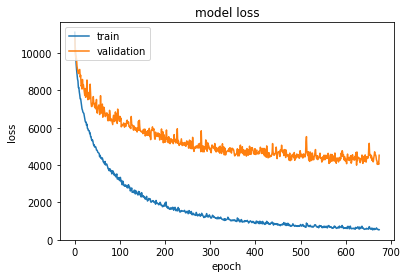

In [21]:
import matplotlib.pyplot as plt
# list all data in history
print(train_history.history.keys())
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# 然後你剛剛洗掉了 哈哈xdd d
我想說為什麼變得很奇怪XD
哈哈 我的錯，我應該記錄在ppt的，但起碼有知道 mae = 39 這個數字比較重要~~PJjJ真的有比較好ㄟ 
對阿，而且我有點驚訝，筆xgb, lgb 好 (tree= 500的時候) 昭賢說她是用 20 萬，mae = 36，只是這個 20 萬我有點嚇到，一般不會這麼多xd
對阿 我那時候聽也覺得有點猛 可是她mae又好  佑鑫就叫她繼續給她長
這個嘛....我覺得風險可能有點大，但一時之間也說不清楚，我給你看我剛剛測試的 mae 其實 50-60左右
那為什麼昭賢那個那麼好 ，因為我只用 500 ，她用 20 萬
這樣的疑慮是在哪  因為如果他測完用test去看是mae=36這樣不好嗎
理論上是沒有不好，test 畢竟沒下去訓練，只是....我還是覺得哪裡怪怪，但一時之間想不清楚 哈哈
因為照我的經驗，無論是手中案子(1300萬筆)，或是kaggle，好像都沒有到 20 萬過~~
你有看過她的code媽  還是你有跟佑鑫說你覺得有點怪嗎~~
還沒看過，因為我自己也還沒說服自己(只是聽到 20萬，覺得...嗯? 這種感覺)，我還在思考這件事
了解 明天我們會跟佑鑫討論 再看看右心覺得怎樣
我是覺得先維持現狀，認定 20 萬最好應該可以，也就是 mae = 36 這個數字，反正若我有想到什麼疑慮，或是你們討論覺得哪裡怪怪的，再修改就好
我等等也會繼續做 stacking，我現在是要先驗證，本來 xgb (mae = 58) 跟 lgb (mae = 61)，把這兩個 stacking 後，效果會提升，這件事
如果確定了，那也有機會結合朝賢的模型(mae = 36)，以及妳的模型 (mae=39)，進一步提升這樣～
了解 我這裡有個疑問 就是 假日我們用xgb跑不是mae =40~己而已 妳這次試怎麼變58
那時候我們是用 data16，我剛剛是用data 8 目的是想跟你的dnn比較
!!!!!!!!!!!!!!對欸怎麼會
對阿  所以我才想說奇怪XDD
那應該是我這裡參數設定，跟那時候不太一樣～ 我記得那時候是照又新 r 的參數，但我這邊寫的時候是自己設定的 哈哈
這部分其實參數改一下，應該就能重現 40幾的結果了
感謝你提醒我～哈哈
哈哈哈  妳再看ppt那裡有參數紀錄
那我這裡就先讓給你囉XDDDDDD

等等1; 幫我記錄一下4layer result
其實現在已經跑完了欸，在我們用這種很好笑的方式聊天的過程中
那看一下結果八 XDD
好阿～交給你操作~~~

In [15]:
def build_model(node_fraction, learning_rate):
    model = Sequential()

    # Hidden-1
    model.add(Dense(input_dim = input_dim, units = round(input_dim*node_fraction), kernel_initializer = 'glorot_normal', activation = 'relu') )
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Hidden-2
    model.add(Dense(units=round(input_dim*node_fraction**2), kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.2))
    
    # Hidden-3
    model.add(Dense(units=round(input_dim*node_fraction**3), kernel_initializer='glorot_normal', activation='relu'))
    model.add(Dropout(0.2))
    
    # Hidden-4
    model.add(Dense(units=round(input_dim*node_fraction**4), kernel_initializer='glorot_normal', activation='relu'))

    # output
    model.add(Dense(units = 1,kernel_initializer = 'glorot_normal'))

    print(model.summary())

    # compile
    model.compile(loss='mse',  
                  optimizer=Adam(lr=learning_rate), 
                  metrics=['mae'],
                 ) 
    
    return model

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')
# model
model=build_model(5/6, 0.001)
train_history = model.fit(x = X_train,
                          y = y_train,
                          validation_split = 0.2, 
#                           validation_data = (X_valid_cv, y_valid_cv),
                          epochs = 1000, 
                          batch_size = 200,
                          verbose = 1,
                          callbacks = [early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2742)              9023922   
_________________________________________________________________
batch_normalization_3 (Batch (None, 2742)              10968     
_________________________________________________________________
dropout_5 (Dropout)          (None, 2742)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2285)              6267755   
_________________________________________________________________
dropout_6 (Dropout)          (None, 2285)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1904)              4352544   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1904)              0         
__________

65395/65395 [==============================] - 9s 141us/step - loss: 5517.3315 - mean_absolute_error: 49.4581 - val_loss: 7330.7667 - val_mean_absolute_error: 53.8763
Epoch 38/1000
65395/65395 [==============================] - 10s 146us/step - loss: 5371.9118 - mean_absolute_error: 48.8874 - val_loss: 7138.0911 - val_mean_absolute_error: 53.4641
Epoch 39/1000
65395/65395 [==============================] - 9s 143us/step - loss: 5306.8036 - mean_absolute_error: 48.6546 - val_loss: 7142.4894 - val_mean_absolute_error: 52.8602
Epoch 40/1000
65395/65395 [==============================] - 10s 146us/step - loss: 5356.6503 - mean_absolute_error: 48.6762 - val_loss: 7312.0411 - val_mean_absolute_error: 54.1930
Epoch 41/1000
65395/65395 [==============================] - 9s 143us/step - loss: 5289.2511 - mean_absolute_error: 48.5309 - val_loss: 7282.2596 - val_mean_absolute_error: 54.5082
Epoch 42/1000
65395/65395 [==============================] - 9s 143us/step - loss: 5147.9565 - mean_absolut

65395/65395 [==============================] - 10s 154us/step - loss: 3640.0170 - mean_absolute_error: 41.0020 - val_loss: 6471.2404 - val_mean_absolute_error: 49.7387
Epoch 83/1000
65395/65395 [==============================] - 10s 152us/step - loss: 3523.4989 - mean_absolute_error: 40.4044 - val_loss: 6374.9146 - val_mean_absolute_error: 49.6072
Epoch 84/1000
65395/65395 [==============================] - 10s 150us/step - loss: 3632.8350 - mean_absolute_error: 40.9103 - val_loss: 6297.3651 - val_mean_absolute_error: 49.2947
Epoch 85/1000
65395/65395 [==============================] - 10s 146us/step - loss: 3696.7172 - mean_absolute_error: 41.1978 - val_loss: 6167.9052 - val_mean_absolute_error: 49.3485
Epoch 86/1000
65395/65395 [==============================] - 9s 145us/step - loss: 3637.0817 - mean_absolute_error: 40.9894 - val_loss: 6544.9312 - val_mean_absolute_error: 51.2041
Epoch 87/1000
65395/65395 [==============================] - 10s 149us/step - loss: 3604.5180 - mean_abso

65395/65395 [==============================] - 9s 142us/step - loss: 2770.6643 - mean_absolute_error: 35.8790 - val_loss: 6181.1482 - val_mean_absolute_error: 47.6759
Epoch 128/1000
65395/65395 [==============================] - 10s 146us/step - loss: 2536.2312 - mean_absolute_error: 34.7738 - val_loss: 6155.2981 - val_mean_absolute_error: 48.3623
Epoch 129/1000
65395/65395 [==============================] - 22s 344us/step - loss: 2545.4099 - mean_absolute_error: 34.6904 - val_loss: 6130.1560 - val_mean_absolute_error: 48.1675
Epoch 130/1000
65395/65395 [==============================] - 27s 410us/step - loss: 2547.9321 - mean_absolute_error: 34.9190 - val_loss: 6028.3456 - val_mean_absolute_error: 48.5199
Epoch 131/1000
65395/65395 [==============================] - 25s 380us/step - loss: 2526.3475 - mean_absolute_error: 34.7715 - val_loss: 5870.7151 - val_mean_absolute_error: 48.5039
Epoch 132/1000
65395/65395 [==============================] - 24s 371us/step - loss: 2635.6024 - mean

Epoch 172/1000
65395/65395 [==============================] - 9s 141us/step - loss: 2067.6277 - mean_absolute_error: 31.2769 - val_loss: 5865.5178 - val_mean_absolute_error: 46.9622
Epoch 173/1000
65395/65395 [==============================] - 9s 141us/step - loss: 2082.9712 - mean_absolute_error: 31.2420 - val_loss: 6046.9966 - val_mean_absolute_error: 48.0238
Epoch 174/1000
65395/65395 [==============================] - 9s 141us/step - loss: 2093.0424 - mean_absolute_error: 31.3804 - val_loss: 5847.5758 - val_mean_absolute_error: 46.5797
Epoch 175/1000
65395/65395 [==============================] - 9s 141us/step - loss: 2027.0505 - mean_absolute_error: 30.9328 - val_loss: 5871.2783 - val_mean_absolute_error: 46.7982
Epoch 176/1000
65395/65395 [==============================] - 9s 141us/step - loss: 2060.0680 - mean_absolute_error: 31.0805 - val_loss: 5946.1258 - val_mean_absolute_error: 46.7785
Epoch 177/1000
65395/65395 [==============================] - 9s 141us/step - loss: 2012.5

Epoch 217/1000
65395/65395 [==============================] - 9s 145us/step - loss: 1655.8720 - mean_absolute_error: 27.7362 - val_loss: 5246.7162 - val_mean_absolute_error: 44.7294
Epoch 218/1000
65395/65395 [==============================] - 10s 146us/step - loss: 1737.6077 - mean_absolute_error: 28.2573 - val_loss: 5348.4202 - val_mean_absolute_error: 44.8188
Epoch 219/1000
65395/65395 [==============================] - 9s 145us/step - loss: 1698.6959 - mean_absolute_error: 28.0967 - val_loss: 5146.2062 - val_mean_absolute_error: 45.0027
Epoch 220/1000
65395/65395 [==============================] - 10s 146us/step - loss: 1577.5083 - mean_absolute_error: 27.4653 - val_loss: 5237.8663 - val_mean_absolute_error: 44.1865
Epoch 221/1000
65395/65395 [==============================] - 10s 146us/step - loss: 1662.9602 - mean_absolute_error: 27.7666 - val_loss: 5631.2398 - val_mean_absolute_error: 46.2144
Epoch 222/1000
65395/65395 [==============================] - 10s 156us/step - loss: 17

Epoch 262/1000
65395/65395 [==============================] - 9s 143us/step - loss: 1393.5350 - mean_absolute_error: 25.2238 - val_loss: 5486.1379 - val_mean_absolute_error: 45.5850
Epoch 263/1000
65395/65395 [==============================] - 9s 142us/step - loss: 1421.1239 - mean_absolute_error: 25.7008 - val_loss: 5013.7959 - val_mean_absolute_error: 43.8790
Epoch 264/1000
65395/65395 [==============================] - 9s 143us/step - loss: 1369.9329 - mean_absolute_error: 25.3017 - val_loss: 4843.8675 - val_mean_absolute_error: 42.7507
Epoch 265/1000
65395/65395 [==============================] - 10s 148us/step - loss: 1333.8322 - mean_absolute_error: 24.9085 - val_loss: 4731.4584 - val_mean_absolute_error: 42.3464
Epoch 266/1000
65395/65395 [==============================] - 10s 147us/step - loss: 1358.2469 - mean_absolute_error: 24.9605 - val_loss: 4884.5678 - val_mean_absolute_error: 42.9054
Epoch 267/1000
65395/65395 [==============================] - 10s 145us/step - loss: 133

Epoch 307/1000
65395/65395 [==============================] - 10s 149us/step - loss: 1274.0551 - mean_absolute_error: 24.2312 - val_loss: 4979.2609 - val_mean_absolute_error: 43.3002
Epoch 308/1000
65395/65395 [==============================] - 10s 147us/step - loss: 1225.4437 - mean_absolute_error: 23.8095 - val_loss: 5002.3341 - val_mean_absolute_error: 42.6636
Epoch 309/1000
65395/65395 [==============================] - 10s 146us/step - loss: 1244.7173 - mean_absolute_error: 24.0113 - val_loss: 4886.8433 - val_mean_absolute_error: 42.0185
Epoch 310/1000
65395/65395 [==============================] - 10s 148us/step - loss: 1189.4206 - mean_absolute_error: 23.6148 - val_loss: 4913.8591 - val_mean_absolute_error: 42.4877
Epoch 311/1000
65395/65395 [==============================] - 9s 145us/step - loss: 1192.4959 - mean_absolute_error: 23.5568 - val_loss: 5155.1982 - val_mean_absolute_error: 43.6925
Epoch 312/1000
65395/65395 [==============================] - 10s 148us/step - loss: 1

Epoch 352/1000
65395/65395 [==============================] - 9s 141us/step - loss: 1060.1130 - mean_absolute_error: 21.9185 - val_loss: 4847.4827 - val_mean_absolute_error: 41.9703
Epoch 353/1000
65395/65395 [==============================] - 9s 141us/step - loss: 1033.9559 - mean_absolute_error: 21.9003 - val_loss: 4788.5383 - val_mean_absolute_error: 41.7718
Epoch 354/1000
65395/65395 [==============================] - 9s 141us/step - loss: 1020.0607 - mean_absolute_error: 21.7345 - val_loss: 4622.0358 - val_mean_absolute_error: 41.5810
Epoch 355/1000
65395/65395 [==============================] - 9s 141us/step - loss: 1059.3475 - mean_absolute_error: 21.9771 - val_loss: 4491.2648 - val_mean_absolute_error: 40.6506
Epoch 356/1000
65395/65395 [==============================] - 9s 141us/step - loss: 1043.5473 - mean_absolute_error: 21.9543 - val_loss: 4509.3943 - val_mean_absolute_error: 41.2363
Epoch 357/1000
65395/65395 [==============================] - 9s 141us/step - loss: 993.45

65395/65395 [==============================] - 9s 141us/step - loss: 972.2794 - mean_absolute_error: 21.0625 - val_loss: 4607.8268 - val_mean_absolute_error: 40.4202
Epoch 398/1000
65395/65395 [==============================] - 9s 141us/step - loss: 899.8132 - mean_absolute_error: 20.4475 - val_loss: 4633.0861 - val_mean_absolute_error: 41.4123
Epoch 399/1000
65395/65395 [==============================] - 9s 141us/step - loss: 874.6986 - mean_absolute_error: 20.2347 - val_loss: 4584.8921 - val_mean_absolute_error: 40.8604
Epoch 400/1000
65395/65395 [==============================] - 9s 141us/step - loss: 903.5018 - mean_absolute_error: 20.4695 - val_loss: 4878.0346 - val_mean_absolute_error: 41.1971
Epoch 401/1000
65395/65395 [==============================] - 9s 141us/step - loss: 878.0774 - mean_absolute_error: 20.4269 - val_loss: 4573.5716 - val_mean_absolute_error: 40.2807
Epoch 402/1000
65395/65395 [==============================] - 9s 141us/step - loss: 862.0991 - mean_absolute_e

65395/65395 [==============================] - 9s 141us/step - loss: 834.4309 - mean_absolute_error: 19.6735 - val_loss: 4596.2808 - val_mean_absolute_error: 40.1289
Epoch 443/1000
65395/65395 [==============================] - 9s 141us/step - loss: 869.4854 - mean_absolute_error: 19.8653 - val_loss: 4529.6460 - val_mean_absolute_error: 39.5113
Epoch 444/1000
65395/65395 [==============================] - 9s 141us/step - loss: 834.6777 - mean_absolute_error: 19.4110 - val_loss: 4577.9901 - val_mean_absolute_error: 40.6358
Epoch 445/1000
65395/65395 [==============================] - 9s 141us/step - loss: 818.8229 - mean_absolute_error: 19.4297 - val_loss: 4620.1595 - val_mean_absolute_error: 40.9390
Epoch 446/1000
65395/65395 [==============================] - 9s 141us/step - loss: 852.3350 - mean_absolute_error: 19.7604 - val_loss: 4751.4674 - val_mean_absolute_error: 40.6734
Epoch 447/1000
65395/65395 [==============================] - 9s 141us/step - loss: 858.6493 - mean_absolute_e

65395/65395 [==============================] - 9s 141us/step - loss: 733.0536 - mean_absolute_error: 18.3724 - val_loss: 4672.0047 - val_mean_absolute_error: 40.6328
Epoch 488/1000
65395/65395 [==============================] - 9s 141us/step - loss: 716.9050 - mean_absolute_error: 18.3018 - val_loss: 4253.2649 - val_mean_absolute_error: 39.0597
Epoch 489/1000
65395/65395 [==============================] - 9s 141us/step - loss: 767.3804 - mean_absolute_error: 18.7774 - val_loss: 4381.8807 - val_mean_absolute_error: 40.1572
Epoch 490/1000
65395/65395 [==============================] - 9s 141us/step - loss: 753.5299 - mean_absolute_error: 18.7377 - val_loss: 4483.8384 - val_mean_absolute_error: 39.4931
Epoch 491/1000
65395/65395 [==============================] - 9s 141us/step - loss: 732.5703 - mean_absolute_error: 18.5320 - val_loss: 4370.3967 - val_mean_absolute_error: 39.9647
Epoch 492/1000
65395/65395 [==============================] - 9s 141us/step - loss: 718.6153 - mean_absolute_e

65395/65395 [==============================] - 9s 141us/step - loss: 791.9399 - mean_absolute_error: 18.9743 - val_loss: 4531.4401 - val_mean_absolute_error: 40.1516
Epoch 533/1000
65395/65395 [==============================] - 9s 141us/step - loss: 775.4416 - mean_absolute_error: 18.3458 - val_loss: 4690.7374 - val_mean_absolute_error: 40.0210
Epoch 534/1000
65395/65395 [==============================] - 9s 141us/step - loss: 796.0603 - mean_absolute_error: 18.6445 - val_loss: 4831.4123 - val_mean_absolute_error: 39.4941
Epoch 535/1000
65395/65395 [==============================] - 9s 142us/step - loss: 751.5349 - mean_absolute_error: 18.2636 - val_loss: 4535.1705 - val_mean_absolute_error: 38.8416
Epoch 536/1000
65395/65395 [==============================] - 9s 141us/step - loss: 693.1297 - mean_absolute_error: 17.6511 - val_loss: 4375.1827 - val_mean_absolute_error: 39.3100
Epoch 537/1000
65395/65395 [==============================] - 9s 141us/step - loss: 687.4147 - mean_absolute_e

65395/65395 [==============================] - 9s 141us/step - loss: 682.2897 - mean_absolute_error: 17.5515 - val_loss: 4646.7192 - val_mean_absolute_error: 39.9203
Epoch 578/1000
65395/65395 [==============================] - 9s 141us/step - loss: 704.2585 - mean_absolute_error: 17.8958 - val_loss: 4223.6625 - val_mean_absolute_error: 39.3627
Epoch 579/1000
65395/65395 [==============================] - 9s 141us/step - loss: 647.1492 - mean_absolute_error: 17.3983 - val_loss: 4287.6692 - val_mean_absolute_error: 39.0462
Epoch 580/1000
65395/65395 [==============================] - 9s 141us/step - loss: 612.2861 - mean_absolute_error: 16.9661 - val_loss: 4096.0097 - val_mean_absolute_error: 38.3126
Epoch 581/1000
65395/65395 [==============================] - 9s 143us/step - loss: 606.5461 - mean_absolute_error: 16.8884 - val_loss: 4375.0165 - val_mean_absolute_error: 39.8617
Epoch 582/1000
65395/65395 [==============================] - 9s 141us/step - loss: 614.9862 - mean_absolute_e

65395/65395 [==============================] - 10s 150us/step - loss: 558.5619 - mean_absolute_error: 16.2671 - val_loss: 4443.1531 - val_mean_absolute_error: 38.7087
Epoch 623/1000
65395/65395 [==============================] - 10s 150us/step - loss: 660.2441 - mean_absolute_error: 17.2758 - val_loss: 4549.1157 - val_mean_absolute_error: 39.1983
Epoch 624/1000
65395/65395 [==============================] - 10s 148us/step - loss: 632.1159 - mean_absolute_error: 16.7781 - val_loss: 4678.4808 - val_mean_absolute_error: 40.2691
Epoch 625/1000
65395/65395 [==============================] - 10s 146us/step - loss: 612.8668 - mean_absolute_error: 16.9954 - val_loss: 3994.0041 - val_mean_absolute_error: 37.6088
Epoch 626/1000
65395/65395 [==============================] - 10s 147us/step - loss: 623.0972 - mean_absolute_error: 16.9975 - val_loss: 4697.2698 - val_mean_absolute_error: 40.6548
Epoch 627/1000
65395/65395 [==============================] - 10s 146us/step - loss: 658.2209 - mean_abso

65395/65395 [==============================] - 10s 156us/step - loss: 567.3295 - mean_absolute_error: 16.2166 - val_loss: 4550.2416 - val_mean_absolute_error: 38.8227
Epoch 668/1000
65395/65395 [==============================] - 10s 150us/step - loss: 571.5686 - mean_absolute_error: 16.2931 - val_loss: 4463.0358 - val_mean_absolute_error: 38.8831
Epoch 669/1000
65395/65395 [==============================] - 10s 150us/step - loss: 630.0649 - mean_absolute_error: 16.8480 - val_loss: 4275.6465 - val_mean_absolute_error: 38.0760
Epoch 670/1000
65395/65395 [==============================] - 10s 150us/step - loss: 590.5387 - mean_absolute_error: 16.4987 - val_loss: 4227.2220 - val_mean_absolute_error: 38.3239
Epoch 671/1000
65395/65395 [==============================] - 10s 149us/step - loss: 563.6307 - mean_absolute_error: 16.1112 - val_loss: 4034.9035 - val_mean_absolute_error: 37.7390
Epoch 672/1000
65395/65395 [==============================] - 10s 147us/step - loss: 556.5922 - mean_abso

In [22]:
mse=sum((y_test-y_pred)**2)/len(y_test)
mae=sum(abs(y_test-y_pred))/len(y_test)
print(mse, mae)

5089.061724440504 39.62833524499264


### 你有試喔
對 我正在試 4 layers 的
喔~~ 哈哈 那我就暫時先不管了

 3 layer的效果好嗎
 我剛剛看 mae = 39
 你後來有開dropout是媽
 後面四層的，前三層有開
 喔~~ 了解 因為我傍晚用的事沒開的
 我看一下
 
這個嘛? 對
所以這次也39囉
對呀 看起來是這樣
我應該沒用錯吧XDD
沒有哦，因為剛剛模型還在訓練時，妳重跑上面的test performance，所以其實上面現在的 test performance，是這個模型的結果
妳記錄一下道 ppt
 吧
 oKOK hhaha good
 你明天才回去對嗎
 沒有阿 我已經在台南了 哈哈
 是哦，其實可以多待一天的，明早再回來
 明早回來不方便
 哦～要上班，這樣還要先載去搭車妳
 所以你剛剛才到嗎？
 沒有阿  到蠻久的了  哈哈哈哈哈
 是佑鑫請你用staking媽
 沒有 
 我只是想說，他有在想要做stacking，那我就幫忙寫一下
 畢竟他現在還在用資料
 喔喔 也是  整個又要被妳ccarry一潑了
 沒拉，現再也不確定 stacking 效果好不好，這也是我第一次實踐，所以還在實驗中，算是一個機會吧，如果有機會提升的話，這樣你們就更有機會去美國
 哈哈哈哈 美國去一坡這樣 好啦 我要先去寫會議紀錄了XDD
 好 der，看晚點寫完，要不要聊天~~~XDD
 
 我寫完可能就要睡覺時間了  哈哈哈哈哈哈
 QAQ
 好吧....
 XDDDD
 妳快去寫～早點寫完才能早點睡這樣～
嗯嗯嗯 掰囉
好的(如果寫完發現很早，it's welcome chatting !!! hahahaha)
就你最想聊SXDDDDDD
我是覺得我應該寫完 也差不多到睡覺時間了拉XD
對阿，我最想聊這樣xddd 我知道啦~ It needs to conclude your record to write the meeting record, that's will cost you much time, I know
SO I have to leave now
okok, I will alwaysno nonoononoononono hahahahaahahahaahahahah by
e..b..yeby
eb.yebyybyebyebyebeybeybbeyeyb
ebyeby.eybebyebyebyebyebebe
......you don't let me to finish!!!!!yes bye ~ok fine bye xXD bye